# COMP90049 Introduction to Machine Learning, 2020 Semester 2

## The University of Melbourne, School of Computing and Information Systems
-----
## Project 2: Music Genre Prediction from Audio, Metadata and Text Features!
-----
###### Student Name(s): Xulin Yang
###### Python version: 3.6.5
###### Submission deadline: 5 PM 16 October

# Import

In [657]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from pprint import pprint
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn import tree
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
import string
import re
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import StackingClassifier, BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.linear_model import LogisticRegression
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.23.2.


In [47]:
RANDOM_STATE = 90049

In [48]:
def select_df1_columns_based_on_df2(df1: pd.DataFrame, df2: pd.DataFrame):
    return df1[list(df2.columns)]

# load dataset

In [6]:
def read_csv(file_path: str):
    return pd.read_csv(file_path)

In [7]:
test_features = read_csv('dataset/test_features.csv')
train_features = read_csv('dataset/train_features.csv')
train_labels = read_csv('dataset/train_labels.csv')
valid_features = read_csv('dataset/valid_features.csv')
valid_labels = read_csv('dataset/valid_labels.csv')

In [8]:
test_features = test_features.set_index('trackID')
train_features = train_features.set_index('trackID')
train_labels = train_labels.set_index('trackID')
valid_features = valid_features.set_index('trackID')
valid_labels = valid_labels.set_index('trackID')

In [9]:
valid_labels.columns

Index(['genre'], dtype='object')

In [10]:
valid_features.columns

Index(['title', 'tags', 'loudness', 'tempo', 'time_signature', 'key', 'mode',
       'duration', 'vect_1', 'vect_2',
       ...
       'vect_139', 'vect_140', 'vect_141', 'vect_142', 'vect_143', 'vect_144',
       'vect_145', 'vect_146', 'vect_147', 'vect_148'],
      dtype='object', length=156)

# train test evaluate functions

## train

In [718]:
# this function train for input models given train X and train Y
def train(models: list, X: pd.DataFrame, Y: pd.DataFrame):
    trained = []
    for m in models:
        m.fit(X, Y.values.ravel())
        trained.append(m)
    return trained

## predict

In [717]:
# this function predict for input models given test X
def predict(models: list, X: pd.DataFrame):
    y_preds = []
    for m in models:
        preds = m.predict(X)
        y_preds.append(pd.DataFrame(preds, columns=["genre"], index=X.index))
    return y_preds

## evaluate

In [13]:
# This function should evaluate a set of predictions in terms of metrics
def evaluate(pred, true, average='macro'):
    CM = metrics.confusion_matrix(true, pred) # Confusion Matrix
    Acc = metrics.accuracy_score(true, pred) # Accuracy
#     'micro':
#         Calculate metrics globally by counting the total true positives, false 
#         negatives and false positives.

#     'macro':
#         Calculate metrics for each label, and find their unweighted mean. This 
#         does not take label imbalance into account.

#     'weighted':
#         Calculate metrics for each label, and find their average weighted by 
#         support (the number of true instances for each label). This alters 
#         ‘macro’ to account for label imbalance; it can result in an F-score that 
#         is not between precision and recall.
#   
#   As we have imbalanced class distribution, we use macro
    precf1 = metrics.precision_recall_fscore_support(true, pred, average=average) # Precision, Recall and F1-score
    return CM, Acc, precf1

## helper function

In [14]:
def select_audio_features(data: pd.DataFrame):
    tmp = pd.DataFrame()
    for i in range(1, 148+1):
        tmp["vect_" + str(i)] = data["vect_" + str(i)]
    return tmp

In [346]:
def select_meta_data_features(data: pd.DataFrame):
    tmp = data.copy()
    if "key" in data.columns:
        tmp = tmp[["loudness", "tempo", "time_signature", "key", "mode", "duration"]]
    else:
        tmp = tmp[["loudness", "tempo", "time_signature", 
                   "key_0", 
                   "key_1", 
                   "key_2", 
                   "key_3", 
                   "key_4", 
                   "key_5", 
                   "key_6", 
                   "key_7", 
                   "key_8", 
                   "key_9", 
                   "key_10", 
                   "key_11", 
                   "mode", "duration"]]
    return tmp

In [16]:
def one_hot_encoding(data: pd.DataFrame, column_name):
    new_df = data.copy()
    new_df = pd.get_dummies(new_df, prefix=column_name, columns=[column_name])
    
    return new_df

In [726]:
def draw_k_line_chart(x, y, ylabel, title, xlabel="k"):
#     plt.figure(figsize=(10, 3))
    plt.plot(x, y, 'b-')
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.title(title, fontsize=20)
    plt.show()

### normalize between 0 and 1 (not important)

In [17]:
def standard_continuous(data: pd.DataFrame):
    scaler = StandardScaler()
    scaler.fit(data)
    return pd.DataFrame(scaler.transform(data), columns=data.columns, index=data.index)

# train_audio_normalized = standard_continuous(train_audio)
# train_audio_normalized.describe()

In [18]:
def transform_continuous_0_1(data: pd.DataFrame):
    scaler = MinMaxScaler()
    scaler.fit(data)
    return pd.DataFrame(scaler.transform(data), columns=data.columns, index=data.index)

# train_audio_normalized = transform_continuous_0_1(train_audio)
# train_audio_normalized.describe()

In [124]:
train_merged = train_features.merge(train_labels, left_index=True, right_index=True)
train_merged.sample(2)

title  \
trackID                        
1067     Smoke In Our Lights   
354       Send In The Clowns   

                                                      tags  loudness    tempo  \
trackID                                                                         
1067     i, the, you, to, and, a, me, it, not, in, my, ...   -15.386  201.075   
354      i, the, you, to, and, a, me, it, not, in, my, ...   -15.546  101.577   

         time_signature  key  mode   duration     vect_1     vect_2  \
trackID                                                               
1067                  3    6     1  421.01506  34.900384 -35.517311   
354                   4    8     0  455.39220  36.235423  11.008039   

                 ...           vect_140  vect_141  vect_142  vect_143  \
trackID          ...                                                    
1067             ...           0.000149  0.000155  0.000161  0.000162   
354              ...           0.000145  0.000144  0.000156  0.000130   

         vect_144  vect_145  vect_146  vect_147   vect_148  \
trackID                                                      
1067     0.000156  0.000133  0.000117  0.299549  12.507585   
354      0.000114  0.000104  0.000103  0.224302   1.605239   

                        genre  
trackID                        
1067                     folk  
354      classic pop and rock  

[2 rows x 157 columns]

# Exploratory data analysis & feature engineering

## Audio features & class (not related to report)

### select audio features

In [14]:
train_audio = select_audio_features(train_features)
train_audio.corr()

vect_1    vect_2    vect_3    vect_4    vect_5    vect_6  \
vect_1    1.000000  0.613471  0.361311  0.143216 -0.380902 -0.459982   
vect_2    0.613471  1.000000  0.157824  0.178521 -0.374714 -0.274621   
vect_3    0.361311  0.157824  1.000000  0.363953 -0.145629 -0.092559   
vect_4    0.143216  0.178521  0.363953  1.000000  0.009060  0.313452   
vect_5   -0.380902 -0.374714 -0.145629  0.009060  1.000000  0.212061   
vect_6   -0.459982 -0.274621 -0.092559  0.313452  0.212061  1.000000   
vect_7    0.263894  0.193458  0.074088  0.321836 -0.162620 -0.217624   
vect_8    0.082942  0.214211  0.204326  0.086015 -0.045031 -0.011302   
vect_9    0.254093  0.169769  0.094127 -0.029708 -0.281771 -0.167127   
vect_10   0.323874  0.546503  0.076741  0.130211 -0.300248 -0.220595   
vect_11   0.153325 -0.045343  0.143365  0.293636 -0.035830 -0.308254   
vect_12  -0.167586 -0.105211 -0.090018 -0.185825  0.014901  0.102603   
vect_13  -0.406950 -0.222639 -0.122706 -0.013629  0.261670  0.197389   
vect_14  -0.498061 -0.456328 -0.235516 -0.037499  0.323167  0.260443   
vect_15  -0.478748 -0.258190 -0.215499  0.194320  0.365769  0.412503   
vect_16  -0.463101 -0.264022 -0.342665  0.246641  0.352055  0.652703   
vect_17  -0.436109 -0.267832 -0.118118  0.085934  0.296741  0.324864   
vect_18  -0.380822 -0.154507 -0.370752  0.426763  0.276929  0.727504   
vect_19  -0.517137 -0.332406 -0.179582  0.073137  0.464986  0.460029   
vect_20  -0.466675 -0.330412 -0.377711  0.173627  0.367059  0.571597   
vect_21  -0.551092 -0.447120 -0.160773 -0.083376  0.361334  0.396625   
vect_22  -0.479175 -0.323787 -0.378578  0.192894  0.389969  0.645455   
vect_23  -0.393394 -0.191458 -0.331006  0.317364  0.321967  0.708352   
vect_24  -0.509419 -0.410185 -0.126203 -0.025384  0.446320  0.364120   
vect_25   0.552228  0.709277  0.348092  0.182848 -0.343211 -0.295746   
vect_26   0.399394  0.565132  0.349894  0.184477 -0.266491 -0.181765   
vect_27   0.404807  0.647881  0.099221  0.234474 -0.323367 -0.183723   
vect_28  -0.135888 -0.134427 -0.153422  0.180864  0.146914  0.234451   
vect_29   0.830437  0.517283  0.366569  0.128667 -0.364430 -0.395130   
vect_30  -0.655409 -0.916110 -0.237425 -0.194514  0.535401  0.305441   
...            ...       ...       ...       ...       ...       ...   
vect_119 -0.243920 -0.029974 -0.237502  0.057510  0.344919  0.300242   
vect_120 -0.303111 -0.192779 -0.409550 -0.003470  0.257004  0.257753   
vect_121 -0.101846 -0.043315 -0.025151 -0.011254 -0.011158  0.059524   
vect_122 -0.170977 -0.046491 -0.074023 -0.037931  0.043509  0.062809   
vect_123 -0.584015 -0.541472 -0.352405 -0.020555  0.436281  0.495420   
vect_124 -0.455479 -0.357909 -0.287238  0.061147  0.363651  0.528335   
vect_125 -0.413394 -0.303237 -0.187240 -0.003255  0.342484  0.537741   
vect_126 -0.398930 -0.300429 -0.167929 -0.001293  0.293035  0.514681   
vect_127 -0.417453 -0.307839 -0.188574  0.062792  0.382152  0.519967   
vect_128 -0.448441 -0.350776 -0.199569 -0.003026  0.356463  0.515478   
vect_129 -0.425144 -0.322811 -0.167809  0.024659  0.344889  0.509061   
vect_130 -0.427495 -0.310299 -0.154959  0.052379  0.386607  0.494494   
vect_131 -0.419849 -0.296685 -0.120581  0.064407  0.340062  0.484338   
vect_132 -0.427505 -0.312852 -0.112618  0.075865  0.356517  0.481330   
vect_133 -0.407328 -0.297193 -0.107492  0.072793  0.363293  0.465637   
vect_134 -0.395471 -0.296456 -0.101457  0.067319  0.360924  0.445582   
vect_135  0.283910  0.118086 -0.148320  0.159622  0.094095  0.023672   
vect_136  0.279007  0.119088 -0.151785  0.157436  0.096615  0.025005   
vect_137  0.286224  0.119234 -0.154017  0.158024  0.090615  0.022371   
vect_138  0.304424  0.131580 -0.156215  0.164690  0.080471  0.012994   
vect_139  0.314225  0.151462 -0.161485  0.170677  0.062352  0.002324   
vect_140  0.319039  0.152527 -0.161256  0.173420  0.061043 -0.001885   
vect_141  0.322335  0.162283 -0.167079  0.176283  0.050678 -0.008678   
vect_142  0.326845  0.162617 -0.164305  0.178513  0.

In [15]:
train_audio.sample(axis=1, n=10).sort_index(axis=1).describe()

vect_12     vect_143     vect_146      vect_21      vect_51  \
count  7678.000000  7678.000000  7678.000000  7678.000000  7678.000000   
mean      3.360188     0.000816     0.000700   370.318679     0.001681   
std       7.515652     0.000724     0.000654   165.447829     0.001311   
min     -33.632458     0.000000     0.000000    44.135621     0.000000   
25%      -1.461866     0.000317     0.000274   255.590882     0.000615   
50%       3.200207     0.000634     0.000531   343.575149     0.001389   
75%       7.920112     0.001056     0.000878   447.416731     0.002454   
max      53.389272     0.006645     0.006632  1675.813435     0.011878   

           vect_61      vect_81      vect_91      vect_95      vect_99  
count  7678.000000  7678.000000  7678.000000  7678.000000  7678.000000  
mean      0.941138     0.001344     4.559901     0.523064     0.380955  
std       0.280573     0.001100     1.496051     0.177004     0.128736  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.738063     0.000460     3.519293     0.393958     0.287025  
50%       0.903122     0.001073     4.339196     0.502605     0.370070  
75%       1.098581     0.001946     5.457023     0.626729     0.459442  
max       3.068298     0.010600    28.513812     1.424533     1.101159

### drop highly correlated, >=0.3

In [18]:
def drop_highly_correlated(data: pd.DataFrame, threshold=0.3):
    # Create correlation matrix
    corr_matrix = data.corr().abs()

    remained = [corr_matrix.columns[0]]
    for column in corr_matrix.columns[1:]:
        to_select = True
        for c in remained:
            if corr_matrix[column][c] >= threshold:
                to_select = False
        if to_select:
            remained.append(column)

    return data[remained]

train_audio_normalized_low_corr = drop_highly_correlated(train_audio_normalized)

valid_audio_normalized_low_corr = select_df1_columns_based_on_df2(valid_features, train_audio_normalized_low_corr)
valid_audio_normalized_low_corr = transform_continuous_0_1(valid_audio_normalized_low_corr)
train_audio_normalized_low_corr.corr()

vect_1    vect_4    vect_8    vect_9   vect_11   vect_12   vect_28  \
vect_1   1.000000  0.143216  0.082942  0.254093  0.153325 -0.167586 -0.135888   
vect_4   0.143216  1.000000  0.086015 -0.029708  0.293636 -0.185825  0.180864   
vect_8   0.082942  0.086015  1.000000 -0.122371 -0.251873 -0.095729 -0.129706   
vect_9   0.254093 -0.029708 -0.122371  1.000000 -0.019650  0.089415 -0.039546   
vect_11  0.153325  0.293636 -0.251873 -0.019650  1.000000  0.213998  0.021981   
vect_12 -0.167586 -0.185825 -0.095729  0.089415  0.213998  1.000000 -0.005021   
vect_28 -0.135888  0.180864 -0.129706 -0.039546  0.021981 -0.005021  1.000000   
vect_32 -0.125213 -0.270113 -0.158684  0.014363  0.017849  0.007400 -0.059309   
vect_35  0.041237 -0.143982  0.026654 -0.068363 -0.047907  0.056239  0.004506   
vect_36  0.123246 -0.057346  0.001975  0.178397  0.013849  0.069425 -0.051670   
vect_37  0.020191 -0.004109  0.092607  0.015619 -0.157042 -0.128340  0.043093   
vect_38  0.249180 -0.038031  0.118402  0.205017 -0.080726 -0.079521 -0.123882   
vect_39  0.176923  0.006549  0.116893  0.119039 -0.174763 -0.167215 -0.024224   
vect_41  0.036430  0.016927  0.034822  0.010816 -0.152472 -0.133916  0.061039   
vect_55 -0.037805  0.011349  0.023075 -0.005052 -0.008913  0.005443 -0.008465   
vect_58  0.062877  0.265278  0.099649 -0.024627 -0.141883 -0.166333  0.272766   
vect_88 -0.102857  0.089628  0.096239 -0.076337 -0.094346  0.001394 -0.166053   
vect_91 -0.171568 -0.049630  0.069155 -0.089513 -0.110107  0.019017 -0.130244   

          vect_32   vect_35   vect_36   vect_37   vect_38   vect_39   vect_41  \
vect_1  -0.125213  0.041237  0.123246  0.020191  0.249180  0.176923  0.036430   
vect_4  -0.270113 -0.143982 -0.057346 -0.004109 -0.038031  0.006549  0.016927   
vect_8  -0.158684  0.026654  0.001975  0.092607  0.118402  0.116893  0.034822   
vect_9   0.014363 -0.068363  0.178397  0.015619  0.205017  0.119039  0.010816   
vect_11  0.017849 -0.047907  0.013849 -0.157042 -0.080726 -0.174763 -0.152472   
vect_12  0.007400  0.056239  0.069425 -0.128340 -0.079521 -0.167215 -0.133916   
vect_28 -0.059309  0.004506 -0.051670  0.043093 -0.123882 -0.024224  0.061039   
vect_32  1.000000  0.132702  0.108337 -0.034128  0.053074  0.016505 -0.019420   
vect_35  0.132702  1.000000  0.112221  0.152352  0.142193  0.101443  0.042486   
vect_36  0.108337  0.112221  1.000000  0.046396  0.289810  0.030438 -0.012414   
vect_37 -0.034128  0.152352  0.046396  1.000000  0.075195  0.144799  0.090298   
vect_38  0.053074  0.142193  0.289810  0.075195  1.000000  0.237216  0.091376   
vect_39  0.016505  0.101443  0.030438  0.144799  0.237216  1.000000  0.228255   
vect_41 -0.019420  0.042486 -0.012414  0.090298  0.091376  0.228255  1.000000   
vect_55 -0.054762 -0.102722 -0.064258 -0.092024 -0.094816 -0.103164 -0.063750   
vect_58 -0.153974  0.145389  0.048125  0.135943  0.022988  0.102894  0.123798   
vect_88 -0.031807  0.018223 -0.012550  0.034909 -0.027282 -0.049231 -0.015886   
vect_91  0.020478 -0.019153  0.020607  0.006016 -0.020139 -0.027675 -0.023497   

          vect_55   vect_58   vect_88   vect_91  
vect_1  -0.037805  0.062877 -0.102857 -0.171568  
vect_4   0.011349  0.265278  0.089628 -0.049630  
vect_8   0.023075  0.099649  0.096239  0.069155  
vect_9  -0.005052 -0.024627 -0.076337 -0.089513  
vect_11 -0.008913 -0.141883 -0.094346 -0.110107  
vect_12  0.005443 -0.166333  0.001394  0.019017  
vect_28 -0.008465  0.272766 -0.166053 -0.130244  
vect_32 -0.054762 -0.153974 -0.031807  0.020478  
vect_35 -0.102722  0.145389  0.018223 -0.019153  
vect_36 -0.064258  0.048125 -0.012550  0.020607  
vect_37 -0.092024  0.135943  0.034909  0.006016  
vect_38 -0.094816  0.022988 -0.027282 -0.020139  
vect_39 -0.103164  0.102894 -0.049231 -0.027675  
vect_41 -0.063750  0.123798 -0.015886 -0.023497  
vect_55  1.000000 -0.027820  0.035655  0.037713  
vect_58 -0.027820  1.000000  0.160042 -0.041932  
vect_88  0.035655  0.160042  1.000000  0.220403  
vect_91  0.037713 -0.041932  0.

### select k best (half), chi

In [19]:
k = int(len(train_audio_normalized_low_corr.columns) / 2)

selector = SelectKBest(chi2, k=k)
selector.fit_transform(train_audio_normalized_low_corr, train_labels)
train_audio_normalized_low_corr_chi_selected = train_audio_normalized_low_corr[train_audio_normalized_low_corr.columns[selector.get_support()]]
valid_audio_normalized_low_corr_chi_selected = select_df1_columns_based_on_df2(valid_features, train_audio_normalized_low_corr_chi_selected)
valid_audio_normalized_low_corr_chi_selected = transform_continuous_0_1(valid_audio_normalized_low_corr_chi_selected)
train_audio_normalized_low_corr_chi_selected.describe()

vect_1       vect_4       vect_8       vect_9      vect_11  \
count  7678.000000  7678.000000  7678.000000  7678.000000  7678.000000   
mean      0.687967     0.364143     0.595336     0.461219     0.474519   
std       0.149335     0.091873     0.065007     0.096219     0.077009   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.593106     0.309180     0.556603     0.402614     0.431284   
50%       0.702343     0.358934     0.596846     0.461027     0.477054   
75%       0.801927     0.412623     0.635181     0.522757     0.519129   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

           vect_36      vect_38      vect_39      vect_58  
count  7678.000000  7678.000000  7678.000000  7678.000000  
mean      0.527084     0.564262     0.561863     0.255684  
std       0.099709     0.090358     0.083403     0.148599  
min       0.000000     0.000000     0.000000     0.000000  
25%       0.465790     0.507228     0.513358     0.156278  
50%       0.528301     0.564528     0.563551     0.220584  
75%       0.588691     0.622121     0.612966     0.310626  
max       1.000000     1.000000     1.000000     1.000000

In [20]:
train_audio_normalized_low_corr_chi_selected.corr()

vect_1    vect_4    vect_8    vect_9   vect_11   vect_36   vect_38  \
vect_1   1.000000  0.143216  0.082942  0.254093  0.153325  0.123246  0.249180   
vect_4   0.143216  1.000000  0.086015 -0.029708  0.293636 -0.057346 -0.038031   
vect_8   0.082942  0.086015  1.000000 -0.122371 -0.251873  0.001975  0.118402   
vect_9   0.254093 -0.029708 -0.122371  1.000000 -0.019650  0.178397  0.205017   
vect_11  0.153325  0.293636 -0.251873 -0.019650  1.000000  0.013849 -0.080726   
vect_36  0.123246 -0.057346  0.001975  0.178397  0.013849  1.000000  0.289810   
vect_38  0.249180 -0.038031  0.118402  0.205017 -0.080726  0.289810  1.000000   
vect_39  0.176923  0.006549  0.116893  0.119039 -0.174763  0.030438  0.237216   
vect_58  0.062877  0.265278  0.099649 -0.024627 -0.141883  0.048125  0.022988   

          vect_39   vect_58  
vect_1   0.176923  0.062877  
vect_4   0.006549  0.265278  
vect_8   0.116893  0.099649  
vect_9   0.119039 -0.024627  
vect_11 -0.174763 -0.141883  
vect_36  0.030438  0.048125  
vect_38  0.237216  0.022988  
vect_39  1.000000  0.102894  
vect_58  0.102894  1.000000

## label distribution

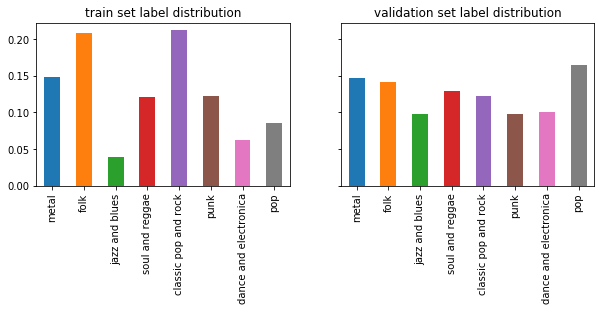

In [32]:
def draw_train_valid_label_distribution(train_labels: pd.DataFrame, valid_labels: pd.DataFrame, 
                                        title1='train set label distribution',
                                        title2='validation set label distribution'):
    xs = train_labels["genre"].unique()

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,3))
    ax1.set_title(title1)
    (train_labels["genre"].value_counts() / sum(train_labels["genre"].value_counts().sort_index()))[xs].plot(ax=ax1, kind='bar')

    ax2.set_title(title2)
    (valid_labels["genre"].value_counts() / sum(valid_labels["genre"].value_counts().sort_index()))[xs].plot(ax=ax2, kind='bar')
    plt.show()

draw_train_valid_label_distribution(train_labels, valid_labels)

## random forest select features (not related to report)

In [24]:
train_meta = one_hot_encoding(select_meta_data_features(train_features), "key")
train_audio = select_audio_features(train_features)

train_continuous_meta_audio = pd.concat([train_meta, train_audio], axis=1)
train_continuous_0_1_meta_audio = transform_continuous_0_1(train_continuous_meta_audio)
train_continuous_0_1_meta_audio.describe()

loudness        tempo  time_signature         mode     duration  \
count  7678.000000  7678.000000     7678.000000  7678.000000  7678.000000   
mean      0.742859     0.497992        0.509936     0.684032     0.184862   
std       0.124869     0.137136        0.171021     0.464930     0.069662   
min       0.000000     0.000000        0.000000     0.000000     0.000000   
25%       0.667110     0.395195        0.428571     0.000000     0.144015   
50%       0.766298     0.481870        0.571429     1.000000     0.176894   
75%       0.838943     0.581165        0.571429     1.000000     0.214027   
max       1.000000     1.000000        1.000000     1.000000     1.000000   

             key_0        key_1        key_2        key_3        key_4  \
count  7678.000000  7678.000000  7678.000000  7678.000000  7678.000000   
mean      0.130633     0.076713     0.118911     0.029174     0.088174   
std       0.337020     0.266152     0.323705     0.168306     0.283566   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

          ...          vect_139     vect_140     vect_141     vect_142  \
count     ...       7678.000000  7678.000000  7678.000000  7678.000000   
mean      ...          0.109946     0.116249     0.118736     0.122674   
std       ...          0.100459     0.104818     0.107537     0.109046   
min       ...          0.000000     0.000000     0.000000     0.000000   
25%       ...          0.042628     0.045101     0.045536     0.047740   
50%       ...          0.085561     0.089974     0.091221     0.095181   
75%       ...          0.140107     0.149403     0.152993     0.158037   
max       ...          1.000000     1.000000     1.000000     1.000000   

          vect_143     vect_144     vect_145     vect_146     vect_147  \
count  7678.000000  7678.000000  7678.000000  7678.000000  7678.000000   
mean      0.122849     0.115867     0.110817     0.105557     0.252031   
std       0.108972     0.105794     0.102149     0.098619     0.111942   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.047705     0.044120     0.043131     0.041353     0.168768   
50%       0.095410     0.088682     0.084195     0.080066     0.233756   
75%       0.158916     0.148148     0.140473     0.132388     0.318338   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

          vect_148  
count  7678.000000  
mean      0.001624  
std       0.013328  
min       0.000000  
25%       0.000226  
50%       0.000493  
75%       0.001157  
max       1.000000  

[8 rows x 165 columns]

In [25]:
TOP_N_FEATURES = 10

sel = SelectFromModel(RandomForestClassifier(n_estimators = 1000, 
                                             random_state=RANDOM_STATE, 
                                             criterion="entropy",
                                             max_depth=TOP_N_FEATURES))
sel.fit(train_continuous_0_1_meta_audio, train_labels.values.ravel())
sel.get_support()

array([ True, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True, False,  True,  True,  True, False,  True, False,  True,
        True, False, False,  True,  True,  True, False,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True, False,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True, False, False, False, False, False,
        True, False, False, False,  True, False, False,  True, False,
        True,  True,  True, False, False, False, False, False, False,
       False, False,

In [26]:
selected_feat= train_continuous_0_1_meta_audio.columns[(sel.get_support())]
selected_feat

Index(['loudness', 'duration', 'vect_1', 'vect_2', 'vect_4', 'vect_5',
       'vect_6', 'vect_8', 'vect_10', 'vect_11', 'vect_14', 'vect_15',
       'vect_16', 'vect_18', 'vect_19', 'vect_20', 'vect_22', 'vect_23',
       'vect_24', 'vect_25', 'vect_26', 'vect_27', 'vect_29', 'vect_30',
       'vect_54', 'vect_55', 'vect_56', 'vect_57', 'vect_58', 'vect_60',
       'vect_61', 'vect_62', 'vect_63', 'vect_65', 'vect_85', 'vect_86',
       'vect_92', 'vect_96', 'vect_99', 'vect_101', 'vect_102', 'vect_103',
       'vect_120', 'vect_123', 'vect_128', 'vect_133', 'vect_134'],
      dtype='object')

In [27]:
train_random_forest_selected = train_continuous_0_1_meta_audio[selected_feat]
# train_random_forest_selected.corr()
valid_random_forest_selected = select_df1_columns_based_on_df2(valid_features, train_random_forest_selected)
valid_random_forest_selected = transform_continuous_0_1(valid_random_forest_selected)

In [28]:
# train_random_forest_selected_independent = drop_highly_correlated(train_random_forest_selected, threshold=0.3)
# train_random_forest_selected_independent.corr()

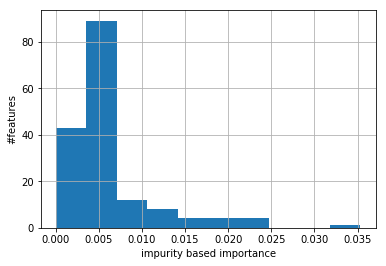

In [29]:
pd.Series(sel.estimator_.feature_importances_.ravel()).hist()
plt.xlabel("impurity based importance")
plt.ylabel("#features")
plt.show()

## PCA (not related to report)

In [93]:
train_meta = one_hot_encoding(select_meta_data_features(train_features), "key")
train_audio = select_audio_features(train_features)

train_continuous_meta_audio = pd.concat([train_meta, train_audio], axis=1)
train_continuous_0_1_meta_audio = transform_continuous_0_1(train_continuous_meta_audio)

valid_continuous_0_1_meta_audio = select_df1_columns_based_on_df2(one_hot_encoding(valid_features, "key"),
                                                                  train_continuous_0_1_meta_audio
                                                                 )

test_continuous_0_1_meta_audio = select_df1_columns_based_on_df2(one_hot_encoding(test_features, "key"),
                                                                  train_continuous_0_1_meta_audio
                                                                 )

In [81]:
pca = PCA(n_components = 0.99)
pca.fit(train_continuous_0_1_meta_audio)
reduced = pca.transform(train_continuous_0_1_meta_audio)
train_meta_audio_pca = pd.DataFrame(reduced, index=train_continuous_0_1_meta_audio.index)

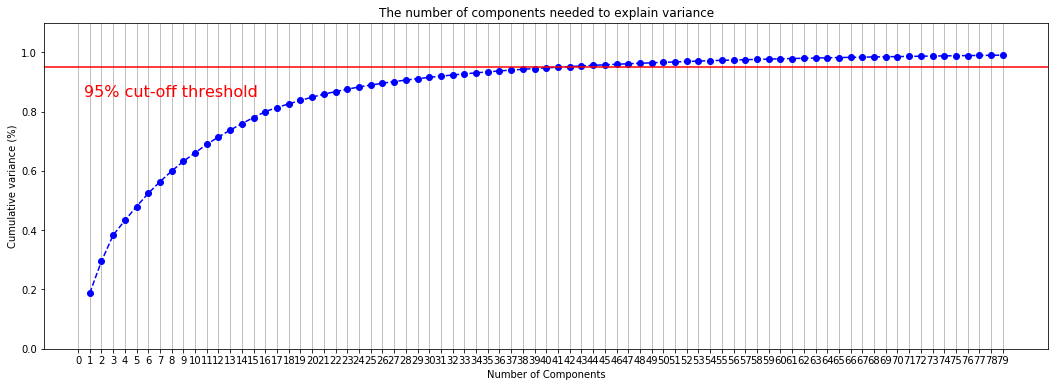

In [88]:
plt.rcParams["figure.figsize"] = (18,6)

fig, ax = plt.subplots()
xi = np.arange(1, 80, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 80, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [95]:
valid_meta_audio_pca = pd.DataFrame(pca.transform(valid_continuous_0_1_meta_audio), 
                                     index=valid_continuous_0_1_meta_audio.index)

test_meta_audio_pca = pd.DataFrame(pca.transform(test_continuous_0_1_meta_audio), 
                                     index=test_continuous_0_1_meta_audio.index)

In [102]:
train_meta_audio_pca_var95 = train_meta_audio_pca[train_meta_audio_pca.columns[0:43]]
valid_meta_audio_pca_var95 = valid_meta_audio_pca[valid_meta_audio_pca.columns[0:43]]
test_meta_audio_pca_var95  = test_meta_audio_pca[test_meta_audio_pca.columns[0:43]]

## feature plot (not related to report)

In [13]:
train_meta = select_meta_data_features(train_features)
train_meta = train_meta.merge(train_labels, left_index=True, right_index=True)

In [36]:
def draw_scatter_group(data: pd.DataFrame):
    for i in range(0, len(data.columns)-1):
        for j in range(i+1, len(data.columns)-1):
            col_i = data.columns[i]
            col_j = data.columns[j]

            groups = data[[col_i, col_j, "genre"]].groupby("genre")
            plt.figure(figsize=(15,8))
            for name, group in groups:
                plt.plot(group[col_i], group[col_j], marker="o", linestyle="", label=name, 
                         alpha=0.50)
            plt.legend()
            plt.xlabel(col_i)
            plt.ylabel(col_j)
            plt.show()

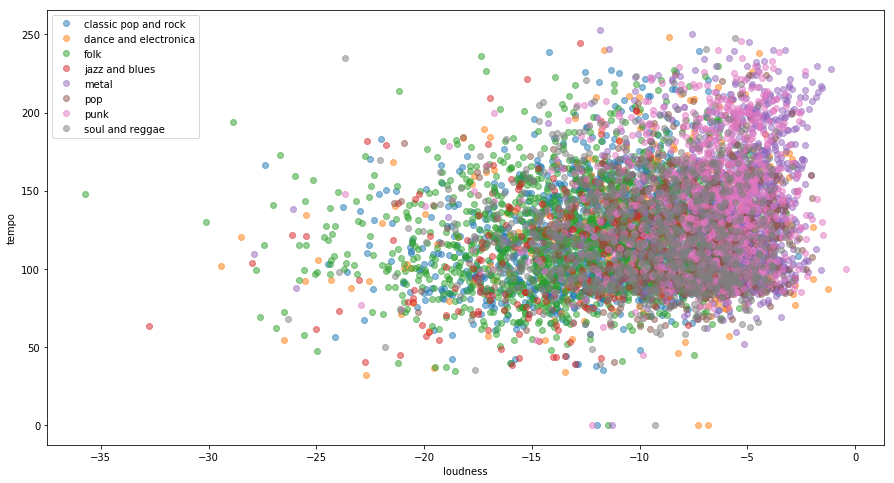

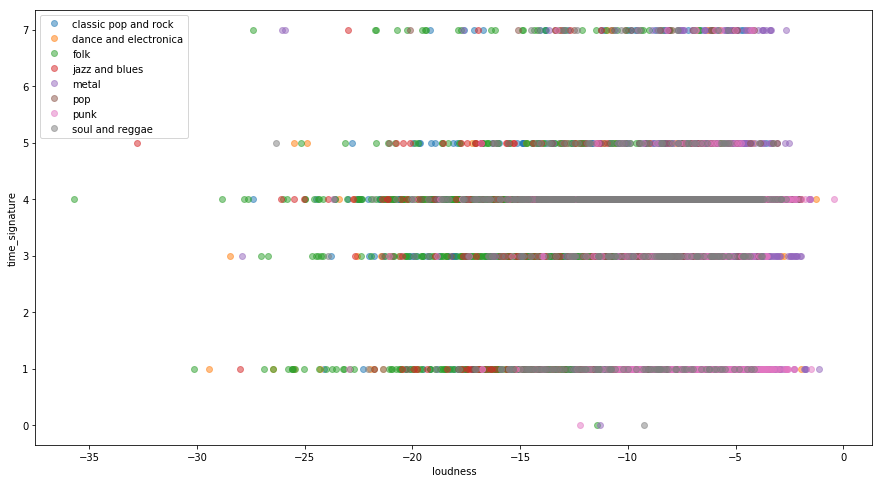

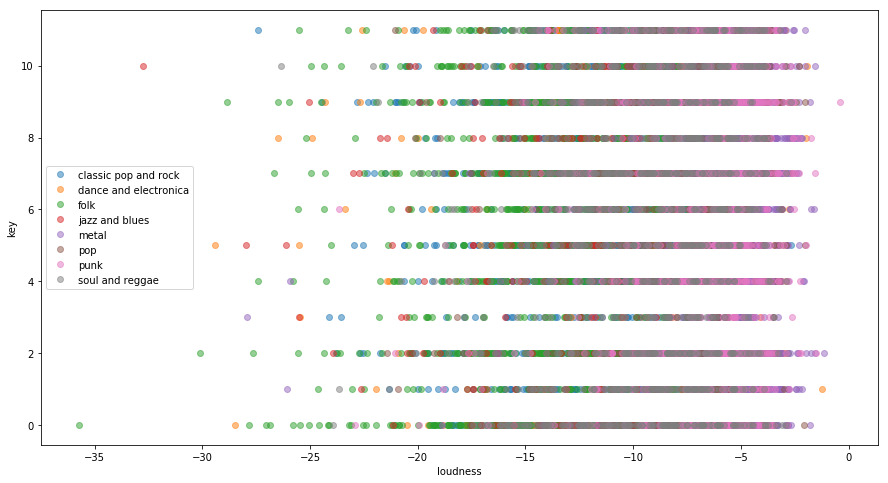

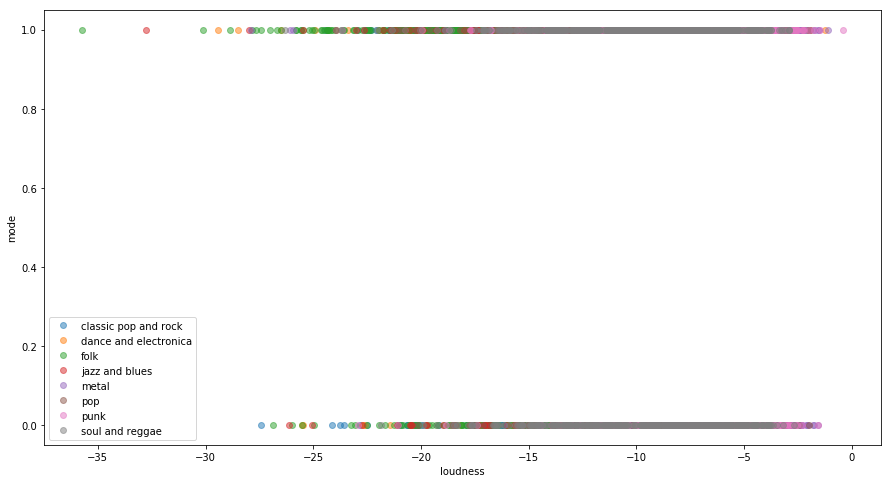

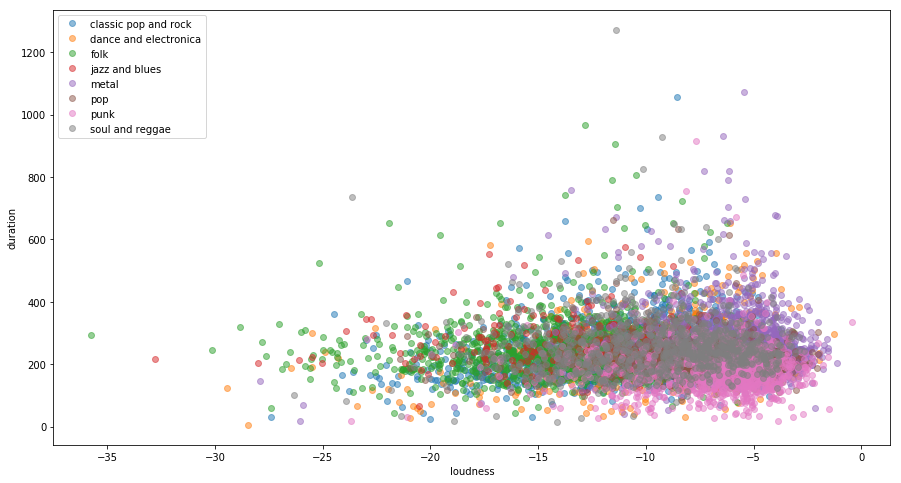

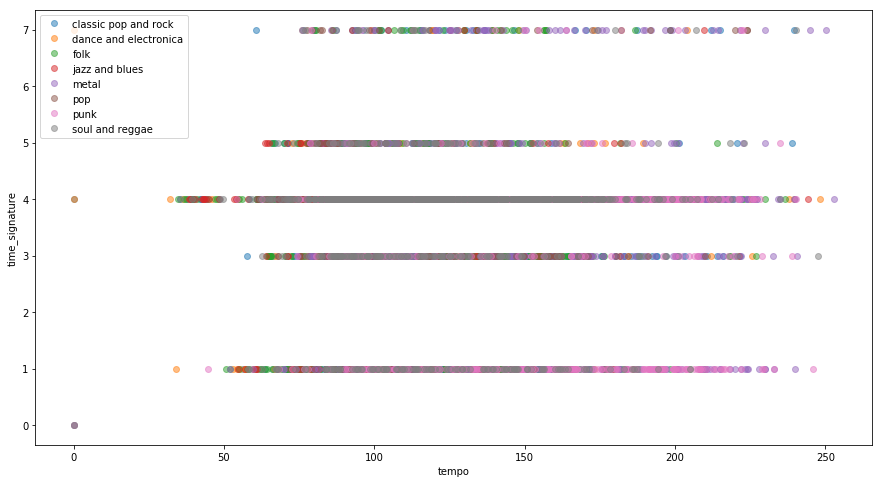

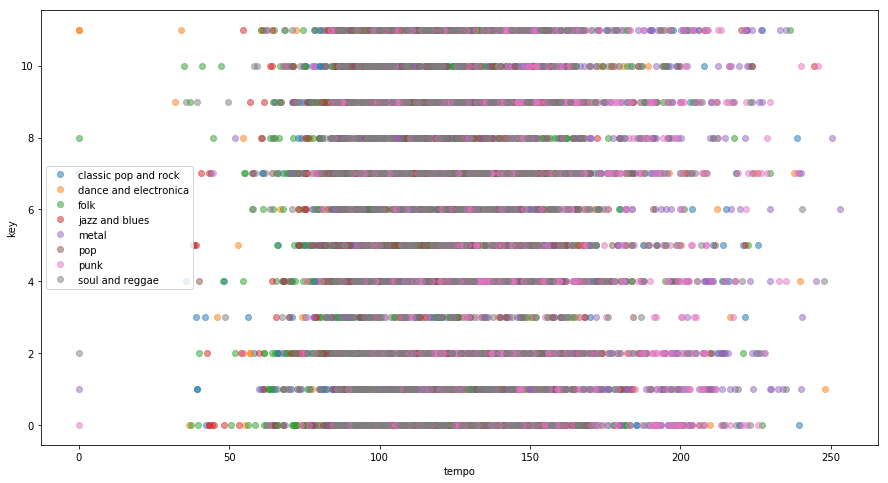

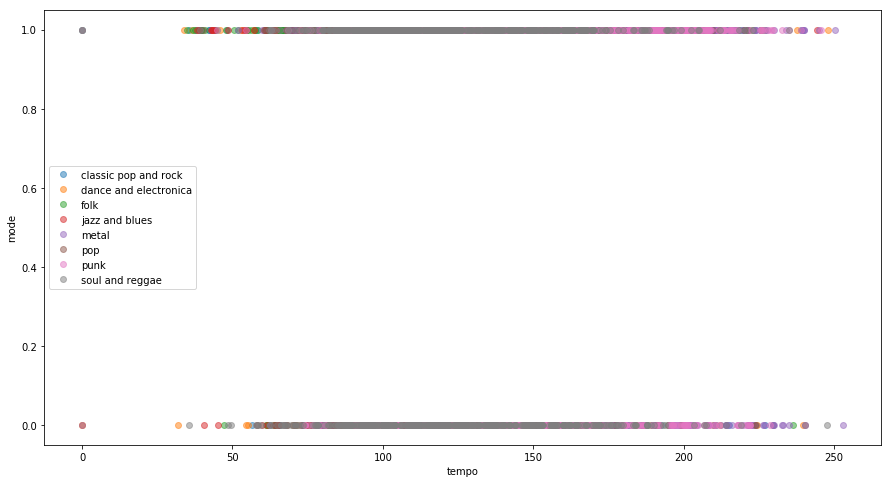

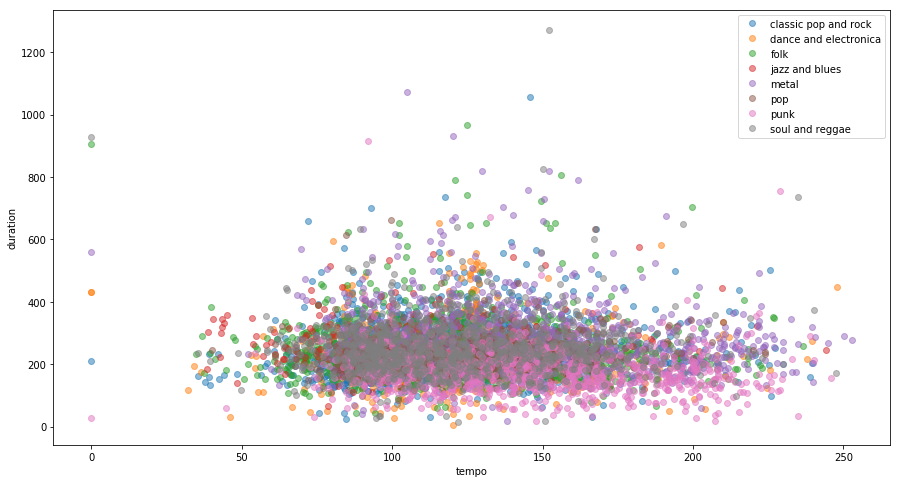

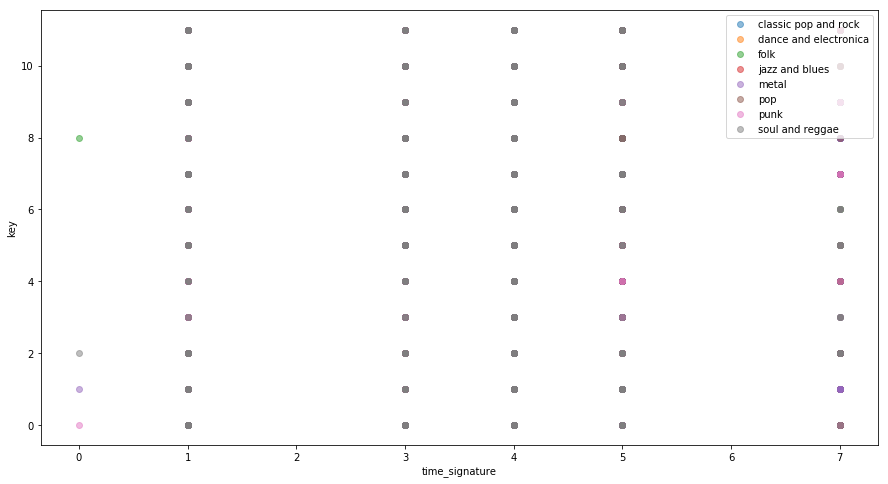

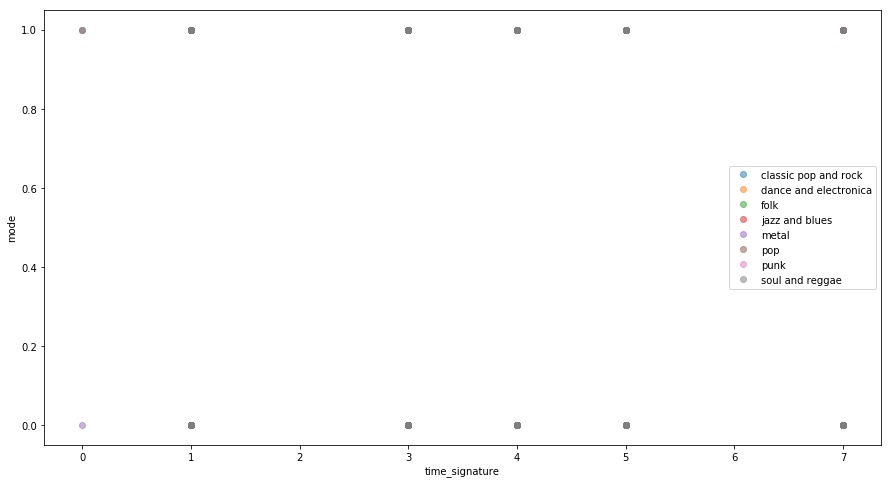

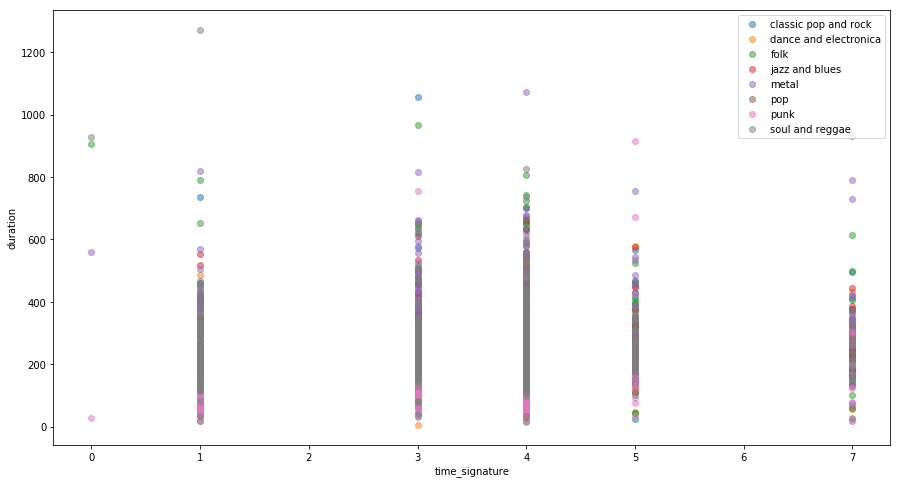

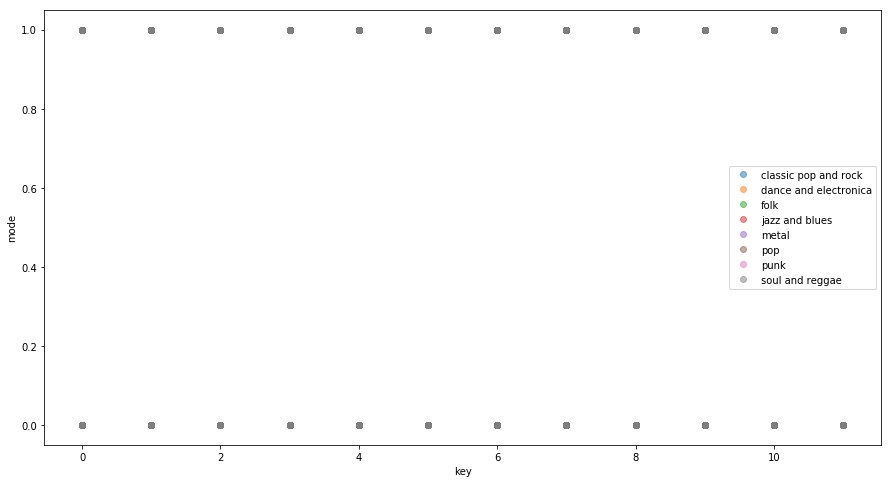

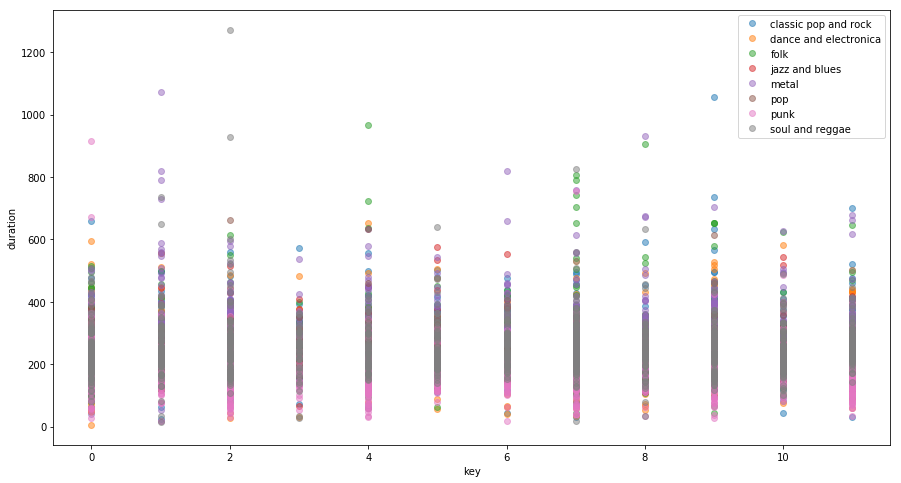

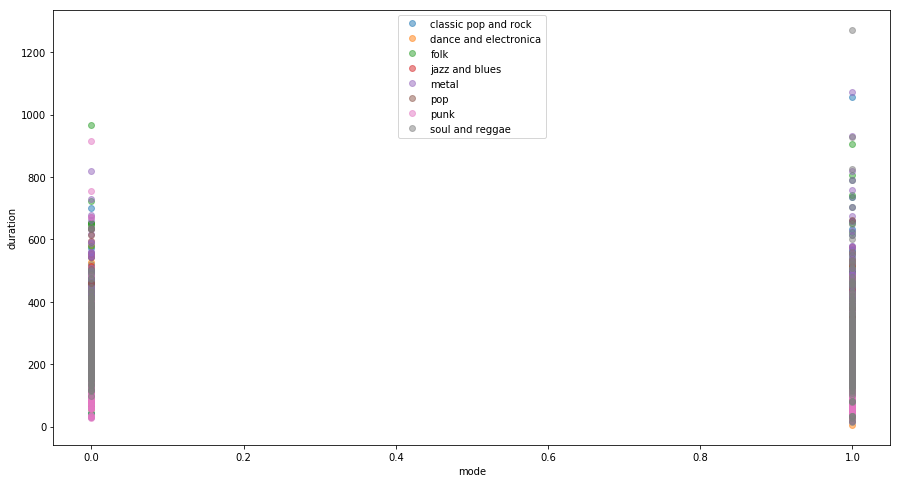

In [37]:
draw_scatter_group(train_meta)

In [15]:
train_audio = select_audio_features(train_features)
train_audio = train_audio.merge(train_labels, left_index=True, right_index=True)

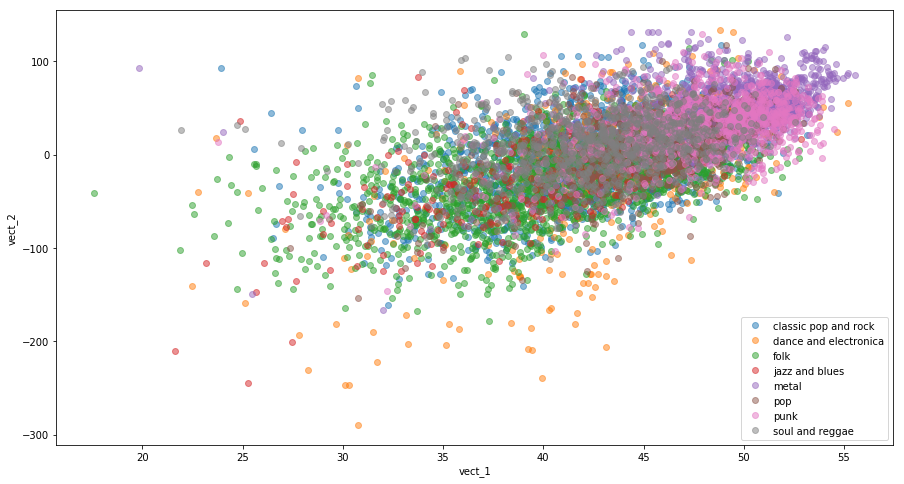

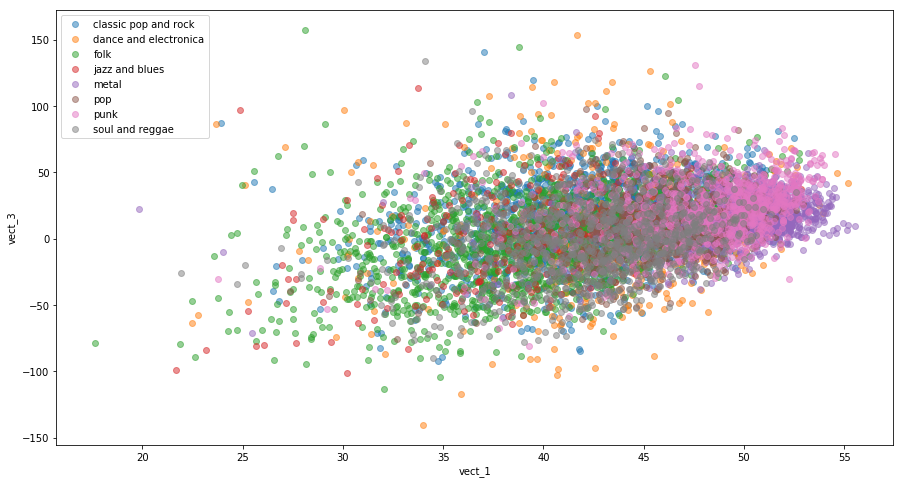

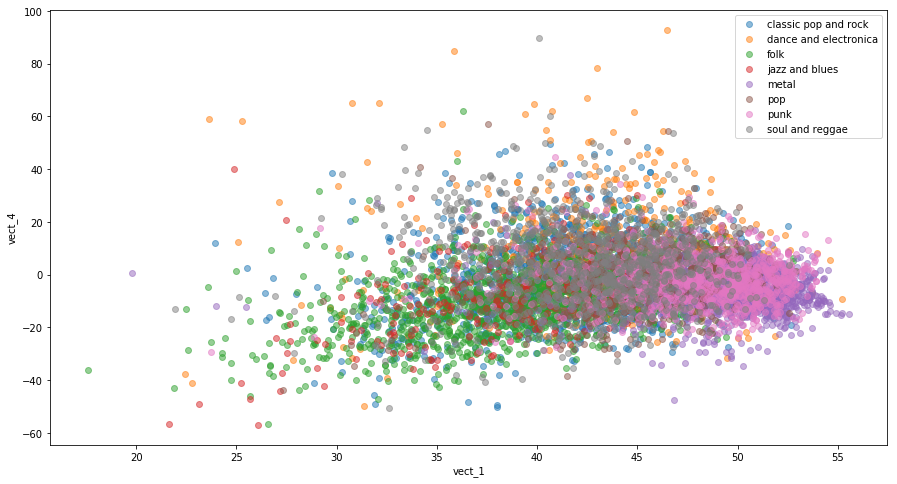

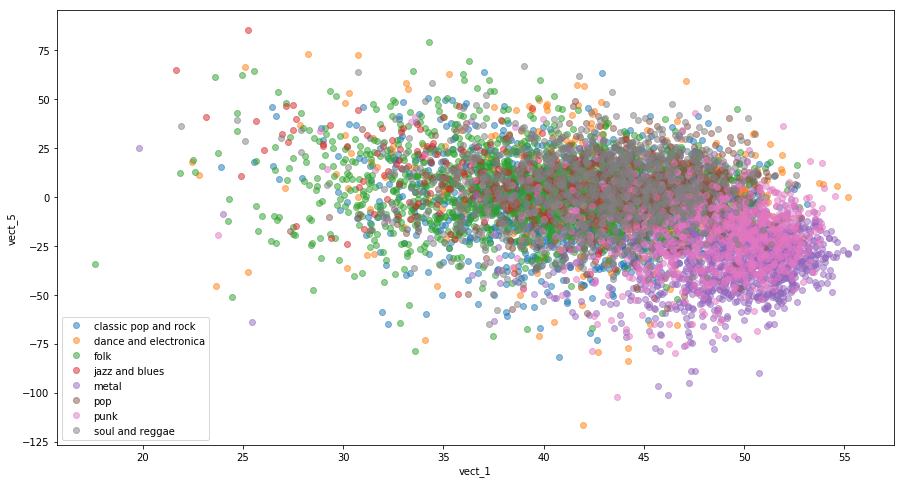

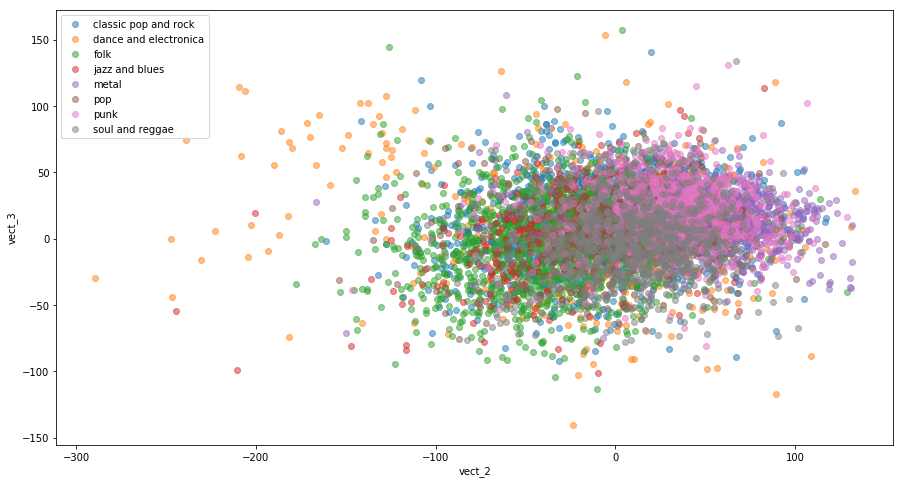

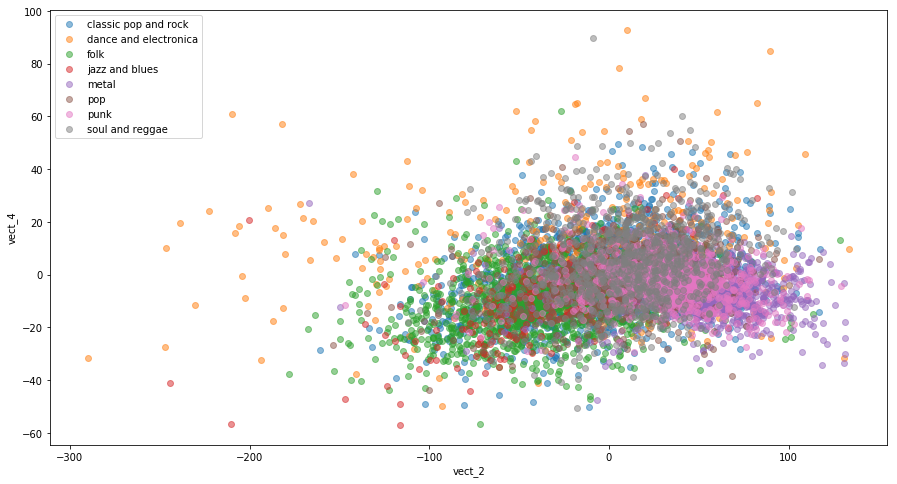

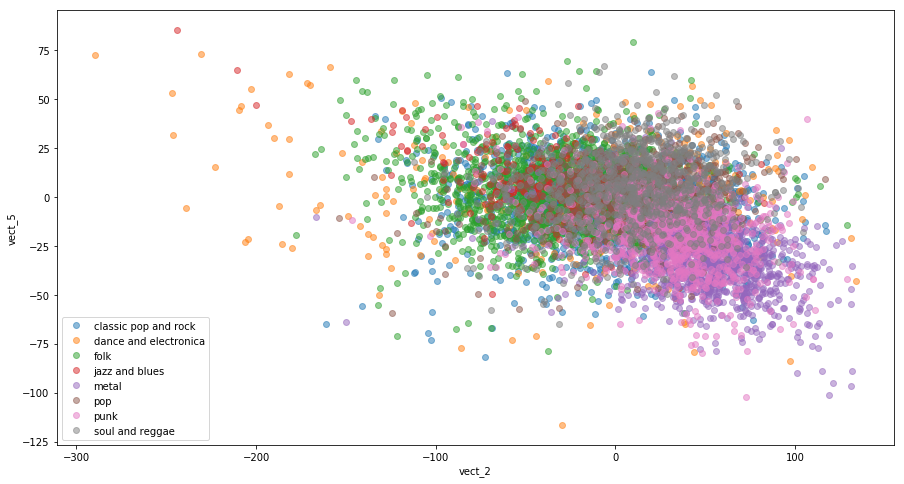

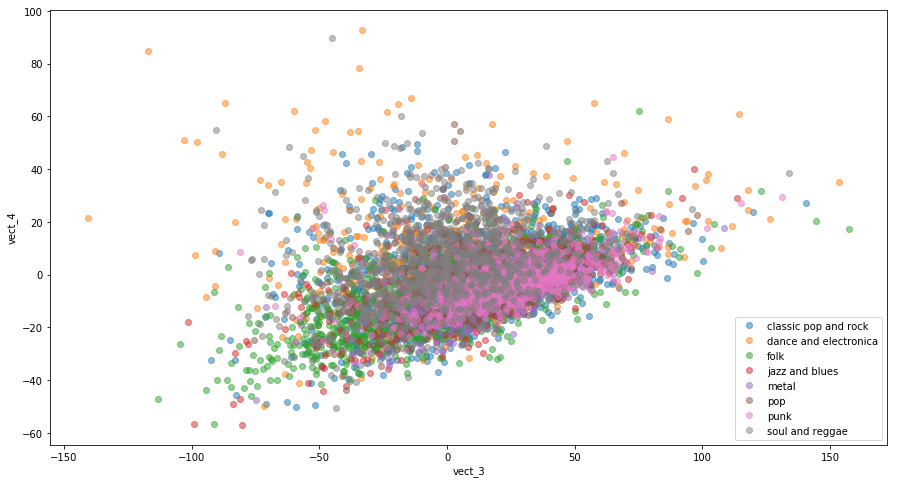

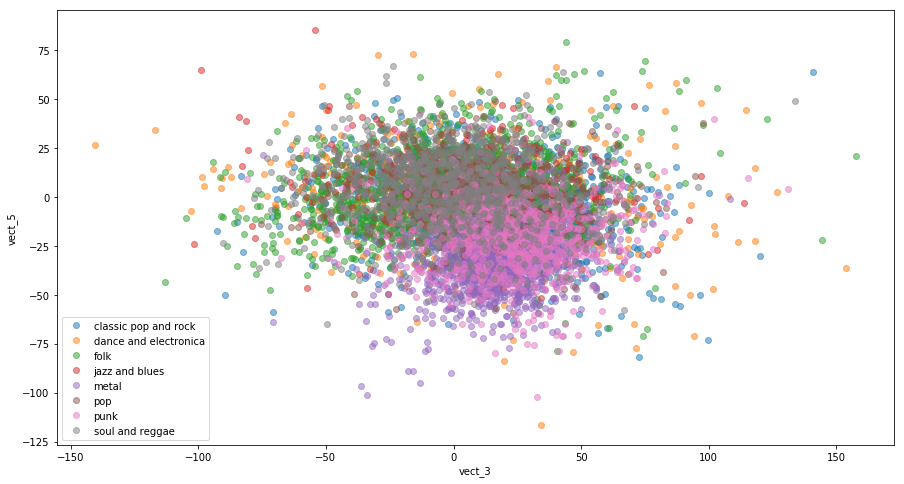

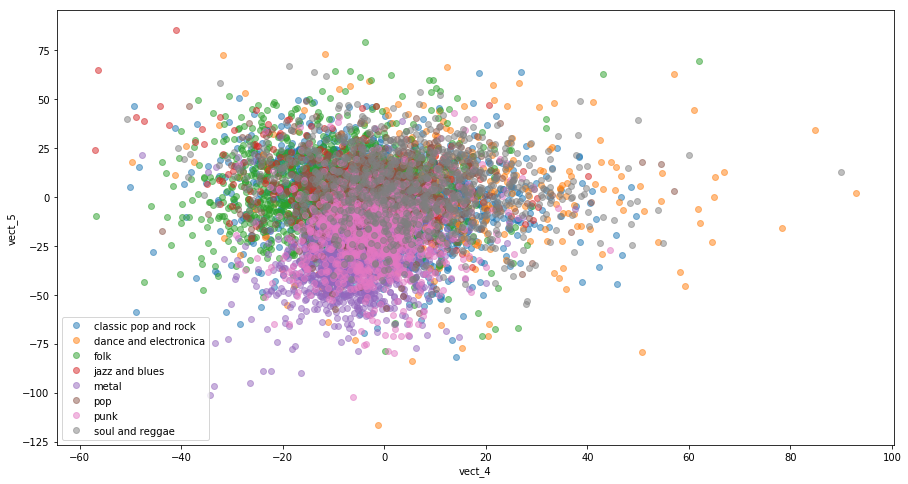

In [38]:
a = list(train_audio.columns[0:5])
a.append("genre")


draw_scatter_group(train_audio[a])

## avg correlated audio vec (not related to report)

In [44]:
def avg_audio_vec(data: pd.DataFrame, threshold=0.3):
    avg_map = {data.columns[0]: [data.columns[0]]}
    data_corr = data.corr()
    
    for i in range(1, len(data.columns)):
        is_avged = False
        for j in range(0, i):
            # avged
            if abs(data_corr[data.columns[i]][data.columns[j]]) >= threshold:
                is_avged = True
                break
        if not is_avged:
            for j in range(i, len(data.columns)):
                if abs(data_corr[data.columns[i]][data.columns[j]]) >= threshold:
                    if data.columns[i] not in avg_map:
                        avg_map[data.columns[i]] = []
                    avg_map[data.columns[i]].append(data.columns[j])
                    
    return avg_map

def avg_by_map(data: pd.DataFrame, avg_map: dict):
    result = pd.DataFrame(index=data.index)
    for k, vs in avg_map.items():
        result[k + "_avg"] = data[vs].mean(axis=1)
    return result

In [45]:
train_audio = select_audio_features(train_features)
audio_avg_map = avg_audio_vec(train_audio)

In [58]:
train_audio_avg = avg_by_map(train_audio, audio_avg_map)

valid_audio = select_audio_features(valid_features)
valid_audio_avg = avg_by_map(valid_audio, audio_avg_map)

### try svc

In [63]:
train_svc = pd.concat([select_meta_data_features(train_features), train_audio_avg], axis=1)
valid_svc = pd.concat([select_meta_data_features(valid_features), valid_audio_avg], axis=1)

svc = make_pipeline(StandardScaler(),
                    SVC(random_state=RANDOM_STATE, 
                        tol=1e-5,
                        max_iter=10000))
svc.fit(train_svc, train_labels.values.ravel())

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(max_iter=10000, random_state=90049, tol=1e-05))])

d:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

      soul and reggae       0.18      0.58      0.28        55
 classic pop and rock       0.50      0.07      0.12        45
                metal       0.26      0.47      0.33        64
                 folk       0.00      0.00      0.00        44
                  pop       0.71      0.64      0.67        66
dance and electronica       0.57      0.05      0.10        74
       jazz and blues       0.37      0.43      0.40        44
                 punk       0.53      0.34      0.42        58

             accuracy                           0.33       450
            macro avg       0.39      0.32      0.29       450
         weighted avg       0.41      0.33      0.30       450



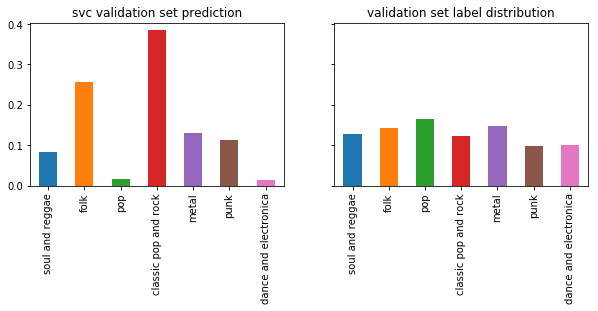

In [66]:
pred = svc.predict(valid_svc)
print(classification_report(valid_labels, pred, target_names=valid_labels["genre"].unique()))
draw_train_valid_label_distribution(pd.DataFrame(pred, columns=valid_labels.columns, index=valid_svc.index), 
                                    valid_labels,
                                    title1="svc validation set prediction")

In [69]:
# rf

models = [svc]

test_audio_avg = avg_by_map(select_audio_features(test_features), audio_avg_map)
test_svc = pd.concat([select_meta_data_features(test_features), test_audio_avg], axis=1)
test_preds = predict(models, test_svc)
test_preds[0].reset_index(level=0).to_csv(path_or_buf="test_pred.csv", columns=["trackID", "genre"], index=False)

## decision tree visualization (not related to report)

                       precision    recall  f1-score   support

      soul and reggae       0.12      0.40      0.18        55
 classic pop and rock       0.20      0.04      0.07        45
                metal       0.23      0.41      0.29        64
                 folk       0.14      0.02      0.04        44
                  pop       0.55      0.44      0.49        66
dance and electronica       0.38      0.04      0.07        74
       jazz and blues       0.30      0.36      0.33        44
                 punk       0.05      0.02      0.03        58

             accuracy                           0.22       450
            macro avg       0.25      0.22      0.19       450
         weighted avg       0.26      0.22      0.19       450



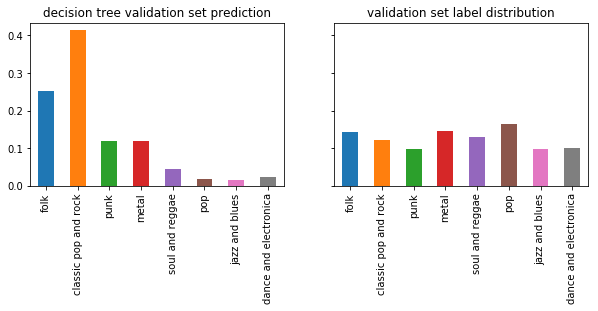

In [19]:
train_dt = select_meta_data_features(train_features)
valid_dt = select_df1_columns_based_on_df2(valid_features, train_dt)

dt = DecisionTreeClassifier(criterion="entropy",
                            random_state=RANDOM_STATE)

dt.set_params(max_depth=9)
dt.fit(train_dt, train_labels.values.ravel())
pred = dt.predict(valid_dt)
print(classification_report(valid_labels, pred, target_names=valid_labels["genre"].unique()))
draw_train_valid_label_distribution(pd.DataFrame(pred, columns=valid_labels.columns, index=valid_dt.index), 
                                    valid_labels,
                                    title1="decision tree validation set prediction")

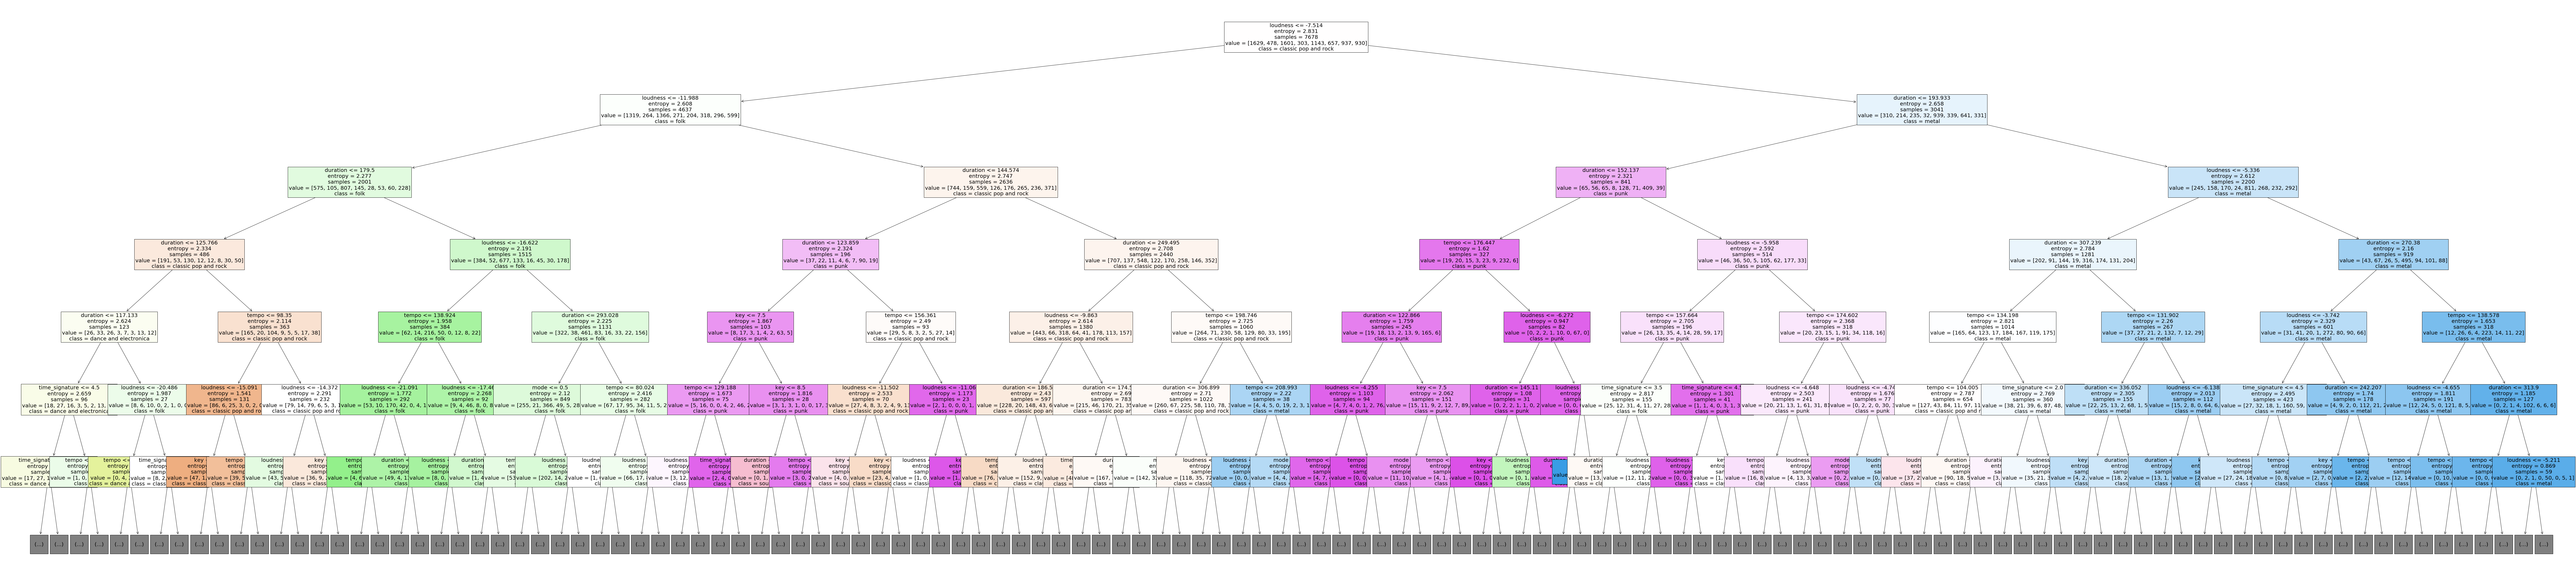

In [29]:
fig = plt.figure(figsize=(170,40))
_ = tree.plot_tree(decision_tree=dt, 
                   feature_names=train_dt.columns,  
                   class_names=np.unique(train_labels),
                   filled=True,
                   max_depth=6,
                  fontsize=20)
plt.savefig('dt_meta.png')

## textual feature

### helper function

In [715]:
# modify from:
# https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/#.X4gxmpMzafU

def clear_punctuations(text):
    for p in string.punctuation:
        text = text.replace(p, '')
    return text

def preprocess_tag(all_tags):
    result = []
    for tag in all_tags:
        tag = clear_punctuations(tag)
        result.append(tag)
    return result

def preprocess_title(all_titles):
    result = []
    for title in all_titles:
        trantab = str.maketrans({key: None for key in string.punctuation})
        title = title.translate(trantab)
        title = re.sub('\d+','',title)
        result.append(title)
    return np.array(result) 

def turn_TFIDF(train_corpus,corpus,note):
    if(note == 'tag'):
        corpus = preprocess_tag(corpus)
        train_corpus = preprocess_tag(train_corpus)
    if(note == 'title'):
        corpus = preprocess_title(corpus)
        train_corpus = preprocess_title(train_corpus)
    vectorizer = TfidfVectorizer(token_pattern=r"(?u)\b\w+\b")
    tfidf = vectorizer.fit(train_corpus)
    vectors = tfidf.transform(corpus)
    return pd.DataFrame(vectors.todense().tolist(), columns = vectorizer.get_feature_names())

### compute

In [716]:
# tag: haven't tfidf
tag_for_train = (train_features.iloc[:,1]).values
tag_for_valid = (valid_features.iloc[:,1]).values
tag_for_test = (test_features.iloc[:,1]).values

# title: haven't tfidf
title_for_train = (train_features.iloc[:,0]).values
title_for_valid = (valid_features.iloc[:,0]).values
title_for_test = (test_features.iloc[:,0]).values

# title: tfidf
train_title = turn_TFIDF(title_for_train,title_for_train,'title').set_index(train_features.index)
valid_title = turn_TFIDF(title_for_train,title_for_valid,'title').set_index(valid_features.index)
test_title = turn_TFIDF(title_for_train,title_for_test,'title').set_index(test_features.index)

# tag: tfidf
train_tag = turn_TFIDF(tag_for_train,tag_for_train,'tag').set_index(train_features.index)
valid_tag = turn_TFIDF(tag_for_train,tag_for_valid,'tag').set_index(valid_features.index)
test_tag = turn_TFIDF(tag_for_train,tag_for_test,'tag').set_index(test_features.index)

# train_tag

In [300]:
train_features_all = pd.concat([train_tag, 
                                select_meta_data_features(train_features), 
                                select_audio_features(train_features)], axis=1)
valid_features_all = pd.concat([valid_tag,
                                select_meta_data_features(valid_features), 
                                select_audio_features(valid_features)], axis=1)
test_features_all = pd.concat([test_tag, 
                               select_meta_data_features(test_features), 
                               select_audio_features(test_features)], axis=1)

### all  (not related to report)

In [20]:
train_all = pd.concat([train_tag, train_title,
                                select_meta_data_features(train_features), 
                                select_audio_features(train_features)], axis=1)
valid_all = pd.concat([valid_tag, valid_title,
                                select_meta_data_features(valid_features), 
                                select_audio_features(valid_features)], axis=1)
test_all = pd.concat([test_tag, test_title,
                               select_meta_data_features(test_features), 
                               select_audio_features(test_features)], axis=1)

### rf select all  (not related to report)

In [74]:
TOP_N_FEATURES = 10

sel = SelectFromModel(RandomForestClassifier(n_estimators = 1000, 
                                             random_state=RANDOM_STATE, 
                                             criterion="entropy",
                                             max_depth=TOP_N_FEATURES))
sel.fit(train_all, train_labels.values.ravel())
sel.get_support()

array([False, False, False, ...,  True,  True,  True])

In [81]:
selected_feat= train_all.columns[(sel.get_support())]
# print(selected_feat.shape)
# print(list(selected_feat))
selected_feat

Index(['a', 'about', 'again', 'ai', 'al', 'all', 'alma', 'alon', 'alright',
       'alway',
       ...
       'vect_139', 'vect_140', 'vect_141', 'vect_142', 'vect_143', 'vect_144',
       'vect_145', 'vect_146', 'vect_147', 'vect_148'],
      dtype='object', length=567)

In [83]:
train_all_rf_selected = train_all[selected_feat]
valid_all_rf_selected = valid_all[selected_feat]
test_all_rf_selected = test_all[selected_feat]

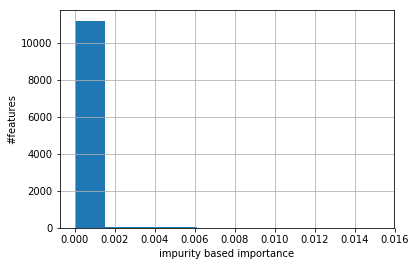

In [84]:
pd.Series(sel.estimator_.feature_importances_.ravel()).hist()
plt.xlabel("impurity based importance")
plt.ylabel("#features")
plt.show()

### drop number tag  (not related to report)

In [36]:
numbered_tag = []

for c in train_tag.columns:
    try:
        int(c)
        numbered_tag.append(c)
    except ValueError:
        pass
    
has_number_tag = []
for c in train_tag.columns:
    if any(map(str.isdigit, c)):
        has_number_tag.append(c)

In [41]:
train_alpha_tags_all = train_tag.drop(has_number_tag, axis=1)
valid_alpha_tags_all = valid_tag.drop(has_number_tag, axis=1)
test_alpha_tags_all = test_tag.drop(has_number_tag, axis=1)

## merge and then preprocess (not related to report)

In [198]:
features_all = pd.concat([train_features, valid_features, test_features], axis=0)
features_all = one_hot_encoding(features_all, "key")
features_all.drop(columns=["title"])

tags  loudness    tempo  \
trackID                                                                         
8424     the, you, to, a, not, in, of, that, are, we, w...    -2.824  131.969   
7923     i, the, you, to, and, a, me, it, not, in, my, ...   -11.249  136.510   
2314     the, to, and, a, in, is, on, all, no, have, bu...    -6.932   72.878   
810      i, the, you, to, and, a, me, it, not, in, my, ...   -12.551   75.381   
439      i, to, and, me, love, but, with, oh, they, she...   -14.566  134.331   
821      i, the, you, to, and, it, not, in, is, your, d...   -12.290  152.981   
1943     i, the, you, to, and, a, me, not, in, my, is, ...   -10.303   89.799   
6667     the, you, to, and, a, in, is, your, that, do, ...   -14.251   81.978   
5893     the, to, and, a, it, not, in, is, of, on, will...    -6.581  142.789   
6414     i, you, to, and, a, me, it, not, in, my, is, o...   -12.712  108.999   
4497     i, the, you, to, and, a, me, it, not, my, is, ...   -10.802  119.985   
7028     i, the, you, a, me, not, your, that, do, on, a...    -6.238  123.786   
4297     the, you, to, and, a, it, in, is, of, are, we,...    -6.849  119.644   
4059     the, you, to, and, a, me, not, in, is, are, we...   -10.752  111.807   
5335     i, the, and, a, in, my, is, of, your, that, do...    -8.896   88.555   
3494     a, no, que, de, la, y, en, el, mi, lo, con, si...    -4.134  132.046   
960      a, me, no, que, de, la, y, en, un, el, tu, se,...    -6.901   67.977   
8111     i, the, you, to, and, a, me, it, in, my, is, o...   -13.443  174.193   
7985     i, the, you, to, and, a, me, not, in, is, of, ...   -14.416  177.477   
5049     i, the, you, to, and, a, me, in, my, of, your,...   -19.789   84.877   
7027     i, the, you, to, and, a, me, it, in, my, of, y...   -10.250  126.210   
4171     a, me, no, que, de, y, un, te, tu, mi, es, yo,...    -2.447  111.873   
2155     i, the, you, and, a, me, it, not, in, is, your...   -12.205  100.206   
4493     i, the, you, to, and, a, me, it, not, in, is, ...    -8.304  128.325   
7560     you, to, and, a, it, not, in, my, of, do, on, ...   -10.915  137.247   
7083     i, the, you, to, and, a, not, in, my, is, of, ...   -11.440   98.011   
3699     i, the, to, and, a, me, it, not, in, my, of, o...    -8.297   91.001   
4102     i, the, you, to, and, a, it, in, my, of, your,...    -6.185  136.733   
6597     i, the, you, to, and, a, not, your, on, all, f...    -6.694  104.889   
3359     i, the, you, to, and, a, me, not, in, my, of, ...   -15.448  130.281   
...                                                    ...       ...      ...   
5266     i, the, you, to, and, a, me, it, not, my, is, ...   -15.201  136.016   
1837     i, the, you, and, a, me, my, is, that, do, are...   -16.729  101.737   
7192     i, the, you, to, and, me, it, not, in, my, is,...   -17.092  141.692   
3122     the, you, to, a, it, not, in, is, do, are, wil...    -5.938  146.558   
5947     i, the, you, to, and, a, me, it, not, in, my, ...    -6.955  119.527   
6301     i, the, you, to, and, me, it, not, in, my, of,...   -17.223   57.553   
6971     i, the, you, to, and, a, me, in, my, that, am,...   -17.979   97.175   
7555     i, the, you, and, a, me, not, in, my, is, of, ...    -9.529  127.102   
1186     i, the, you, to, and, a, me, it, not, in, my, ...   -14.744  183.914   
8532     a, me, no, que, de, y, en, un, el, se, mi, ya,...   -12.027  115.527   
6503     i, the, you, to, and, a, it, not, in, is, of, ...   -12.717   98.998   
1831     a, me, no, que, de, la, y, un, el, te, tu, se,...   -11.140  104.026   
7314     i, the, you, to, and, a, me, it, not, in, my, ...   -11.529   85.107   
5648     a, do, no, que, de, e, o, na, para, em, todo, ...    -5.542  194.862   
4590     i, the, you, to, and, a, me, it, in, my, on, a...   -16.472  106.008   
2490     a, me, for, no, que, e, o, por, amor, como, em...    -7.828  130.045   
2159     i, the, you, to, and, a, me, not, in, my, of, ...    -7.363  137.199   
1475

In [189]:
features_tag = (features_all["tags"]).values
features_tags = computeTFIDF(features_tag,features_tag,'tags').set_index(features_all.index)

In [190]:
features_tags.shape

(8556, 4889)

In [193]:
features_all.drop(columns=["tags", "title"]).columns

Index(['loudness', 'tempo', 'time_signature', 'mode', 'duration', 'vect_1',
       'vect_2', 'vect_3', 'vect_4', 'vect_5',
       ...
       'key_2', 'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9',
       'key_10', 'key_11'],
      dtype='object', length=165)

In [199]:
features_all = pd.concat([features_tags, features_all.drop(columns=["tags", "title"])], axis=1)
features_all.shape

(8556, 5054)

In [206]:
train_features_all2 = features_all.iloc[train_features.index, :]
valid_features_all2 = features_all.iloc[valid_features.index, :]
test_features_all2 = features_all.iloc[test_features.index, :]

# report

## tag, meta, audio or combination, which is good?

In [366]:
train_tag = train_tag.rename(columns={"tempo": "tempo_tag"})
valid_tag = valid_tag.rename(columns={"tempo": "tempo_tag"})
test_tag = test_tag.rename(columns={"tempo": "tempo_tag"})

In [389]:
all_features = pd.concat([train_features, valid_features, test_features], axis=0)
all_features_one_hot = one_hot_encoding(all_features, "key")
all_features_one_hot = all_features_one_hot.drop(columns=['title', 'tags'], axis=1)

# train_tag
train_meta = select_meta_data_features(all_features_one_hot).iloc[train_features.index, :]
train_audio = select_audio_features(all_features_one_hot).iloc[train_features.index, :]

train_all_features = train_tag.join(all_features_one_hot)
valid_all_features = valid_tag.join(all_features_one_hot)
test_all_features = test_tag.join(all_features_one_hot)

In [402]:
clf = GaussianNB()

names = ["tags", "meta", "audio", "tags+meta", "tags+audio", "meta+audio", "tags+meta+audio"]
trains = [train_tag, 
          train_meta,
          train_audio,
          select_df1_columns_based_on_df2(train_all_features, train_tag.join(train_meta)),
          select_df1_columns_based_on_df2(train_all_features, train_tag.join(train_audio)),
          select_df1_columns_based_on_df2(train_all_features, train_meta.join(train_audio)),
          train_all_features
         ]

f1s = []
for t in trains:
    clf.fit(t, train_labels.values.ravel())
    pred = clf.predict(select_df1_columns_based_on_df2(valid_all_features, t))
    _, _, pref = evaluate(pred, valid_labels.values.ravel())
    f1s.append(pref[2])

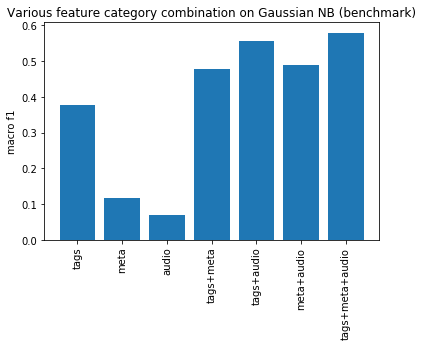

In [411]:
# plt.figure(figsize=[1, 6])
plt.bar(x= names, height=f1s)
plt.xticks(rotation=90)
plt.ylabel("macro f1")
plt.title("Various feature category combination on Gaussian NB (benchmark)")
plt.show()

## hyper-parameter tuning

### knn

In [420]:
scaler = StandardScaler()
scaler.fit(train_all_features)
train_all_features_standard = scaler.transform(train_all_features)
valid_all_features_standard = scaler.transform(valid_all_features)
test_all_features_standard = scaler.transform(test_all_features)

In [428]:
ks = []
f1s = [[], []]

k_max=200

metrics= ['euclidean', 'manhattan']

for k in range(1, k_max):
    models = [KNeighborsClassifier(n_neighbors=k, weights="distance", metric='euclidean'),
              KNeighborsClassifier(n_neighbors=k, weights="distance", metric='manhattan')]
    
    for i, m in enumerate(models):
        scores = cross_val_score(estimator=m, 
                        X=train_all_features_standard, 
                        y=train_labels.values.ravel(), 
                        cv=5,
                        scoring='f1_macro')
        f1s[i].append(np.mean(scores))
        print(k, metrics[i], k_max, np.mean(scores))
    ks.append(k)

# knn_clf = m

# knn_clf.fit(train_all_features, train_labels.values.ravel())

1 euclidean 200 0.2354660438242103
1 manhattan 200 0.22380132378915638
2 euclidean 200 0.2354660438242103
2 manhattan 200 0.22380132378915638
3 euclidean 200 0.23799492843051037
3 manhattan 200 0.19316053244629877
4 euclidean 200 0.23656192136836127
4 manhattan 200 0.2000676359152304
5 euclidean 200 0.23968699800584234
5 manhattan 200 0.18887054617194127
6 euclidean 200 0.24003692444554794
6 manhattan 200 0.18802687000912466
7 euclidean 200 0.23322500577237334
7 manhattan 200 0.17771993434950417
8 euclidean 200 0.22576012235390408
8 manhattan 200 0.17151626887403565
9 euclidean 200 0.2203108442963826
9 manhattan 200 0.16739571613171528
10 euclidean 200 0.21596221268591748
10 manhattan 200 0.16220204703025234
11 euclidean 200 0.2099604940189264
11 manhattan 200 0.16330910667505366
12 euclidean 200 0.20190210188455437
12 manhattan 200 0.1541479681629392
13 euclidean 200 0.19649447234365955
13 manhattan 200 0.15148447532093828
14 euclidean 200 0.1965270368491457
14 manhattan 200 0.1480328

KeyboardInterrupt: 

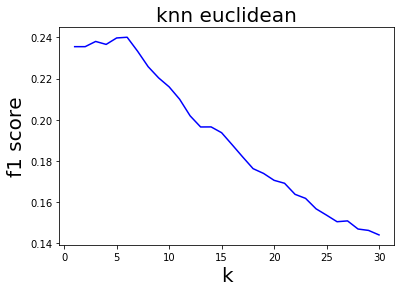

k maximize f1-score : 6 with 0.24003692444554794


In [729]:
draw_k_line_chart(ks[:30], f1s[0][:30], "f1 score", "knn euclidean")
knn_euclidean_k = ks[np.argmax(f1s[0])]
print("k maximize f1-score :", knn_euclidean_k, "with", f1s[0][np.argmax(f1s[0])])

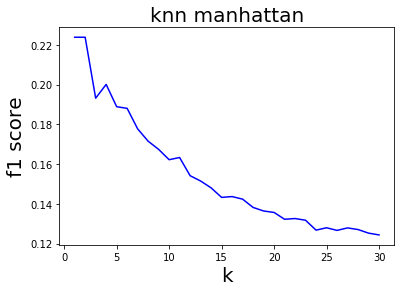

k maximize f1-score : 1 with 0.22380132378915638


In [736]:
draw_k_line_chart(ks[:30], f1s[1][:30], "f1 score", "knn manhattan")
knn_euclidean_k = ks[np.argmax(f1s[1])]
print("k maximize f1-score :", knn_euclidean_k, "with", f1s[1][np.argmax(f1s[1])])

### dt

In [427]:
dt = DecisionTreeClassifier(criterion="entropy",
                            random_state=RANDOM_STATE)

dt_f1s = []
ds = [i for i in range(1, 36)] #len(train_dt.columns))]
for d in ds:
    dt.set_params(max_depth=d)

    scores = cross_val_score(estimator=dt, 
                        X=train_all_features, 
                        y=train_labels.values.ravel(), 
                        cv=5,
                        scoring='f1_macro')
    dt_f1s.append(np.mean(scores))
    
    print(d, np.mean(scores))

1 0.1269870507149139
2 0.2229490179566262
3 0.3280593258149846
4 0.3590542157636648
5 0.3810138740096459
6 0.41637049678555094
7 0.4267722975536536
8 0.43794641976077886
9 0.44689071072966496
10 0.4410342181234845
11 0.435978466142749
12 0.43382174624985315
13 0.4330280577491223
14 0.43441565318286424
15 0.4305731359445873
16 0.4266265562259254
17 0.4282033925957279
18 0.4224738098974131
19 0.4240862809134839
20 0.42522123095633557
21 0.4241165113840538
22 0.42607496947592727
23 0.42657997433145756
24 0.4243978924676341
25 0.4243978924676341
26 0.4243978924676341
27 0.4243978924676341
28 0.4243978924676341
29 0.4243978924676341
30 0.4243978924676341
31 0.4243978924676341
32 0.4243978924676341
33 0.4243978924676341
34 0.4243978924676341
35 0.4243978924676341


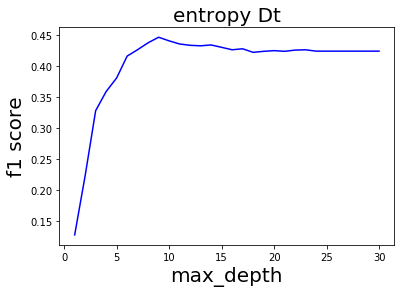

max_depth maximize f1-score : 9 with 0.44689071072966496


In [730]:
draw_k_line_chart(ds[:30], dt_f1s[:30], "f1 score", "entropy Dt", xlabel="max_depth")
best_md = ds[np.argmax(dt_f1s)]
print("max_depth maximize f1-score :", best_md, "with", dt_f1s[np.argmax(dt_f1s)])

### rf

In [ ]:
rf = RandomForestClassifier(n_estimators = 2000, 
                         random_state=RANDOM_STATE, 
                         criterion="entropy",
                         max_depth=9)
rf_ns = [10, 100, 300, 500, 700, 1000, 1500]
rf_f1s = []

In [441]:
for ns in rf_ns:
    rf.set_params(n_estimators = ns)
    
    scores = cross_val_score(estimator=rf, 
                        X=train_all_features, 
                        y=train_labels.values.ravel(), 
                        cv=5,
                        scoring='f1_macro')
    rf_f1s.append(np.mean(scores))
    
    print(ns, np.mean(scores))

10 0.4336184980646694
100 0.4707763296717129
300 0.47797978092820725
500 0.4763764517524186
700 0.47728313435327285
1000 0.4779121358327143
1500 0.4767749808194763


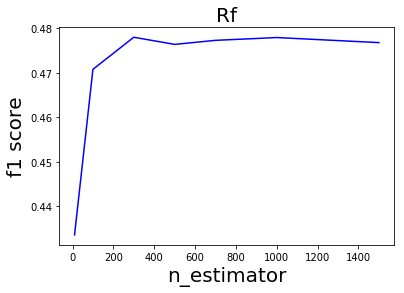

n_estimator maximize f1-score : 300 with 0.47797978092820725


In [731]:
draw_k_line_chart(rf_ns, rf_f1s, "f1 score", "Rf", xlabel="n_estimator")
best_rf_ns = rf_ns[np.argmax(rf_f1s)]
print("n_estimator maximize f1-score :", best_rf_ns, "with", rf_f1s[np.argmax(rf_f1s)])

### mlp

In [733]:
mlp = MLPClassifier(random_state=RANDOM_STATE, 
                                  max_iter=300,
                                  hidden_layer_sizes=100,
                                  activation='relu',
                                  solver='adam'
                                 )

hl_sizes = [(100), (100,100), (100,100,100), (100,100,100,100)]
xs = [i for i in range(1, len(hl_sizes)+1)]

mlp_f1s = []

In [734]:
for hl in hl_sizes:
    mlp.set_params(hidden_layer_sizes = hl)
    
    scores = cross_val_score(estimator=mlp, 
                        X=train_all_features_standard, 
                        y=train_labels.values.ravel(), 
                        cv=5,
                        scoring='f1_macro')
    mlp_f1s.append(np.mean(scores))
    
    print(hl, np.mean(scores))

100 0.5429877857042245
(100, 100) 0.5296416110685624
(100, 100, 100) 0.5366939574889715
(100, 100, 100, 100) 0.5378410781524601


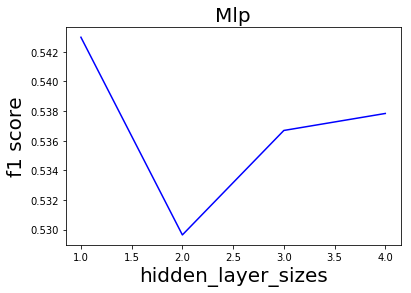

hidden_layer_size maximize f1-score : 100 with 0.5429877857042245


In [735]:
draw_k_line_chart(xs, mlp_f1s, "f1 score", "Mlp", xlabel="hidden_layer_sizes")
best_hl_ns = xs[np.argmax(mlp_f1s)] - 1
print("hidden_layer_size maximize f1-score :", str(hl_sizes[best_hl_ns]), "with", mlp_f1s[np.argmax(mlp_f1s)])

## model comparision

### compare

#### continous

In [699]:
models = [
    DummyClassifier(strategy="most_frequent"),
    GaussianNB(),
    make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=6, weights="distance", metric='euclidean')),
    DecisionTreeClassifier(criterion="entropy", max_depth=9, random_state=RANDOM_STATE),
    RandomForestClassifier(n_estimators = 300, 
                         random_state=RANDOM_STATE, 
                         criterion="entropy",
                         max_depth=9),
    make_pipeline(StandardScaler(), 
                 MLPClassifier(random_state=RANDOM_STATE, 
                                  max_iter=300,
                                  hidden_layer_sizes=100,
                                  activation='relu',
                                  solver='adam'
                                 )
                )
]

In [700]:
model_names = [
    "Zero-R",
    "Gaussian NB",
    "Knn",
    "Decision tree",
    "Random forest",
    "Multi-layer perceptron",
]

In [701]:
models = train(models, train_all_features, train_labels)

In [702]:
preds = predict(models, valid_all_features)

In [703]:
m_f1s = []
m_acc = []

for p in preds:
    _, acc, pref = evaluate(p, valid_labels.values.ravel())
    m_acc.append(acc)
    m_f1s.append(pref[2])
    

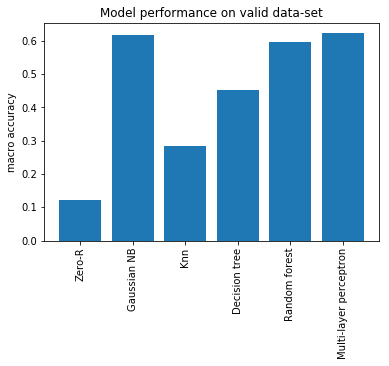

[('Zero-R', 0.12222222222222222),
 ('Gaussian NB', 0.6177777777777778),
 ('Knn', 0.28444444444444444),
 ('Decision tree', 0.4533333333333333),
 ('Random forest', 0.5977777777777777),
 ('Multi-layer perceptron', 0.6222222222222222)]


In [704]:
plt.bar(x=model_names, height=m_acc)
plt.ylabel("macro accuracy")
plt.xticks(rotation=90)
plt.title("Model performance on valid data-set")
plt.show()
pprint(list(zip(model_names, m_acc)))

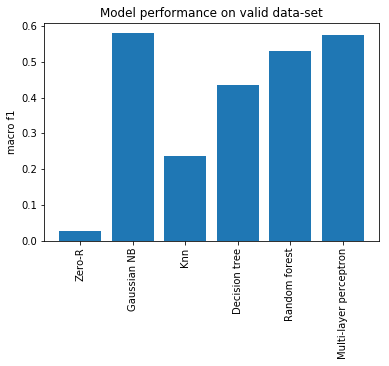

[('Zero-R', 0.027227722772277228),
 ('Gaussian NB', 0.5791759087379859),
 ('Knn', 0.23582657635076987),
 ('Decision tree', 0.4351733143531153),
 ('Random forest', 0.5295263553144117),
 ('Multi-layer perceptron', 0.5754623232960369)]


In [705]:
plt.bar(x=model_names, height=m_f1s)
plt.ylabel("macro f1")
plt.xticks(rotation=90)
plt.title("Model performance on valid data-set")
plt.show()
pprint(list(zip(model_names, m_f1s)))

#### discrete

In [637]:
models = [
    DummyClassifier(strategy="most_frequent"),
    make_pipeline(KBinsDiscretizer(n_bins=10,
                                   encode='ordinal',
                                   strategy='quantile'
                                  ), 
                  MultinomialNB(alpha=1.0)),
    make_pipeline(KBinsDiscretizer(n_bins=10,
                                   encode='ordinal',
                                   strategy='quantile'
                                  ), 
                  CategoricalNB(alpha=1.0))
]

In [638]:
model_names = [
    "Zero-R",
    "Multinominal NB",
    "Categorical NB",
]

In [639]:
models = train(models, train_all_features, train_labels)

In [640]:
preds = predict(models, valid_all_features)

In [641]:
m_f1s = []
m_acc = []

for p in preds:
    _, acc, pref = evaluate(p, valid_labels.values.ravel())
    m_acc.append(acc)
    m_f1s.append(pref[2])

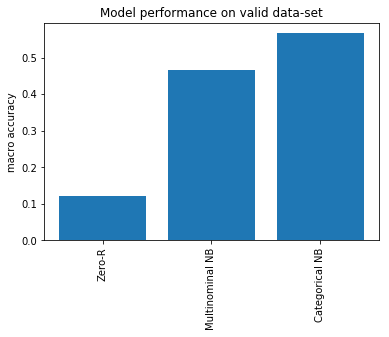

[('Zero-R', 0.12222222222222222),
 ('Multinominal NB', 0.4666666666666667),
 ('Categorical NB', 0.5666666666666667)]


In [642]:
plt.bar(x=model_names, height=m_acc)
plt.ylabel("macro accuracy")
plt.xticks(rotation=90)
plt.title("Model performance on valid data-set")
plt.show()
pprint(list(zip(model_names, m_acc)))

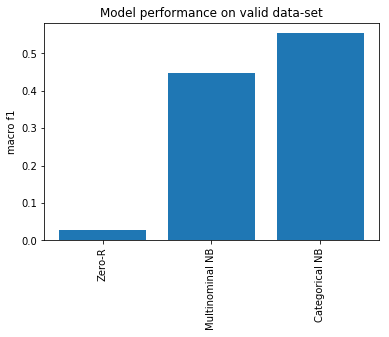

[('Zero-R', 0.027227722772277228),
 ('Multinominal NB', 0.44658737205993293),
 ('Categorical NB', 0.5535938550720744)]


In [643]:
plt.bar(x=model_names, height=m_f1s)
plt.ylabel("macro f1")
plt.xticks(rotation=90)
plt.title("Model performance on valid data-set")
plt.show()
pprint(list(zip(model_names, m_f1s)))

In [646]:
test_preds = predict([models[2]], test_all_features)
test_preds[0].reset_index(level=0).to_csv(path_or_buf="test_pred.csv", columns=["trackID", "genre"], index=False)

### inspect knn

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

 classic pop and rock       0.20      0.84      0.32        55
dance and electronica       0.15      0.29      0.20        45
                 folk       0.30      0.20      0.24        64
       jazz and blues       0.00      0.00      0.00        44
                metal       0.00      0.00      0.00        66
                  pop       0.72      0.49      0.58        74
                 punk       0.33      0.14      0.19        44
      soul and reggae       0.64      0.24      0.35        58

             accuracy                           0.28       450
            macro avg       0.29      0.27      0.24       450
         weighted avg       0.31      0.28      0.25       450



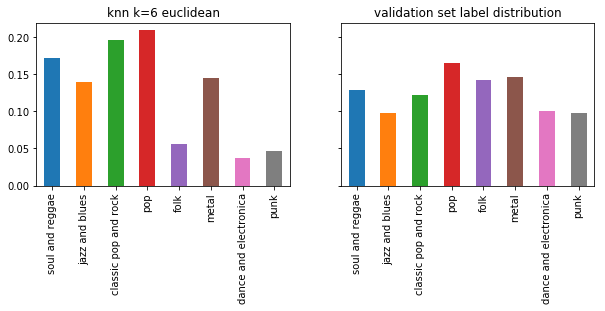

In [479]:
print(classification_report(valid_labels, preds[2], target_names=models[2].classes_))
draw_train_valid_label_distribution(pd.DataFrame(pred, columns=valid_labels.columns, index=valid_all_features.index), 
                                    valid_labels,
                                    title1="knn k=6 euclidean")

In [482]:
cm, _, _ = evaluate(preds[2], valid_labels.values.ravel())

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5,1,'knn confusion matrix')

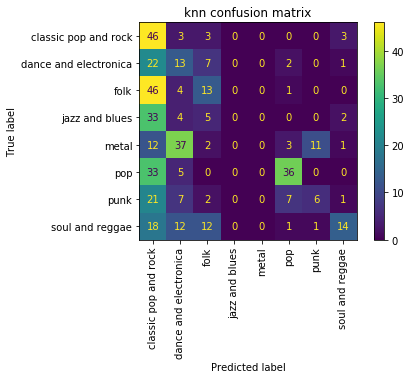

In [487]:
plot_confusion_matrix(models[2], 
                      valid_all_features, 
                      valid_labels.values.ravel(),
                      xticks_rotation='vertical'
                     )
plt.title("knn confusion matrix")

In [493]:
# train_features.loc[train_labels[train_labels["genre"] == "classic pop and rock"].index]

In [517]:
train_all_features_standard_df = pd.DataFrame(train_all_features_standard, 
                                              index=train_all_features.index,
                                              columns=train_all_features.columns
                                             )
valid_all_features_standard_df = pd.DataFrame(valid_all_features_standard, 
                                              index=valid_all_features.index,
                                              columns=valid_all_features.columns
                                             )

In [525]:
import warnings
warnings.filterwarnings('ignore')

res = pd.DataFrame(columns=["valid title", "valid genre", "predict genre", "closest id", "closest genre", "distance"],
                   index=valid_labels.index
                  )

tmp = 0

for ind in valid_all_features.index:
    res.at[ind, "valid title"] = valid_features.loc[ind, "title"]
    res.at[ind, "valid genre"] = valid_labels.loc[ind, "genre"]
    res.at[ind, "predict genre"] = preds[2].loc[ind, "genre"]
    
    distance, train_id = float("inf"), None
    
    for i in train_all_features_standard_df.index:
        d = euclidean_distances(train_all_features_standard_df.loc[i, :].reshape(1, -1), 
                                valid_all_features_standard_df.loc[ind, :].reshape(1, -1))
        if d < distance:
            distance, train_id = d, i
        
        if d <= 0:
            break
    res.at[ind, "closest id"] = train_id
    res.at[ind, "closest genre"] = train_labels.loc[train_id, "genre"]
    res.at[ind, "distance"] = distance
    
    print(tmp, valid_labels.shape[0])
    tmp += 1

0 450
1 450
2 450
3 450
4 450
5 450
6 450
7 450
8 450
9 450
10 450
11 450
12 450
13 450
14 450
15 450
16 450
17 450
18 450
19 450
20 450
21 450
22 450
23 450
24 450
25 450
26 450
27 450
28 450
29 450
30 450
31 450
32 450
33 450
34 450
35 450
36 450
37 450
38 450
39 450
40 450
41 450
42 450
43 450
44 450
45 450
46 450
47 450
48 450
49 450
50 450
51 450
52 450
53 450
54 450
55 450
56 450
57 450
58 450
59 450
60 450
61 450
62 450
63 450
64 450
65 450
66 450
67 450
68 450
69 450
70 450
71 450
72 450
73 450
74 450
75 450
76 450
77 450
78 450
79 450
80 450
81 450
82 450
83 450
84 450
85 450
86 450
87 450
88 450
89 450
90 450
91 450
92 450
93 450
94 450
95 450
96 450
97 450
98 450
99 450
100 450
101 450
102 450
103 450
104 450
105 450
106 450
107 450
108 450
109 450
110 450
111 450
112 450
113 450
114 450
115 450
116 450
117 450
118 450
119 450
120 450
121 450
122 450
123 450
124 450
125 450
126 450
127 450
128 450
129 450
130 450
131 450
132 450
133 450
134 450
135 450
136 450
137 450
138 45

In [543]:
missed = res[res["valid genre"] != res["predict genre"]]
missed[missed["predict genre"] == "classic pop and rock"]["closest genre"].value_counts()

classic pop and rock     107
dance and electronica     32
pop                       18
folk                      14
soul and reggae            8
punk                       4
jazz and blues             1
metal                      1
Name: closest genre, dtype: int64

### inspect Gnb

#### correlation

In [602]:
correlation = train_all_features.iloc[:, -200:].corr()

In [605]:
high_corr = []

for i in correlation.index:
    for j in correlation.index:
        if i != j:
            if correlation.loc[i, j] >= 0.7:
                high_corr.append((i, j))
high_corr

[('zijn', 'zo'),
 ('zo', 'zijn'),
 ('loudness', 'vect_1'),
 ('loudness', 'vect_29'),
 ('loudness', 'vect_42'),
 ('loudness', 'vect_43'),
 ('loudness', 'vect_44'),
 ('loudness', 'vect_45'),
 ('loudness', 'vect_46'),
 ('loudness', 'vect_47'),
 ('loudness', 'vect_48'),
 ('loudness', 'vect_49'),
 ('loudness', 'vect_53'),
 ('vect_1', 'loudness'),
 ('vect_1', 'vect_29'),
 ('vect_2', 'vect_25'),
 ('vect_6', 'vect_18'),
 ('vect_6', 'vect_23'),
 ('vect_16', 'vect_18'),
 ('vect_16', 'vect_20'),
 ('vect_16', 'vect_22'),
 ('vect_16', 'vect_23'),
 ('vect_18', 'vect_6'),
 ('vect_18', 'vect_16'),
 ('vect_18', 'vect_20'),
 ('vect_18', 'vect_22'),
 ('vect_18', 'vect_23'),
 ('vect_19', 'vect_24'),
 ('vect_20', 'vect_16'),
 ('vect_20', 'vect_18'),
 ('vect_20', 'vect_22'),
 ('vect_20', 'vect_23'),
 ('vect_20', 'vect_61'),
 ('vect_22', 'vect_16'),
 ('vect_22', 'vect_18'),
 ('vect_22', 'vect_20'),
 ('vect_22', 'vect_23'),
 ('vect_22', 'vect_61'),
 ('vect_22', 'vect_123'),
 ('vect_23', 'vect_6'),
 ('vect_23'

In [607]:
correlation.loc['loudness', ['vect_1', 'vect_29']]

vect_1     0.945383
vect_29    0.770170
Name: loudness, dtype: float64

#### inspect

                       precision    recall  f1-score   support

 classic pop and rock       0.28      0.45      0.35        55
dance and electronica       0.65      0.24      0.35        45
                 folk       0.64      0.25      0.36        64
       jazz and blues       0.44      0.64      0.52        44
                metal       0.85      0.83      0.84        66
                  pop       0.79      1.00      0.88        74
                 punk       0.90      0.43      0.58        44
      soul and reggae       0.65      0.86      0.74        58

             accuracy                           0.62       450
            macro avg       0.65      0.59      0.58       450
         weighted avg       0.66      0.62      0.60       450



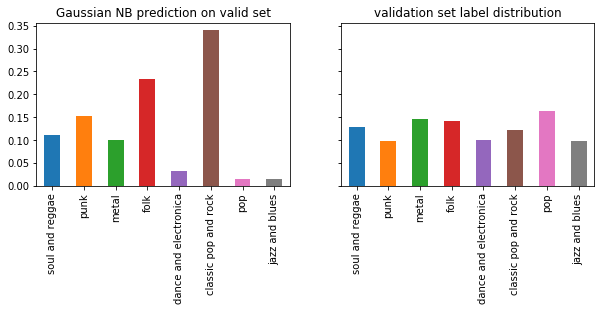

In [707]:
print(classification_report(valid_labels, preds[1], target_names=models[1].classes_))
draw_train_valid_label_distribution(pd.DataFrame(pred, columns=valid_labels.columns, index=valid_all_features.index), 
                                    valid_labels,
                                    title1="Gaussian NB prediction on valid set")

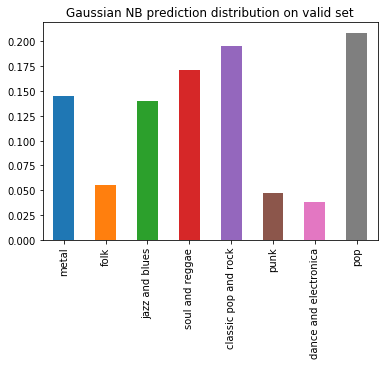

In [621]:
xs = ["metal", "folk", "jazz and blues", "soul and reggae",
      "classic pop and rock", "punk", "dance and electronica", "pop"]

(preds[1]["genre"].value_counts() / sum(valid_labels["genre"].value_counts()))[xs].plot(
    kind='bar')
plt.title('Gaussian NB prediction distribution on valid set')
plt.show()

Text(0.5,1,'Gnb confusion matrix')

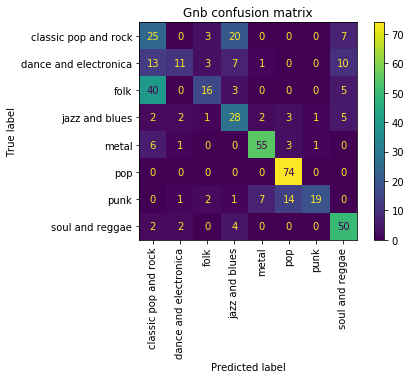

In [706]:
plot_confusion_matrix(models[1], 
                      valid_all_features, 
                      valid_labels.values.ravel(),
                      xticks_rotation='vertical'
                     )
plt.title("Gnb confusion matrix")

## error analysis

In [547]:
train_sizes_all = []
train_scores_all = []
test_scores_all = []
fit_times_all = []

for i, m in enumerate(models[1:]): # skip 0-R
    train_sizes, train_scores, test_scores, fit_times, _ = \
            learning_curve(m, 
                           train_all_features, 
                           train_labels.values.ravel(), 
                           cv=5, 
                           shuffle=True,
                           random_state=RANDOM_STATE,
                           return_times=True
                          )
    train_sizes_all.append(train_sizes)
    train_scores_all.append(train_scores)
    test_scores_all.append(test_scores)
    fit_times_all.append(fit_times)
    
    print(i, model_names[i+1], len(models))

0 Gaussian NB 6
1 Knn 6
2 Decision tree 6
3 Random forest 6
4 Multi-layer perceptron 6


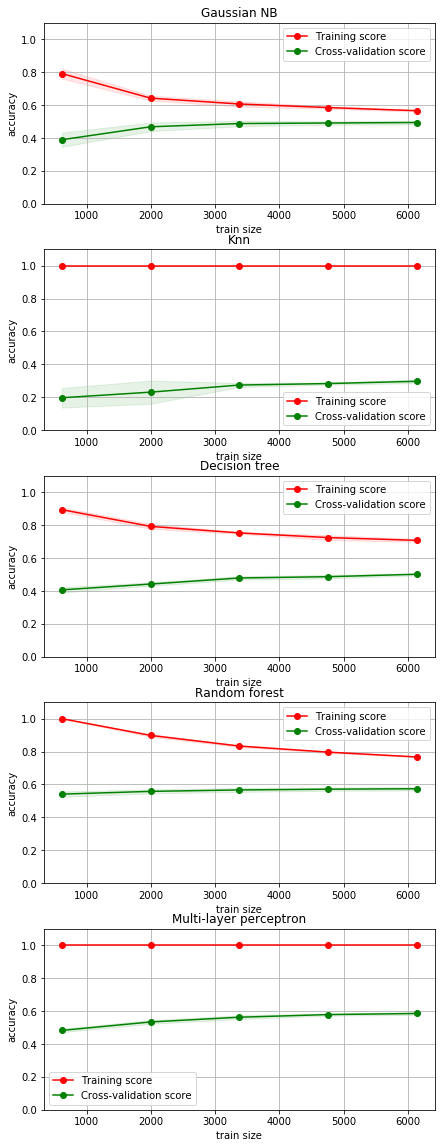

In [580]:
_, axes = plt.subplots(5, 1, figsize=(7, 20))
plt.subplots_adjust(hspace=0.25)

for i in range(1, len(models)):
#     print(model_names[i])
    train_scores_mean = np.mean(train_scores_all[i-1], axis=1)
    train_scores_std = np.std(train_scores_all[i-1], axis=1)
    test_scores_mean = np.mean(test_scores_all[i-1], axis=1)
    test_scores_std = np.std(test_scores_all[i-1], axis=1)
    fit_times_mean = np.mean(fit_times_all[i-1], axis=1)
    fit_times_std = np.std(fit_times_all[i-1], axis=1)

    axes[i-1].grid()
    axes[i-1].fill_between(train_sizes_all[i-1], train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[i-1].fill_between(train_sizes_all[i-1], test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[i-1].plot(train_sizes_all[i-1], train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[i-1].plot(train_sizes_all[i-1], test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[i-1].set_ylim([0, 1.1])
    axes[i-1].set_ylabel("accuracy")
    axes[i-1].set_xlabel("train size")
    axes[i-1].set_title(model_names[i])
    axes[i-1].legend(loc="best")

plt.savefig("error1")

In [573]:
train_sizes_all2 = []
train_scores_all2 = []
test_scores_all2 = []
fit_times_all2 = []

for i, m in enumerate(models[1:]): # skip 0-R
    train_sizes, train_scores, test_scores, fit_times, _ = \
            learning_curve(m, 
                           train_all_features, 
                           train_labels.values.ravel(), 
                           cv=5, 
                           shuffle=True,
                           random_state=RANDOM_STATE,
                           return_times=True,
                           scoring="f1_macro"
                          )
    train_sizes_all2.append(train_sizes)
    train_scores_all2.append(train_scores)
    test_scores_all2.append(test_scores)
    fit_times_all2.append(fit_times)
    
    print(i, model_names[i+1], len(models))

0 Gaussian NB 6
1 Knn 6
2 Decision tree 6
3 Random forest 6
4 Multi-layer perceptron 6


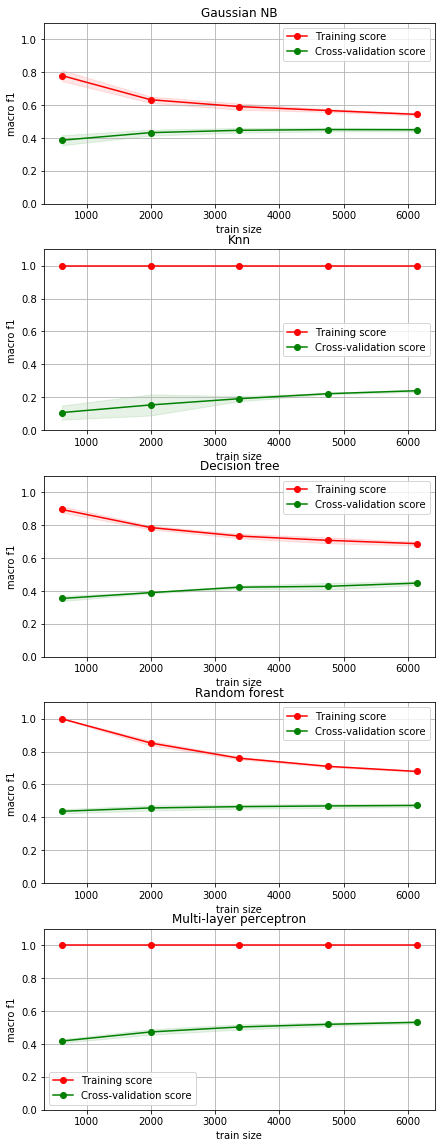

In [579]:
_, axes = plt.subplots(5, 1, figsize=(7, 20))
plt.subplots_adjust(hspace=0.25)

for i in range(1, len(models)):
#     print(model_names[i])
    train_scores_mean = np.mean(train_scores_all2[i-1], axis=1)
    train_scores_std = np.std(train_scores_all2[i-1], axis=1)
    test_scores_mean = np.mean(test_scores_all2[i-1], axis=1)
    test_scores_std = np.std(test_scores_all2[i-1], axis=1)
    fit_times_mean = np.mean(fit_times_all2[i-1], axis=1)
    fit_times_std = np.std(fit_times_all2[i-1], axis=1)

    axes[i-1].grid()
    axes[i-1].fill_between(train_sizes_all[i-1], train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[i-1].fill_between(train_sizes_all[i-1], test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[i-1].plot(train_sizes_all[i-1], train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[i-1].plot(train_sizes_all[i-1], test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[i-1].set_ylabel("macro f1")
    axes[i-1].set_ylim([0, 1.1])
    axes[i-1].set_xlabel("train size")
    axes[i-1].set_title(model_names[i])
    axes[i-1].legend(loc="best")

plt.savefig("error2")

## ensemble learning

### boosting Gnb

#### hyper-parameter tuning

In [749]:
gnb_ada_discrete = AdaBoostClassifier(
    GaussianNB(),
    n_estimators=21,
    learning_rate=1,
    algorithm="SAMME",
    random_state=RANDOM_STATE)

ns = []
train_f1s = []

In [750]:
for i in range(1, 56):
    ns.append(i)
    gnb_ada_discrete.set_params(n_estimators=i)
    
    scores = cross_val_score(estimator=gnb_ada_discrete, 
                    X=train_all_features, 
                    y=train_labels.values.ravel(), 
                    cv=5,
                    scoring='f1_macro')
    train_f1s.append(np.mean(scores))
    
    print(i, train_f1s[-1])

1 0.44954506564133023
2 0.44954506564133023
3 0.4907536619631535
4 0.4716838477608872
5 0.47437735819921156
6 0.46885493146507856
7 0.47376608024160216
8 0.4814647123708621
9 0.48531839940898325
10 0.48406019097121816
11 0.4839136960255255
12 0.48817808918588657
13 0.4875599218132004
14 0.49322922215555254
15 0.49468130702936924
16 0.49636618255333154
17 0.4940741328765158
18 0.49481234579872985
19 0.5000594417074374
20 0.5017177946420661
21 0.5030761888995301
22 0.5059562757230187
23 0.5071184662171423
24 0.5102928485634524
25 0.510691148962706
26 0.5105116545251838
27 0.5125593893283058
28 0.5120553994434319
29 0.5118395132258378
30 0.514910808483171
31 0.5116547393567088
32 0.5113471409537307
33 0.5111134397896668
34 0.5147495301433584
35 0.5143858219444986
36 0.51285669529886
37 0.5126846756824062
38 0.5122321588850969
39 0.5154869499259126
40 0.5134839052575085
41 0.5138069209455447
42 0.5150900668142022
43 0.5165440532960538
44 0.5162916499764693
45 0.5174804741837009
46 0.515975

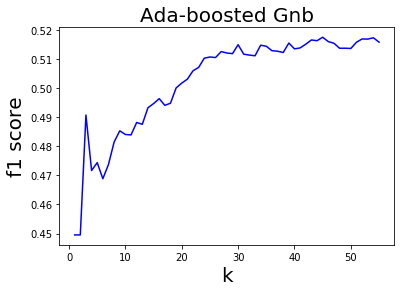

n_estimators maximize f1-score : 45 with 0.5174804741837009


In [751]:
draw_k_line_chart(ns, train_f1s, "f1 score", "Ada-boosted Gnb")
boost_gnb_best_n_estimators = ns[np.argmax(train_f1s)]
print("n_estimators maximize f1-score :", boost_gnb_best_n_estimators, 
      "with", train_f1s[np.argmax(train_f1s)])

#### comparison

In [688]:
Nbs = [
    GaussianNB(),
    AdaBoostClassifier(
        GaussianNB(),
        n_estimators=45,
        learning_rate=1,
        algorithm="SAMME",
        random_state=RANDOM_STATE
    )
]

Nbs_name = ["Gnb", "Ada-boosted Gnb"]

In [689]:
Nbs = train(Nbs, train_all_features, train_labels)

In [690]:
preds = predict(Nbs, valid_all_features)

In [691]:
m_f1s = []
m_acc = []

for p in preds:
    _, acc, pref = evaluate(p, valid_labels.values.ravel())
    m_acc.append(acc)
    m_f1s.append(pref[2])

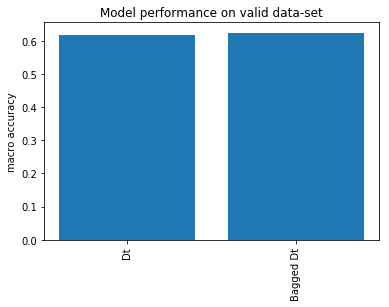

[('Gnb', 0.6177777777777778), ('Ada-boosted Gnb', 0.6244444444444445)]


In [692]:
plt.bar(x=Dts_name, height=m_acc)
plt.ylabel("macro accuracy")
plt.xticks(rotation=90)
plt.title("Model performance on valid data-set")
plt.show()
pprint(list(zip(Nbs_name, m_acc)))

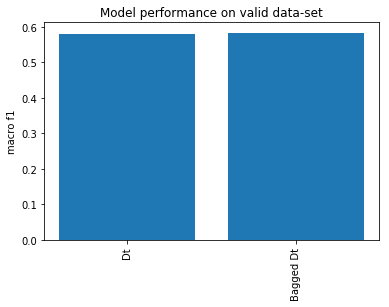

[('Gnb', 0.5791759087379859), ('Ada-boosted Gnb', 0.5832981026072412)]


In [693]:
plt.bar(x=Dts_name, height=m_f1s)
plt.ylabel("macro f1")
plt.xticks(rotation=90)
plt.title("Model performance on valid data-set")
plt.show()
pprint(list(zip(Nbs_name, m_f1s)))

#### error analysis

In [695]:
train_sizes, train_scores, test_scores, fit_times, _ = \
            learning_curve(AdaBoostClassifier(
                                GaussianNB(),
                                n_estimators=45,
                                learning_rate=1,
                                algorithm="SAMME",
                                random_state=RANDOM_STATE
                            ), 
                           train_all_features, 
                           train_labels.values.ravel(), 
                           cv=5, 
                           shuffle=True,
                           random_state=RANDOM_STATE,
                           return_times=True
                          )

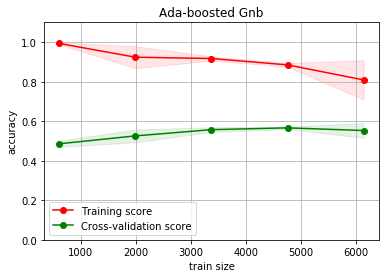

In [696]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)

plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
plt.ylim([0, 1.1])
plt.ylabel("accuracy")
plt.xlabel("train size")
plt.title("Ada-boosted Gnb")
plt.legend(loc="best")

In [697]:
train_sizes2, train_scores2, test_scores2, fit_times2, _ = \
        learning_curve(AdaBoostClassifier(
                                GaussianNB(),
                                n_estimators=45,
                                learning_rate=1,
                                algorithm="SAMME",
                                random_state=RANDOM_STATE
                            ), 
                       train_all_features, 
                       train_labels.values.ravel(), 
                       cv=5, 
                       shuffle=True,
                       random_state=RANDOM_STATE,
                       return_times=True,
                       scoring="f1_macro"
                      )

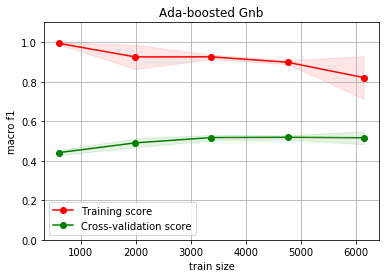

In [698]:
train_scores_mean = np.mean(train_scores2, axis=1)
train_scores_std = np.std(train_scores2, axis=1)
test_scores_mean = np.mean(test_scores2, axis=1)
test_scores_std = np.std(test_scores2, axis=1)
fit_times_mean = np.mean(fit_times2, axis=1)
fit_times_std = np.std(fit_times2, axis=1)

plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
plt.ylim([0, 1.1])
plt.ylabel("macro f1")
plt.xlabel("train size")
plt.title("Ada-boosted Gnb")
plt.legend(loc="best")

#### inspect

In [711]:
gnb_ada_discrete = AdaBoostClassifier(
    GaussianNB(),
    n_estimators=45,
    learning_rate=1,
    algorithm="SAMME",
    random_state=RANDOM_STATE)
gnb_ada_discrete.fit(train_all_features, train_labels.values.ravel())

AdaBoostClassifier(algorithm='SAMME', base_estimator=GaussianNB(),
                   learning_rate=1, n_estimators=45, random_state=90049)

Text(0.5,1,'Ada-boosted Gnb confusion matrix')

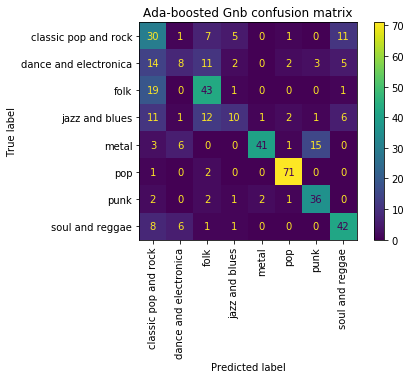

In [712]:
plot_confusion_matrix(gnb_ada_discrete, 
                      valid_all_features, 
                      valid_labels.values.ravel(),
                      xticks_rotation='vertical'
                     )
plt.title("Ada-boosted Gnb confusion matrix")

### bagging Dt

#### hyper-parameter tuning

In [ ]:
bagging_dt = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(criterion="entropy", max_depth=9, random_state=RANDOM_STATE),
                            n_estimators=10, 
                            random_state=RANDOM_STATE)

ns_bagging = []
train_bagging_f1s = []

In [ ]:
for i in range(1, 101):
    bagging_dt.set_params(n_estimators=i)
    
    scores = cross_val_score(estimator=bagging_dt, 
                    X=train_all_features, 
                    y=train_labels.values.ravel(), 
                    cv=5,
                    scoring='f1_macro')
    train_bagging_f1s.append(np.mean(scores))
    ns_bagging.append(i)
    
    print(i, train_bagging_f1s[-1])

In [ ]:
draw_k_line_chart(ns_bagging, train_bagging_f1s, "f1 score", "Dt bagging")
Dt_bagging_best_n_estimators = ns_bagging[np.argmax(train_bagging_f1s)]
print("n_estimators maximize f1-score :", Dt_bagging_best_n_estimators, 
      "with", train_bagging_f1s[np.argmax(train_bagging_f1s)])

#### comparison

In [664]:
Dts = [
    DecisionTreeClassifier(criterion="entropy", max_depth=9, random_state=RANDOM_STATE),
    BaggingClassifier(
    base_estimator=DecisionTreeClassifier(criterion="entropy", max_depth=9, random_state=RANDOM_STATE),
                            n_estimators=54, 
                            random_state=RANDOM_STATE)
]

Dts_name = ["Dt", "Bagged Dt"]

In [666]:
Dts = train(Dts, train_all_features, train_labels)

In [679]:
preds = predict(Dts, valid_all_features)

In [680]:
m_f1s = []
m_acc = []

for p in preds:
    _, acc, pref = evaluate(p, valid_labels.values.ravel())
    m_acc.append(acc)
    m_f1s.append(pref[2])

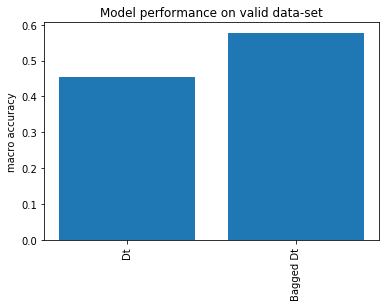

[('Dt', 0.4533333333333333), ('Bagged Dt', 0.5777777777777777)]


In [682]:
plt.bar(x=Dts_name, height=m_acc)
plt.ylabel("macro accuracy")
plt.xticks(rotation=90)
plt.title("Model performance on valid data-set")
plt.show()
pprint(list(zip(Dts_name, m_acc)))

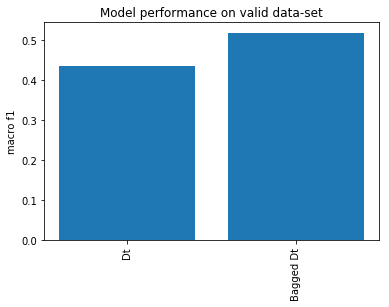

[('Dt', 0.4351733143531153), ('Bagged Dt', 0.5193925057031797)]


In [683]:
plt.bar(x=Dts_name, height=m_f1s)
plt.ylabel("macro f1")
plt.xticks(rotation=90)
plt.title("Model performance on valid data-set")
plt.show()
pprint(list(zip(Dts_name, m_f1s)))

#### error analysis

In [667]:
train_sizes, train_scores, test_scores, fit_times, _ = \
            learning_curve(BaggingClassifier(
                            base_estimator=DecisionTreeClassifier(criterion="entropy", max_depth=9, random_state=RANDOM_STATE),
                            n_estimators=54, 
                            random_state=RANDOM_STATE), 
                           train_all_features, 
                           train_labels.values.ravel(), 
                           cv=5, 
                           shuffle=True,
                           random_state=RANDOM_STATE,
                           return_times=True
                          )

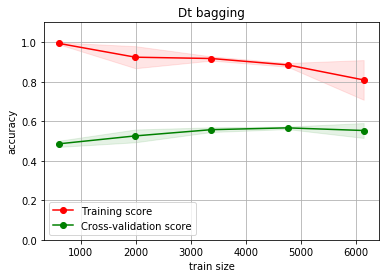

In [742]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)

plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
plt.ylim([0, 1.1])
plt.ylabel("accuracy")
plt.xlabel("train size")
plt.title("Dt bagging")
plt.legend(loc="best")

In [ ]:
train_sizes2, train_scores2, test_scores2, fit_times2, _ = \
        learning_curve(BaggingClassifier(
                        base_estimator=DecisionTreeClassifier(criterion="entropy", max_depth=9, random_state=RANDOM_STATE),
                        n_estimators=54, 
                        random_state=RANDOM_STATE),
                       train_all_features, 
                       train_labels.values.ravel(), 
                       cv=5, 
                       shuffle=True,
                       random_state=RANDOM_STATE,
                       return_times=True,
                       scoring="f1_macro"
                      )

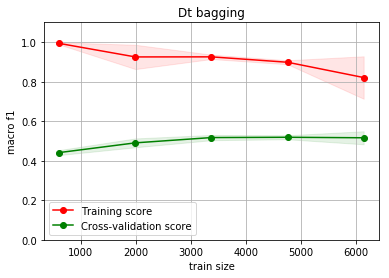

In [741]:
train_scores_mean = np.mean(train_scores2, axis=1)
train_scores_std = np.std(train_scores2, axis=1)
test_scores_mean = np.mean(test_scores2, axis=1)
test_scores_std = np.std(test_scores2, axis=1)
fit_times_mean = np.mean(fit_times2, axis=1)
fit_times_std = np.std(fit_times2, axis=1)

plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
plt.ylim([0, 1.1])
plt.ylabel("macro f1")
plt.xlabel("train size")
plt.title("Dt bagging")
plt.legend(loc="best")

# --------- below are scratch, all diagrams in report are above

# scratch

## knn: choose best k for chi2 half, only audio

As mentioned in the slide, for weighted k-nn, we have three strategies: Majority voting, Inverse Linear Distance and Inverse Distance. 

Majority is not considering the case when there are neighbors really similar to the test instance but belong to the minority. That is why you need approaches that consider this, namely, inverse distance and inverse linear distance. As we have imbalanced class distribution in the dataset. So majority method is not considered. 
Within the context of k-nn, I wouldn’t choose a winner between inverse distance and inverse linear distance. Both methods achieve the same, roughly. The only difference I can emphasize has to do with the set of possible values. The inverse linear distance is bounded to be within 0 and 1. As sklearn.neighbors.KNeighborsClassifier only supports builtin:
- ‘uniform’ : uniform weights. All points in each neighborhood are weighted equally.
- ‘distance’ : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.

So I will just consider inverse distance weighting method.

As all attributes are normalized between 0 and 1, Euclidean and Manhattan distance is no longer affected by attribute magnitude. Otherwise, the distance will be dominated by avg_glucose_level, bmi, age attributes as they originally has large magnitude than other 0-1 based attribute. 

So for three distance Euclidean, Manhattan and Cosine. Cosine distance is not a proper distance metric as it fails the triangle inequality. What's more, it takes more time to compute than Euclidean and Manhattan. As the normalization makes Euclidean and Manhattan not be sensitive to magnitude just as Cosine. So I will just consider Euclidean and Manhattan for Knn classifier.

In [30]:
# k_max = train_audio_normalized_low_corr_chi_selected.shape[0] - 1 # all

def select_best_k(X_train: pd.DataFrame, Y_train: pd.DataFrame, X_valid: pd.DataFrame, Y_valid: pd.DataFrame, k_max=500):
    ks = []
    f1s = [[], []]

    for k in range(1, k_max):
        models = [KNeighborsClassifier(n_neighbors=k, weights="distance", metric='euclidean'), 
                  KNeighborsClassifier(n_neighbors=k, weights="distance", metric='manhattan')]
        trained_models = train(models, train_audio_normalized_low_corr_chi_selected, train_labels)
        model_preds = predict(trained_models, valid_audio_normalized_low_corr_chi_selected)
        for i, preds in enumerate(model_preds):
            _, _, pref = evaluate(preds, valid_labels)
            f1s[i].append(pref[2])
        ks.append(k)

        print(k, k_max)
    return ks, f1s

In [31]:
ks, f1s = select_best_k(train_audio_normalized_low_corr_chi_selected, 
                        train_labels, 
                        valid_audio_normalized_low_corr_chi_selected, 
                        valid_labels, 
                        k_max=200)

1 200
2 200
3 200
4 200
5 200
6 200
7 200
8 200
9 200
10 200
11 200
12 200
13 200
14 200
15 200
16 200
17 200
18 200
19 200
20 200
21 200
22 200
23 200
24 200
25 200
26 200
27 200
28 200
29 200
30 200
31 200
32 200
33 200
34 200
35 200
36 200
37 200
38 200
39 200
40 200
41 200
42 200
43 200
44 200
45 200
46 200
47 200
48 200
49 200
50 200
51 200
52 200
53 200
54 200
55 200
56 200
57 200
58 200
59 200
60 200
61 200
62 200
63 200
64 200
65 200
66 200
67 200
68 200
69 200
70 200
71 200
72 200
73 200
74 200
75 200
76 200
77 200
78 200
79 200
80 200
81 200
82 200
83 200
84 200
85 200
86 200
87 200
88 200
89 200
90 200
91 200
92 200
93 200
94 200
95 200
96 200
97 200
98 200
99 200
100 200
101 200
102 200
103 200
104 200
105 200
106 200
107 200
108 200
109 200
110 200
111 200
112 200
113 200
114 200
115 200
116 200
117 200
118 200
119 200
120 200
121 200
122 200
123 200
124 200
125 200
126 200
127 200
128 200
129 200
130 200
131 200
132 200
133 200
134 200
135 200
136 200
137 200
138 200
139 

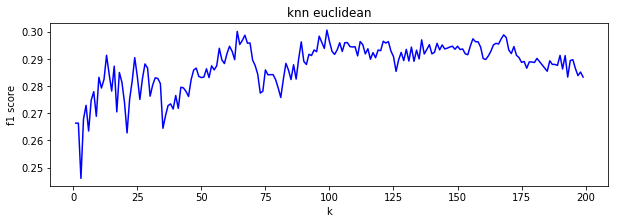

k maximize f1-score : 99 with 0.30068160635369345


In [33]:
draw_k_line_chart(ks, f1s[0], "f1 score", "knn euclidean")
knn_euclidean_k = ks[np.argmax(f1s[0])]
print("k maximize f1-score :", knn_euclidean_k, "with", f1s[0][np.argmax(f1s[0])])

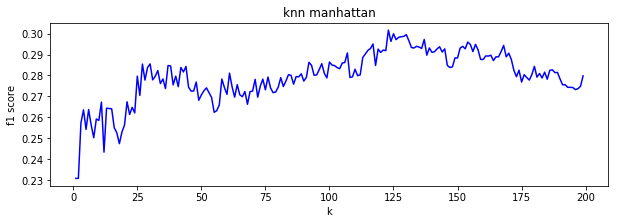

k maximize f1-score : 123 with 0.30165380900354066


In [34]:
draw_k_line_chart(ks, f1s[1], "f1 score", "knn manhattan")
knn_manhattan_k = ks[np.argmax(f1s[1])]
print("k maximize f1-score :", knn_manhattan_k, "with", f1s[1][np.argmax(f1s[1])])

In [35]:
trained_knn = KNeighborsClassifier(n_neighbors=knn_manhattan_k, weights="distance", metric='manhattan')
trained_knn.fit(train_audio_normalized_low_corr_chi_selected, train_labels.values.ravel())

KNeighborsClassifier(metric='manhattan', n_neighbors=123, weights='distance')

d:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

      soul and reggae       0.23      0.51      0.32        55
 classic pop and rock       1.00      0.18      0.30        45
                metal       0.22      0.56      0.32        64
                 folk       0.00      0.00      0.00        44
                  pop       0.56      0.70      0.62        66
dance and electronica       0.00      0.00      0.00        74
       jazz and blues       0.33      0.34      0.34        44
                 punk       0.74      0.40      0.52        58

             accuracy                           0.35       450
            macro avg       0.39      0.34      0.30       450
         weighted avg       0.37      0.35      0.30       450



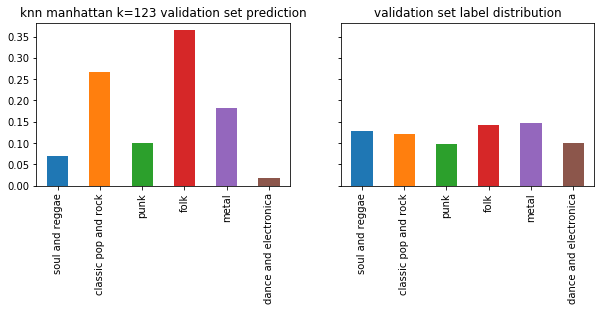

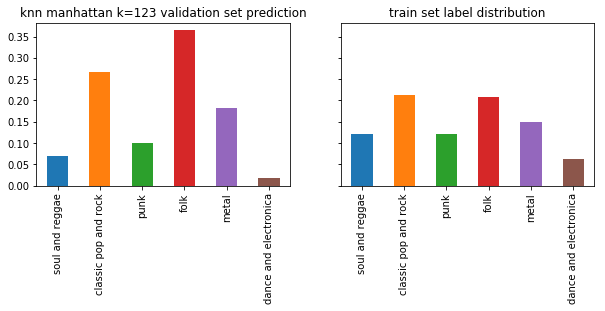

In [36]:
preds = trained_knn.predict(valid_audio_normalized_low_corr_chi_selected)
# CM, _, prefs = evaluate(preds, valid_labels, average=None)
print(classification_report(valid_labels, preds, target_names=valid_labels["genre"].unique()))
draw_train_valid_label_distribution(pd.DataFrame(preds, columns=valid_labels.columns, index=valid_audio_normalized_low_corr_chi_selected.index), 
                                    valid_labels,
                                    title1="knn manhattan k=123 validation set prediction")
draw_train_valid_label_distribution(pd.DataFrame(preds, columns=valid_labels.columns, index=valid_audio_normalized_low_corr_chi_selected.index), 
                                    train_labels,
                                    title1="knn manhattan k=123 validation set prediction",
                                    title2="train set label distribution")

## knn: choose best k for no chi2 half, only audio

In [37]:
ks, f1s, = select_best_k(train_audio_normalized_low_corr, 
                        train_labels, 
                        valid_audio_normalized_low_corr, 
                        valid_labels, 
                        k_max=200)

1 200
2 200
3 200
4 200
5 200
6 200
7 200
8 200
9 200
10 200
11 200
12 200
13 200
14 200
15 200
16 200
17 200
18 200
19 200
20 200
21 200
22 200
23 200
24 200
25 200
26 200
27 200
28 200
29 200
30 200
31 200
32 200
33 200
34 200
35 200
36 200
37 200
38 200
39 200
40 200
41 200
42 200
43 200
44 200
45 200
46 200
47 200
48 200
49 200
50 200
51 200
52 200
53 200
54 200
55 200
56 200
57 200
58 200
59 200
60 200
61 200
62 200
63 200
64 200
65 200
66 200
67 200
68 200
69 200
70 200
71 200
72 200
73 200
74 200
75 200
76 200
77 200
78 200
79 200
80 200
81 200
82 200
83 200
84 200
85 200
86 200
87 200
88 200
89 200
90 200
91 200
92 200
93 200
94 200
95 200
96 200
97 200
98 200
99 200
100 200
101 200
102 200
103 200
104 200
105 200
106 200
107 200
108 200
109 200
110 200
111 200
112 200
113 200
114 200
115 200
116 200
117 200
118 200
119 200
120 200
121 200
122 200
123 200
124 200
125 200
126 200
127 200
128 200
129 200
130 200
131 200
132 200
133 200
134 200
135 200
136 200
137 200
138 200
139 

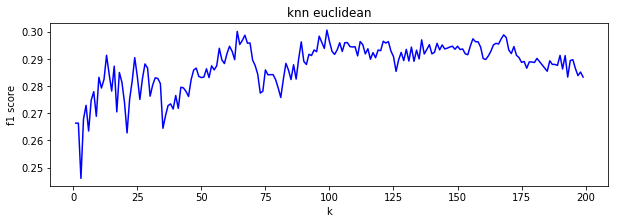

k maximize f1-score : 99 with 0.30068160635369345


In [38]:
draw_k_line_chart(ks, f1s[0], "f1 score", "knn euclidean")
knn_euclidean_k = ks[np.argmax(f1s[0])]
print("k maximize f1-score :", knn_euclidean_k, "with", f1s[0][np.argmax(f1s[0])])

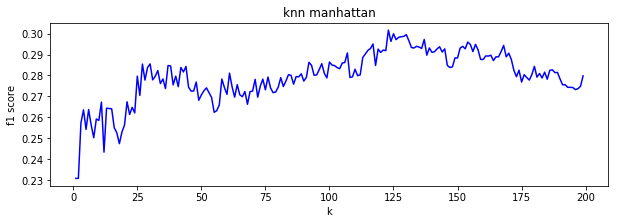

k maximize f1-score : 123 with 0.30165380900354066


In [39]:
draw_k_line_chart(ks, f1s[1], "f1 score", "knn manhattan")
knn_manhattan_k = ks[np.argmax(f1s[1])]
print("k maximize f1-score :", knn_manhattan_k, "with", f1s[1][np.argmax(f1s[1])])

## knn: random forest selected features

In [40]:
ks, f1s, = select_best_k(train_random_forest_selected, 
                        train_labels, 
                        valid_random_forest_selected, 
                        valid_labels, 
                        k_max=200)

1 200
2 200
3 200
4 200
5 200
6 200
7 200
8 200
9 200
10 200
11 200
12 200
13 200
14 200
15 200
16 200
17 200
18 200
19 200
20 200
21 200
22 200
23 200
24 200
25 200
26 200
27 200
28 200
29 200
30 200
31 200
32 200
33 200
34 200
35 200
36 200
37 200
38 200
39 200
40 200
41 200
42 200
43 200
44 200
45 200
46 200
47 200
48 200
49 200
50 200
51 200
52 200
53 200
54 200
55 200
56 200
57 200
58 200
59 200
60 200
61 200
62 200
63 200
64 200
65 200
66 200
67 200
68 200
69 200
70 200
71 200
72 200
73 200
74 200
75 200
76 200
77 200
78 200
79 200
80 200
81 200
82 200
83 200
84 200
85 200
86 200
87 200
88 200
89 200
90 200
91 200
92 200
93 200
94 200
95 200
96 200
97 200
98 200
99 200
100 200
101 200
102 200
103 200
104 200
105 200
106 200
107 200
108 200
109 200
110 200
111 200
112 200
113 200
114 200
115 200
116 200
117 200
118 200
119 200
120 200
121 200
122 200
123 200
124 200
125 200
126 200
127 200
128 200
129 200
130 200
131 200
132 200
133 200
134 200
135 200
136 200
137 200
138 200
139 

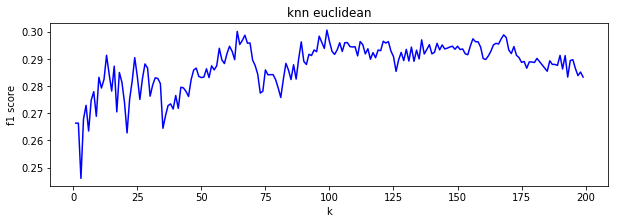

k maximize f1-score : 99 with 0.30068160635369345


In [41]:
draw_k_line_chart(ks, f1s[0], "f1 score", "knn euclidean")
knn_euclidean_k = ks[np.argmax(f1s[0])]
print("k maximize f1-score :", knn_euclidean_k, "with", f1s[0][np.argmax(f1s[0])])

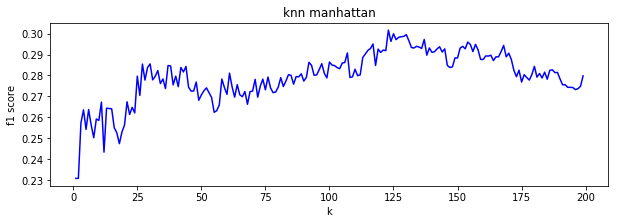

k maximize f1-score : 123 with 0.30165380900354066


In [42]:
draw_k_line_chart(ks, f1s[1], "f1 score", "knn manhattan")
knn_manhattan_k = ks[np.argmax(f1s[1])]
print("k maximize f1-score :", knn_manhattan_k, "with", f1s[1][np.argmax(f1s[1])])

d:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

      soul and reggae       0.30      0.31      0.30        55
 classic pop and rock       1.00      0.11      0.20        45
                metal       0.22      0.67      0.33        64
                 folk       0.00      0.00      0.00        44
                  pop       0.72      0.88      0.79        66
dance and electronica       0.89      0.11      0.19        74
       jazz and blues       0.52      0.30      0.38        44
                 punk       0.63      0.81      0.71        58

             accuracy                           0.42       450
            macro avg       0.53      0.40      0.36       450
         weighted avg       0.55      0.42      0.38       450



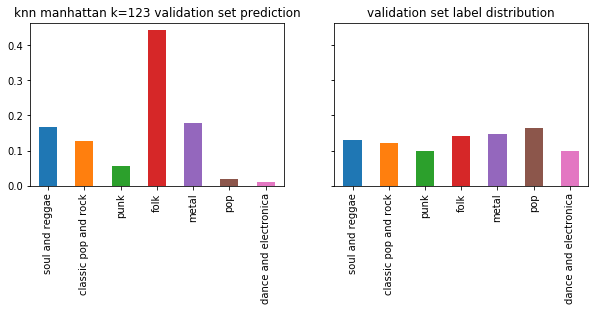

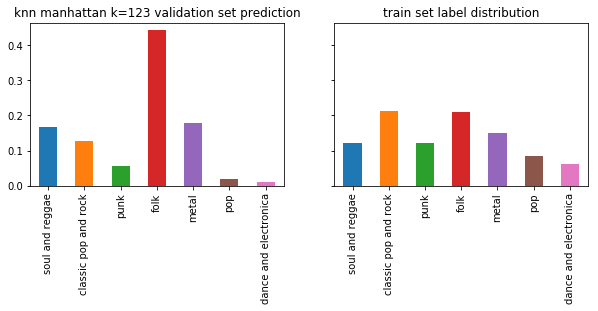

In [43]:
trained_knn = KNeighborsClassifier(n_neighbors=knn_manhattan_k, weights="distance", metric='manhattan')
trained_knn.fit(train_random_forest_selected, train_labels.values.ravel())

preds = trained_knn.predict(valid_random_forest_selected)
# CM, _, prefs = evaluate(preds, valid_labels, average=None)
print(classification_report(valid_labels, preds, target_names=valid_labels["genre"].unique()))
draw_train_valid_label_distribution(pd.DataFrame(preds, columns=valid_labels.columns, index=valid_random_forest_selected.index), 
                                    valid_labels,
                                    title1="knn manhattan k=123 validation set prediction")
draw_train_valid_label_distribution(pd.DataFrame(preds, columns=valid_labels.columns, index=valid_random_forest_selected.index), 
                                    train_labels,
                                    title1="knn manhattan k=123 validation set prediction",
                                    title2="train set label distribution")

## knn, all meta and audio (0.35156)

In [44]:
train_continuous_0_1_meta_audio
valid_continuous_0_1_meta_audio = one_hot_encoding(valid_features, "key")
valid_continuous_0_1_meta_audio = select_df1_columns_based_on_df2(valid_continuous_0_1_meta_audio, 
                                                                  train_continuous_0_1_meta_audio)

In [45]:
ks, f1s, = select_best_k(train_continuous_0_1_meta_audio, 
                        train_labels, 
                        valid_continuous_0_1_meta_audio, 
                        valid_labels, 
                        k_max=200)

1 200
2 200
3 200
4 200
5 200
6 200
7 200
8 200
9 200
10 200
11 200
12 200
13 200
14 200
15 200
16 200
17 200
18 200
19 200
20 200
21 200
22 200
23 200
24 200
25 200
26 200
27 200
28 200
29 200
30 200
31 200
32 200
33 200
34 200
35 200
36 200
37 200
38 200
39 200
40 200
41 200
42 200
43 200
44 200
45 200
46 200
47 200
48 200
49 200
50 200
51 200
52 200
53 200
54 200
55 200
56 200
57 200
58 200
59 200
60 200
61 200
62 200
63 200
64 200
65 200
66 200
67 200
68 200
69 200
70 200
71 200
72 200
73 200
74 200
75 200
76 200
77 200
78 200
79 200
80 200
81 200
82 200
83 200
84 200
85 200
86 200
87 200
88 200
89 200
90 200
91 200
92 200
93 200
94 200
95 200
96 200
97 200
98 200
99 200
100 200
101 200
102 200
103 200
104 200
105 200
106 200
107 200
108 200
109 200
110 200
111 200
112 200
113 200
114 200
115 200
116 200
117 200
118 200
119 200
120 200
121 200
122 200
123 200
124 200
125 200
126 200
127 200
128 200
129 200
130 200
131 200
132 200
133 200
134 200
135 200
136 200
137 200
138 200
139 

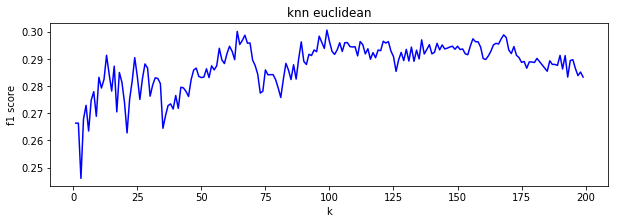

k maximize f1-score : 99 with 0.30068160635369345


In [46]:
draw_k_line_chart(ks, f1s[0], "f1 score", "knn euclidean")
knn_euclidean_k = ks[np.argmax(f1s[0])]
print("k maximize f1-score :", knn_euclidean_k, "with", f1s[0][np.argmax(f1s[0])])

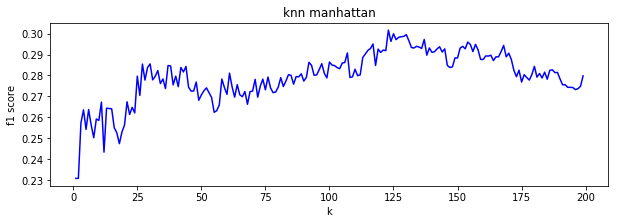

k maximize f1-score : 123 with 0.30165380900354066


In [47]:
draw_k_line_chart(ks, f1s[1], "f1 score", "knn manhattan")
knn_manhattan_k = ks[np.argmax(f1s[1])]
print("k maximize f1-score :", knn_manhattan_k, "with", f1s[1][np.argmax(f1s[1])])

### report

In [49]:
trained_knn = KNeighborsClassifier(n_neighbors=knn_manhattan_k, weights="distance", metric='manhattan')
trained_knn.fit(train_continuous_0_1_meta_audio, train_labels.values.ravel())

KNeighborsClassifier(metric='manhattan', n_neighbors=123, weights='distance')

d:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

      soul and reggae       0.02      0.04      0.02        55
 classic pop and rock       0.00      0.00      0.00        45
                metal       0.17      0.92      0.29        64
                 folk       0.00      0.00      0.00        44
                  pop       0.00      0.00      0.00        66
dance and electronica       0.00      0.00      0.00        74
       jazz and blues       0.00      0.00      0.00        44
                 punk       0.00      0.00      0.00        58

             accuracy                           0.14       450
            macro avg       0.02      0.12      0.04       450
         weighted avg       0.03      0.14      0.04       450



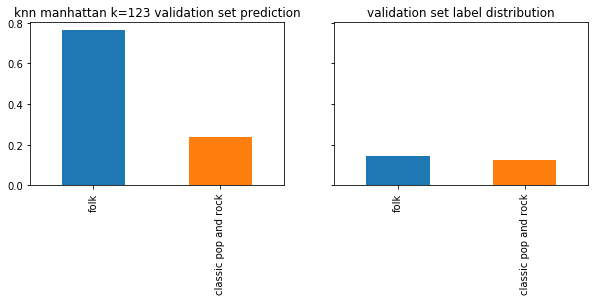

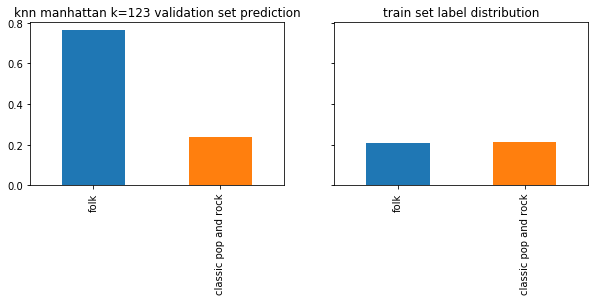

In [50]:
preds = trained_knn.predict(valid_continuous_0_1_meta_audio)
# CM, _, prefs = evaluate(preds, valid_labels, average=None)
print(classification_report(valid_labels, preds, target_names=valid_labels["genre"].unique()))
draw_train_valid_label_distribution(pd.DataFrame(preds, columns=valid_labels.columns, index=valid_continuous_0_1_meta_audio.index), 
                                    valid_labels,
                                    title1="knn manhattan k=123 validation set prediction")
draw_train_valid_label_distribution(pd.DataFrame(preds, columns=valid_labels.columns, index=valid_continuous_0_1_meta_audio.index), 
                                    train_labels,
                                    title1="knn manhattan k=123 validation set prediction",
                                    title2="train set label distribution")

### test

In [ ]:
trained_knn = KNeighborsClassifier(n_neighbors=knn_manhattan_k, weights="distance", metric='manhattan')
trained_knn.fit(train_continuous_0_1_meta_audio, train_labels.values.ravel())

In [ ]:
models = [trained_knn]
test_knn = select_df1_columns_based_on_df2(one_hot_encoding(test_features, "key"),
                                            train_continuous_0_1_meta_audio)
test_knn = transform_continuous_0_1(test_knn)
test_preds = predict(models, test_knn)
test_preds[0].reset_index(level=0).to_csv(path_or_buf="test_pred.csv", columns=["trackID", "genre"], index=False)

## rf: random forest selected features (0.42968)

In [44]:
train_rf = select_df1_columns_based_on_df2(train_features, train_random_forest_selected)
valid_rf = select_df1_columns_based_on_df2(valid_features, train_rf)

In [49]:
rf = RandomForestClassifier(n_estimators = 1000, 
                         random_state=RANDOM_STATE, 
                         criterion="entropy",
                         )
rf.fit(train_rf, train_labels.values.ravel())

MemoryError: could not allocate 196608 bytes

In [ ]:
pred = rf.predict(valid_rf)
_, _, pref = evaluate(pred, valid_labels)
print(classification_report(valid_labels, pred, target_names=valid_labels["genre"].unique()))

draw_train_valid_label_distribution(pd.DataFrame(pred, columns=valid_labels.columns, index=valid_audio_normalized_low_corr_chi_selected.index), 
                                    valid_labels,
                                    title1="random forest")

### test

In [ ]:
# rf

models = [rf]
test_knn = select_df1_columns_based_on_df2(one_hot_encoding(test_features, "key"),
                                            train_rf)
# test_knn = transform_continuous_0_1(test_knn)
test_preds = predict(models, test_knn)
test_preds[0].reset_index(level=0).to_csv(path_or_buf="test_pred.csv", columns=["trackID", "genre"], index=False)

### random search

modify from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [ ]:
rf = RandomForestClassifier(random_state = RANDOM_STATE)

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 6)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 50, num = 6)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'oob_score': [True, False],
               'bootstrap': bootstrap,
              }
pprint(random_grid)

In [ ]:
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, 
#                                param_distributions = random_grid, 
#                                n_iter = 100, 
#                                cv = 5, 
#                                verbose=2, 
#                                random_state=RANDOM_STATE, 
#                                n_jobs = -1)
# # Fit the random search model
# rf_random.fit(train_rf, train_labels.values.ravel())
# rf_random.best_params_

In [ ]:
# rf_random.best_params_

### out of bag error

## rf: random forest selected features, max depth=10 (0.42968)

In [28]:
train_rf = select_df1_columns_based_on_df2(train_features, train_random_forest_selected)
valid_rf = select_df1_columns_based_on_df2(valid_features, train_rf)

In [29]:
rf = RandomForestClassifier(n_estimators = 1000, 
                         random_state=RANDOM_STATE, 
                         criterion="entropy",
                         max_depth=10)
rf.fit(train_rf, train_labels.values.ravel())

RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=1000,
                       random_state=90049)

d:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

      soul and reggae       0.22      0.40      0.29        55
 classic pop and rock       1.00      0.16      0.27        45
                metal       0.25      0.62      0.35        64
                 folk       0.00      0.00      0.00        44
                  pop       0.87      0.52      0.65        66
dance and electronica       0.90      0.12      0.21        74
       jazz and blues       0.41      0.59      0.48        44
                 punk       0.64      0.78      0.70        58

             accuracy                           0.41       450
            macro avg       0.54      0.40      0.37       450
         weighted avg       0.56      0.41      0.38       450



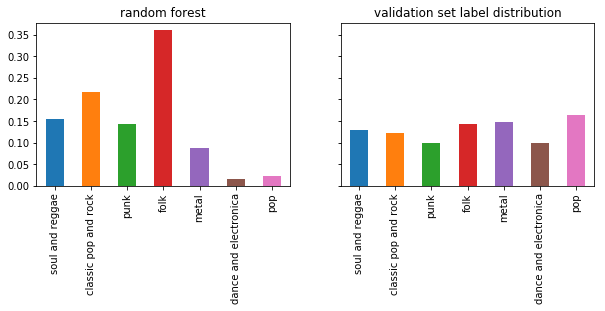

In [34]:
pred = rf.predict(valid_rf)
_, _, pref = evaluate(pred, valid_labels)
print(classification_report(valid_labels, pred, target_names=valid_labels["genre"].unique()))

draw_train_valid_label_distribution(pd.DataFrame(pred, columns=valid_labels.columns, index=valid_audio_normalized_low_corr_chi_selected.index), 
                                    valid_labels,
                                    title1="random forest")

### test

In [39]:
# rf

models = [rf]
test_knn = select_df1_columns_based_on_df2(one_hot_encoding(test_features, "key"),
                                            train_rf)
# test_knn = transform_continuous_0_1(test_knn)
test_preds = predict(models, test_knn)
test_preds[0].reset_index(level=0).to_csv(path_or_buf="test_pred.csv", columns=["trackID", "genre"], index=False)

## rf, n_estimators=1000, max depth=10, meta + audio (0.39843)

rf, n_estimators=1000, max depth=15, meta + audio (0.36718)

In [66]:
train_rf = train_continuous_meta_audio
valid_rf = select_df1_columns_based_on_df2(one_hot_encoding(valid_features, "key"), 
                                                            train_continuous_meta_audio)

In [71]:
rf = RandomForestClassifier(n_estimators = 1000, 
                         random_state=RANDOM_STATE, 
                         criterion="entropy",
                         max_depth=10)
rf.fit(train_rf, train_labels.values.ravel())

RandomForestClassifier(criterion='entropy', max_depth=15, n_estimators=1000,
                       random_state=90049)

                       precision    recall  f1-score   support

      soul and reggae       0.24      0.47      0.32        55
 classic pop and rock       1.00      0.18      0.30        45
                metal       0.27      0.67      0.39        64
                 folk       1.00      0.02      0.04        44
                  pop       0.88      0.65      0.75        66
dance and electronica       0.93      0.18      0.30        74
       jazz and blues       0.44      0.50      0.47        44
                 punk       0.73      0.79      0.76        58

             accuracy                           0.45       450
            macro avg       0.69      0.43      0.42       450
         weighted avg       0.68      0.45      0.43       450



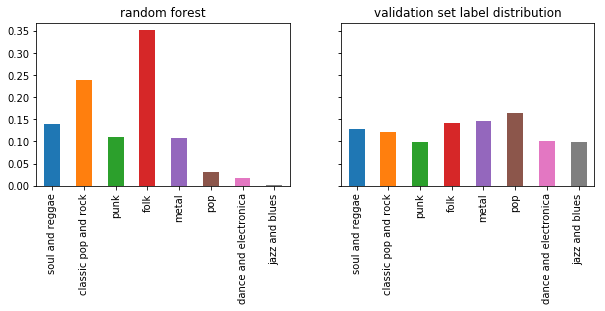

In [72]:
pred = rf.predict(valid_rf)
_, _, pref = evaluate(pred, valid_labels)
print(classification_report(valid_labels, pred, target_names=valid_labels["genre"].unique()))

draw_train_valid_label_distribution(pd.DataFrame(pred, columns=valid_labels.columns, index=valid_audio_normalized_low_corr_chi_selected.index), 
                                    valid_labels,
                                    title1="random forest")

### test

In [73]:
# rf

models = [rf]
test_knn = select_df1_columns_based_on_df2(one_hot_encoding(test_features, "key"),
                                            train_rf)
# test_knn = transform_continuous_0_1(test_knn)
test_preds = predict(models, test_knn)
test_preds[0].reset_index(level=0).to_csv(path_or_buf="test_pred.csv", columns=["trackID", "genre"], index=False)

## rf, n_estimators=500, max depth=15, meta + audio (0.34375)

In [65]:
train_rf = train_continuous_meta_audio
valid_rf = select_df1_columns_based_on_df2(one_hot_encoding(valid_features, "key"), 
                                                            train_continuous_meta_audio)

In [58]:
rf = RandomForestClassifier(n_estimators = 500, 
                         random_state=RANDOM_STATE, 
                         criterion="entropy",
                         max_depth=15)
rf.fit(train_rf, train_labels.values.ravel())

RandomForestClassifier(criterion='entropy', max_depth=15, n_estimators=500,
                       random_state=90049)

                       precision    recall  f1-score   support

      soul and reggae       0.25      0.47      0.33        55
 classic pop and rock       1.00      0.18      0.30        45
                metal       0.26      0.64      0.37        64
                 folk       1.00      0.05      0.09        44
                  pop       0.90      0.68      0.78        66
dance and electronica       0.93      0.18      0.30        74
       jazz and blues       0.47      0.55      0.51        44
                 punk       0.73      0.78      0.75        58

             accuracy                           0.45       450
            macro avg       0.69      0.44      0.43       450
         weighted avg       0.69      0.45      0.44       450



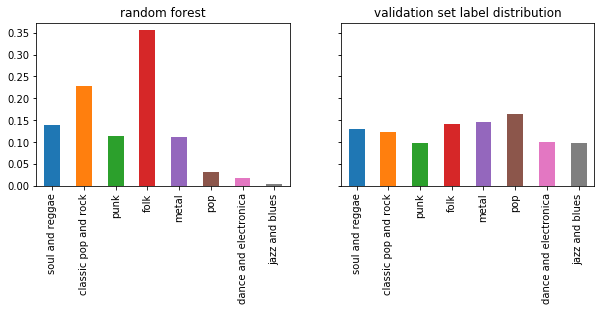

In [60]:
pred = rf.predict(valid_rf)
_, _, pref = evaluate(pred, valid_labels)
print(classification_report(valid_labels, pred, target_names=valid_labels["genre"].unique()))

draw_train_valid_label_distribution(pd.DataFrame(pred, columns=valid_labels.columns, index=valid_audio_normalized_low_corr_chi_selected.index), 
                                    valid_labels,
                                    title1="random forest")

### test

In [61]:
# rf

models = [rf]
test_knn = select_df1_columns_based_on_df2(one_hot_encoding(test_features, "key"),
                                            train_rf)
# test_knn = transform_continuous_0_1(test_knn)
test_preds = predict(models, test_knn)
test_preds[0].reset_index(level=0).to_csv(path_or_buf="test_pred.csv", columns=["trackID", "genre"], index=False)

## Gaussian NB, meta + audio (0.38281)

In [31]:
train_rf = train_continuous_meta_audio
valid_rf = select_df1_columns_based_on_df2(one_hot_encoding(valid_features, "key"), 
                                                            train_continuous_meta_audio)

In [52]:
n_class = len(np.unique(valid_labels["genre"]))
prior = [1 / n_class for _ in range(0, n_class)]

clf = GaussianNB(priors=prior)
clf.fit(train_rf, train_labels.values.ravel())

GaussianNB(priors=[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125])

                       precision    recall  f1-score   support

      soul and reggae       0.39      0.38      0.39        55
 classic pop and rock       0.50      0.24      0.33        45
                metal       0.31      0.30      0.30        64
                 folk       0.37      0.43      0.40        44
                  pop       0.78      0.82      0.80        66
dance and electronica       0.42      0.58      0.49        74
       jazz and blues       0.59      0.43      0.50        44
                 punk       0.69      0.69      0.69        58

             accuracy                           0.50       450
            macro avg       0.51      0.48      0.49       450
         weighted avg       0.51      0.50      0.50       450



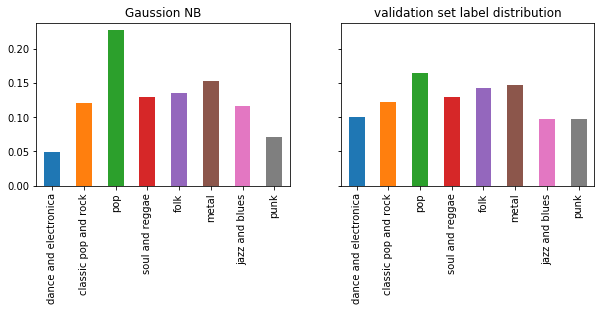

In [53]:
pred = clf.predict(valid_rf)
_, _, pref = evaluate(pred, valid_labels)
print(classification_report(valid_labels, pred, target_names=valid_labels["genre"].unique()))

draw_train_valid_label_distribution(pd.DataFrame(pred, columns=valid_labels.columns, index=valid_audio_normalized_low_corr_chi_selected.index), 
                                    valid_labels,
                                    title1="Gaussion NB")

### test

In [55]:
# rf

models = [clf]
test_knn = select_df1_columns_based_on_df2(one_hot_encoding(test_features, "key"),
                                            train_rf)
# test_knn = transform_continuous_0_1(test_knn)
test_preds = predict(models, test_knn)
test_preds[0].reset_index(level=0).to_csv(path_or_buf="test_pred.csv", columns=["trackID", "genre"], index=False)

## decision tree, meta + audio (0.35937)

In [44]:
train_dt = train_continuous_meta_audio
valid_dt = select_df1_columns_based_on_df2(one_hot_encoding(valid_features, "key"), 
                                                            train_continuous_meta_audio)

dt = DecisionTreeClassifier(criterion="entropy",
                            random_state=RANDOM_STATE)

dt_f1s = []
ds = [i for i in range(1, 50)] #len(train_dt.columns))]
for d in ds:
    dt.set_params(max_depth=d)

    dt.fit(train_dt, train_labels.values.ravel())
    pred = dt.predict(valid_dt)
    
    _, _, pref = evaluate(pred, valid_labels)
    dt_f1s.append(pref[2])
    
    print(d, pref[2])

1 0.11209563612679116
2 0.19070754086677655
3 0.2579623505807951
4 0.27329471569794095
5 0.2815541156531004
6 0.36784364932024194
7 0.35910026324804045
8 0.38291217874597805
9 0.385664546640613
10 0.38468072184436003
11 0.38004930631469
12 0.37822996052019886
13 0.35116967735060434
14 0.37119306113029094
15 0.35114758820385505
16 0.35212848731543384
17 0.3416203099357483
18 0.33718403173111156
19 0.3434706037088421
20 0.33815509058391147
21 0.33815509058391147
22 0.33815509058391147
23 0.33815509058391147
24 0.33815509058391147
25 0.33815509058391147
26 0.33815509058391147
27 0.33815509058391147
28 0.33815509058391147
29 0.33815509058391147
30 0.33815509058391147
31 0.33815509058391147
32 0.33815509058391147
33 0.33815509058391147
34 0.33815509058391147
35 0.33815509058391147
36 0.33815509058391147
37 0.33815509058391147
38 0.33815509058391147
39 0.33815509058391147
40 0.33815509058391147
41 0.33815509058391147
42 0.33815509058391147
43 0.33815509058391147
44 0.33815509058391147
45 0.3

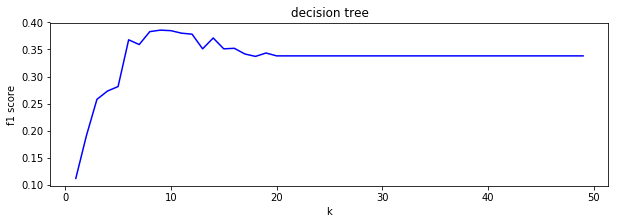

max_depth maximize f1-score : 9 with 0.385664546640613


In [49]:
draw_k_line_chart(ds, dt_f1s, "f1 score", "decision tree")
dt_best_max_depth = ds[np.argmax(dt_f1s)]
print("max_depth maximize f1-score :", dt_best_max_depth, "with", dt_f1s[np.argmax(dt_f1s)])

                       precision    recall  f1-score   support

      soul and reggae       0.24      0.36      0.29        55
 classic pop and rock       0.25      0.09      0.13        45
                metal       0.25      0.55      0.34        64
                 folk       0.50      0.25      0.33        44
                  pop       0.79      0.64      0.71        66
dance and electronica       0.55      0.15      0.23        74
       jazz and blues       0.45      0.57      0.51        44
                 punk       0.54      0.55      0.55        58

             accuracy                           0.40       450
            macro avg       0.45      0.39      0.39       450
         weighted avg       0.46      0.40      0.39       450



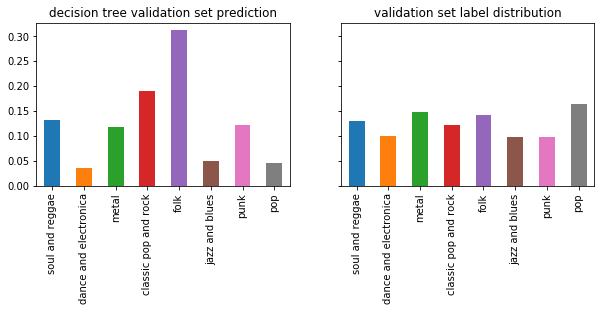

In [102]:
dt.set_params(max_depth=dt_best_max_depth)
dt.fit(train_dt, train_labels.values.ravel())
pred = dt.predict(valid_dt)
print(classification_report(valid_labels, pred, target_names=valid_labels["genre"].unique()))
draw_train_valid_label_distribution(pd.DataFrame(pred, columns=valid_labels.columns, index=valid_audio_normalized_low_corr_chi_selected.index), 
                                    valid_labels,
                                    title1="decision tree validation set prediction")

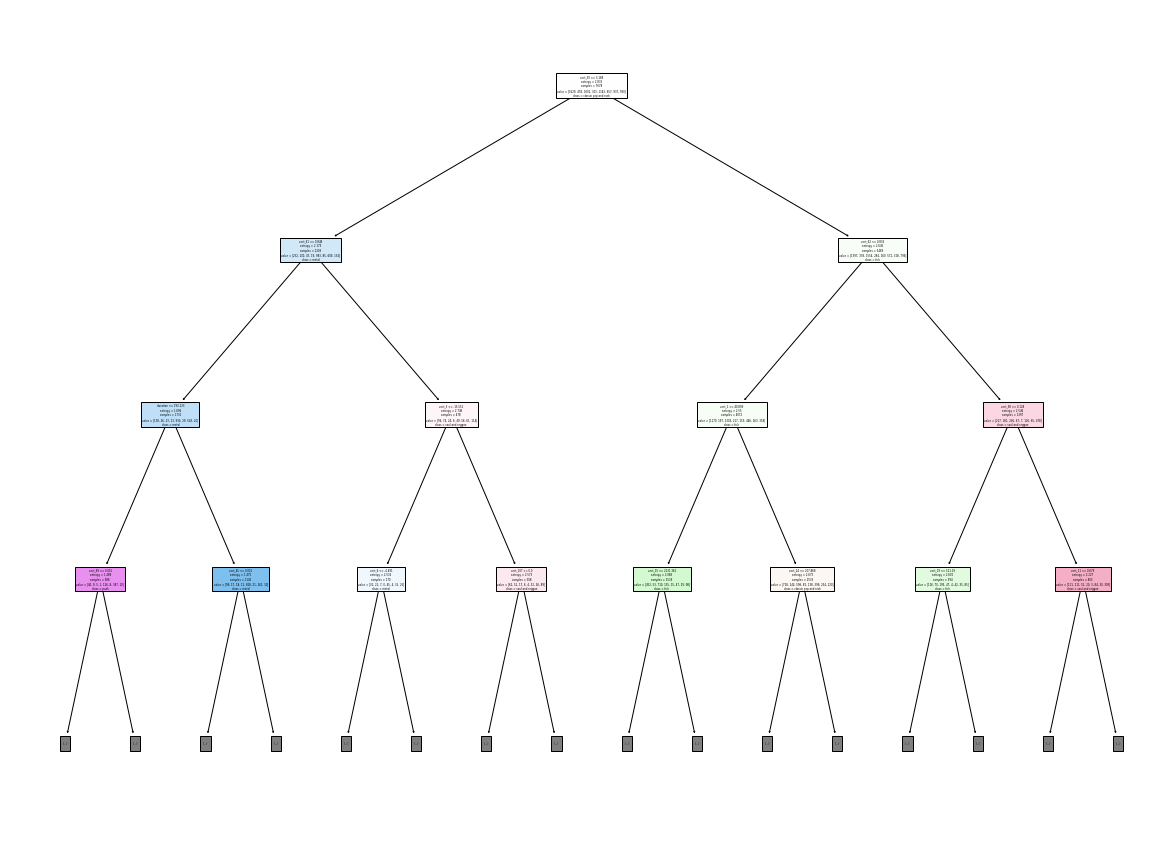

In [109]:
fig = plt.figure(figsize=(20,15))
_ = tree.plot_tree(decision_tree=dt, 
                   feature_names=train_dt.columns,  
                   class_names=np.unique(train_labels),
                   filled=True,
                   max_depth=3)

### test

In [52]:
# rf

models = [dt]
test_knn = select_df1_columns_based_on_df2(one_hot_encoding(test_features, "key"),
                                            train_dt)
# test_knn = transform_continuous_0_1(test_knn)
test_preds = predict(models, test_knn)
test_preds[0].reset_index(level=0).to_csv(path_or_buf="test_pred.csv", columns=["trackID", "genre"], index=False)

## dt: rf selected features (0.27343) max_depth=10 (0.29687)

                       precision    recall  f1-score   support

      soul and reggae       0.23      0.42      0.29        55
 classic pop and rock       0.47      0.18      0.26        45
                metal       0.23      0.47      0.31        64
                 folk       0.38      0.23      0.29        44
                  pop       0.80      0.61      0.69        66
dance and electronica       0.50      0.16      0.24        74
       jazz and blues       0.44      0.55      0.49        44
                 punk       0.55      0.47      0.50        58

             accuracy                           0.39       450
            macro avg       0.45      0.38      0.38       450
         weighted avg       0.46      0.39      0.39       450



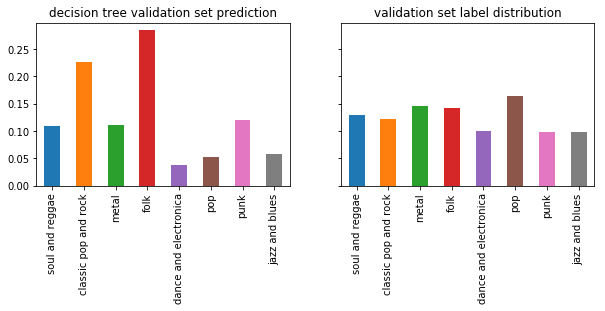

In [58]:
train_rf = select_df1_columns_based_on_df2(train_features, train_random_forest_selected)
valid_rf = select_df1_columns_based_on_df2(valid_features, train_rf)

dt.set_params(max_depth=None)
dt.fit(train_rf, train_labels.values.ravel())
pred = dt.predict(valid_rf)
print(classification_report(valid_labels, pred, target_names=valid_labels["genre"].unique()))
draw_train_valid_label_distribution(pd.DataFrame(pred, columns=valid_labels.columns, index=valid_audio_normalized_low_corr_chi_selected.index), 
                                    valid_labels,
                                    title1="decision tree validation set prediction")

### test

In [93]:
# rf

models = [dt]
test_knn = select_df1_columns_based_on_df2(one_hot_encoding(test_features, "key"),
                                            train_rf)
# test_knn = transform_continuous_0_1(test_knn)
test_preds = predict(models, test_knn)
test_preds[0].reset_index(level=0).to_csv(path_or_buf="test_pred.csv", columns=["trackID", "genre"], index=False)

## linear svc meta + audio (0.45312)

In [96]:
train_svc = train_continuous_meta_audio
valid_svc = select_df1_columns_based_on_df2(one_hot_encoding(valid_features, "key"), 
                                                            train_continuous_meta_audio)

svc = make_pipeline(StandardScaler(),
                    LinearSVC(random_state=RANDOM_STATE, 
                              tol=1e-5,
                              max_iter=10000))
svc.fit(train_svc, train_labels.values.ravel())

d:\python\lib\site-packages\sklearn\svm\_base.py:975: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(max_iter=50000, random_state=90049, tol=1e-05))])

                       precision    recall  f1-score   support

      soul and reggae       0.27      0.67      0.39        55
 classic pop and rock       0.50      0.18      0.26        45
                metal       0.36      0.62      0.46        64
                 folk       0.69      0.20      0.32        44
                  pop       0.84      0.77      0.80        66
dance and electronica       0.67      0.11      0.19        74
       jazz and blues       0.51      0.61      0.56        44
                 punk       0.77      0.64      0.70        58

             accuracy                           0.48       450
            macro avg       0.58      0.48      0.46       450
         weighted avg       0.58      0.48      0.46       450



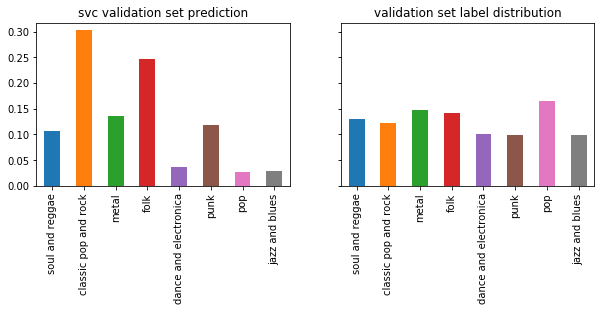

In [97]:
pred = svc.predict(valid_svc)
print(classification_report(valid_labels, pred, target_names=valid_labels["genre"].unique()))
draw_train_valid_label_distribution(pd.DataFrame(pred, columns=valid_labels.columns, index=valid_audio_normalized_low_corr_chi_selected.index), 
                                    valid_labels,
                                    title1="svc validation set prediction")

### test

In [98]:
# rf

models = [svc]
test_knn = select_df1_columns_based_on_df2(one_hot_encoding(test_features, "key"),
                                            train_svc)
# test_knn = transform_continuous_0_1(test_knn)
test_preds = predict(models, test_knn)
test_preds[0].reset_index(level=0).to_csv(path_or_buf="test_pred.csv", columns=["trackID", "genre"], index=False)

## linear svc, audio (0.39843)

In [128]:
train_svc = select_audio_features(train_features)
valid_svc = select_audio_features(valid_features)

svc = make_pipeline(StandardScaler(),
                    LinearSVC(random_state=RANDOM_STATE, 
                              tol=1e-5,
                              max_iter=10000))
svc.fit(train_svc, train_labels.values.ravel())

d:\python\lib\site-packages\sklearn\svm\_base.py:975: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(max_iter=10000, random_state=90049, tol=1e-05))])

                       precision    recall  f1-score   support

      soul and reggae       0.28      0.65      0.39        55
 classic pop and rock       0.60      0.27      0.37        45
                metal       0.35      0.62      0.45        64
                 folk       0.55      0.14      0.22        44
                  pop       0.84      0.80      0.82        66
dance and electronica       0.71      0.14      0.23        74
       jazz and blues       0.54      0.61      0.57        44
                 punk       0.69      0.59      0.64        58

             accuracy                           0.48       450
            macro avg       0.57      0.48      0.46       450
         weighted avg       0.58      0.48      0.47       450



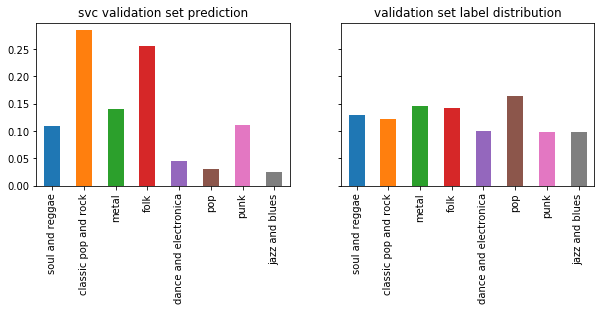

In [130]:
pred = svc.predict(valid_svc)
print(classification_report(valid_labels, pred, target_names=valid_labels["genre"].unique()))
draw_train_valid_label_distribution(pd.DataFrame(pred, columns=valid_labels.columns, index=valid_svc.index), 
                                    valid_labels,
                                    title1="svc validation set prediction")

### test

In [131]:
# rf

models = [svc]
test_knn = select_audio_features(test_features)
# test_knn = transform_continuous_0_1(test_knn)
test_preds = predict(models, test_knn)
test_preds[0].reset_index(level=0).to_csv(path_or_buf="test_pred.csv", columns=["trackID", "genre"], index=False)

## linear svc, pca (0.15625)

In [125]:
svc = make_pipeline(StandardScaler(),
                    LinearSVC(random_state=RANDOM_STATE, 
                              tol=1e-5,
                              max_iter=10000))
svc.fit(train_meta_audio_pca, train_labels.values.ravel())

d:\python\lib\site-packages\sklearn\svm\_base.py:975: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(max_iter=10000, random_state=90049, tol=1e-05))])

                       precision    recall  f1-score   support

      soul and reggae       0.00      0.00      0.00        55
 classic pop and rock       0.11      0.98      0.20        45
                metal       0.00      0.00      0.00        64
                 folk       0.00      0.00      0.00        44
                  pop       0.66      0.61      0.63        66
dance and electronica       0.00      0.00      0.00        74
       jazz and blues       0.00      0.00      0.00        44
                 punk       0.00      0.00      0.00        58

             accuracy                           0.19       450
            macro avg       0.10      0.20      0.10       450
         weighted avg       0.11      0.19      0.11       450



d:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


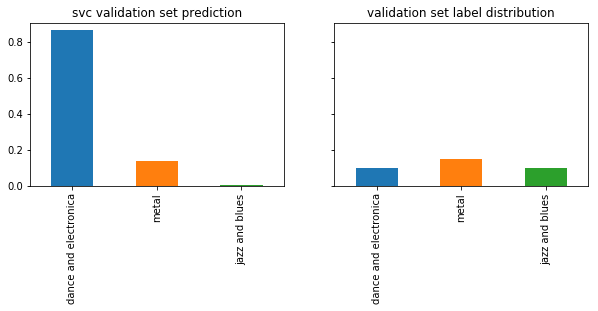

In [126]:
pred = svc.predict(valid_meta_audio_pca)
print(classification_report(valid_labels, pred, target_names=valid_labels["genre"].unique()))
draw_train_valid_label_distribution(pd.DataFrame(pred, columns=valid_labels.columns, index=valid_meta_audio_pca.index), 
                                    valid_labels,
                                    title1="svc validation set prediction")

### test

In [127]:
# rf

models = [svc]
test_preds = predict(models, test_meta_audio_pca)
test_preds[0].reset_index(level=0).to_csv(path_or_buf="test_pred.csv", columns=["trackID", "genre"], index=False)

## svc, rbf (0.45312), poly (0.38281)

In [136]:
train_svc = train_continuous_meta_audio
valid_svc = select_df1_columns_based_on_df2(one_hot_encoding(valid_features, "key"), 
                                                            train_continuous_meta_audio)

svc = make_pipeline(StandardScaler(),
                    SVC(random_state=RANDOM_STATE, 
                        tol=1e-5,
                        max_iter=10000
                        #,kernel="poly"
                       ))
svc.fit(train_svc, train_labels.values.ravel())

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(max_iter=10000, random_state=90049, tol=1e-05))])

                       precision    recall  f1-score   support

      soul and reggae       0.26      0.67      0.38        55
 classic pop and rock       0.74      0.31      0.44        45
                metal       0.34      0.58      0.43        64
                 folk       1.00      0.27      0.43        44
                  pop       0.93      0.58      0.71        66
dance and electronica       0.77      0.23      0.35        74
       jazz and blues       0.44      0.52      0.48        44
                 punk       0.80      0.76      0.78        58

             accuracy                           0.49       450
            macro avg       0.66      0.49      0.50       450
         weighted avg       0.66      0.49      0.50       450



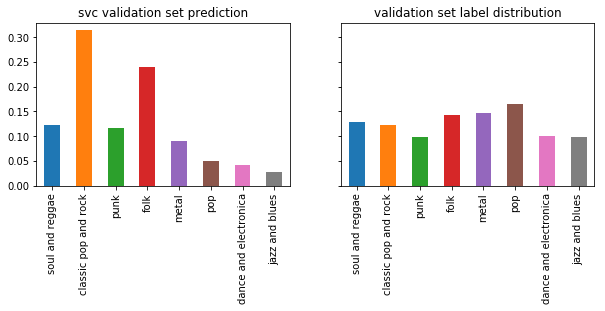

In [137]:
pred = svc.predict(valid_svc)
print(classification_report(valid_labels, pred, target_names=valid_labels["genre"].unique()))
draw_train_valid_label_distribution(pd.DataFrame(pred, columns=valid_labels.columns, index=valid_svc.index), 
                                    valid_labels,
                                    title1="svc validation set prediction")

### test

In [135]:
# rf

models = [svc]
test_knn = select_df1_columns_based_on_df2(one_hot_encoding(test_features, "key"),
                                            train_svc)
# test_knn = transform_continuous_0_1(test_knn)
test_preds = predict(models, test_knn)
test_preds[0].reset_index(level=0).to_csv(path_or_buf="test_pred.csv", columns=["trackID", "genre"], index=False)

## svc, tag+meta+audio (0.5390)

In [92]:
svc = make_pipeline(StandardScaler(),
                    SVC(random_state=RANDOM_STATE, 
                        tol=1e-5,
                        max_iter=10000
                        #,kernel="poly"
                       ))
svc.fit(train_features_all, train_labels.values.ravel())

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=10000, probability=False, random_state=90049, shrinking=True,
  tol=1e-05, verbose=False))])

                       precision    recall  f1-score   support

      soul and reggae       0.41      0.67      0.51        55
 classic pop and rock       0.38      0.07      0.11        45
                metal       0.43      0.70      0.54        64
                 folk       1.00      0.02      0.04        44
                  pop       0.92      0.73      0.81        66
dance and electronica       0.94      0.85      0.89        74
       jazz and blues       0.52      0.91      0.66        44
                 punk       0.84      0.74      0.79        58

          avg / total       0.70      0.62      0.59       450



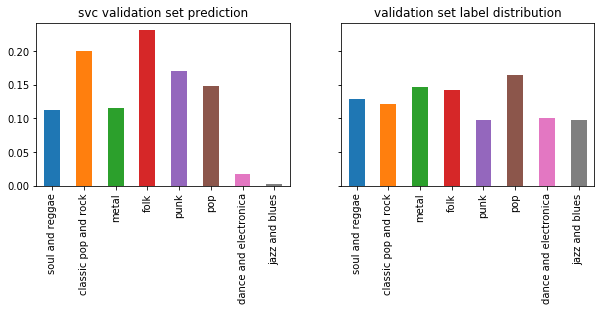

In [27]:
pred = svc.predict(valid_features_all)
print(classification_report(valid_labels, pred, target_names=valid_labels["genre"].unique()))
draw_train_valid_label_distribution(pd.DataFrame(pred, columns=valid_labels.columns, index=valid_features_all.index), 
                                    valid_labels,
                                    title1="svc validation set prediction")

### test

In [28]:
# rf

models = [svc]

test_preds = predict(models, test_features_all)
test_preds[0].reset_index(level=0).to_csv(path_or_buf="test_pred.csv", columns=["trackID", "genre"], index=False)

## dt, tag+meta+audio (0.41406)

In [36]:
train_dt = train_features_all
valid_dt = valid_features_all

dt = DecisionTreeClassifier(criterion="entropy",
                            random_state=RANDOM_STATE,
                            max_depth=2000)

dt_f1s = []
ds = [i for i in range(1, 65)] #len(train_dt.columns))]
for d in ds:
    dt.set_params(max_depth=d)

    dt.fit(train_dt, train_labels.values.ravel())
    pred = dt.predict(valid_dt)
    
    _, _, pref = evaluate(pred, valid_labels)
    dt_f1s.append(pref[2])
    
    print(d, pref[2])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


1 0.11209563612679116


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


2 0.26173952627224756


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


3 0.3801450182937893


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


4 0.3887827974575011


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


5 0.37920566182205206


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


6 0.401425573590666
7 0.42239896446421743
8 0.4364748276718482
9 0.43864347393995823
10 0.45223345832877815
11 0.43631760372570394
12 0.4453217673443498
13 0.4380025693127274
14 0.4443589582196404
15 0.4312217735087859
16 0.4446769409610957
17 0.4340922674803349
18 0.45155141170365076
19 0.434260399759439
20 0.4440516244974364
21 0.44263390586243434
22 0.45135966392694715
23 0.45135966392694715
24 0.45135966392694715
25 0.45135966392694715
26 0.45135966392694715
27 0.45135966392694715
28 0.45135966392694715
29 0.45135966392694715
30 0.45135966392694715
31 0.45135966392694715
32 0.45135966392694715
33 0.45135966392694715
34 0.45135966392694715
35 0.45135966392694715
36 0.45135966392694715
37 0.45135966392694715
38 0.45135966392694715
39 0.45135966392694715
40 0.45135966392694715
41 0.45135966392694715
42 0.45135966392694715
43 0.45135966392694715
44 0.45135966392694715
45 0.45135966392694715
46 0.45135966392694715
47 0.45135966392694715
48 0.45135966392694715
49 0.45135966392694715
50 0

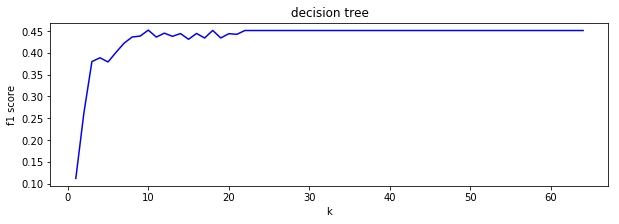

max_depth maximize f1-score : 10 with 0.45223345832877815


In [37]:
draw_k_line_chart(ds, dt_f1s, "f1 score", "decision tree")
dt_best_max_depth = ds[np.argmax(dt_f1s)]
print("max_depth maximize f1-score :", dt_best_max_depth, "with", dt_f1s[np.argmax(dt_f1s)])

### test

In [39]:
# rf

models = [dt]
test_knn = test_features_all
test_preds = predict(models, test_knn)
test_preds[0].reset_index(level=0).to_csv(path_or_buf="test_pred.csv", columns=["trackID", "genre"], index=False)

## rf, n_estimators=2000, max depth=10, tag+meta+audio (0.53125)

In [53]:
train_rf = train_features_all
valid_rf = valid_features_all

In [54]:
rf = RandomForestClassifier(n_estimators = 2000, 
                         random_state=RANDOM_STATE, 
                         criterion="entropy",
                         max_depth=10)
rf.fit(train_rf, train_labels.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=1,
            oob_score=False, random_state=90049, verbose=0,
            warm_start=False)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                       precision    recall  f1-score   support

      soul and reggae       0.39      0.49      0.43        55
 classic pop and rock       1.00      0.09      0.16        45
                metal       0.30      0.72      0.42        64
                 folk       0.00      0.00      0.00        44
                  pop       0.89      0.89      0.89        66
dance and electronica       0.95      0.97      0.96        74
       jazz and blues       0.72      0.64      0.67        44
                 punk       0.79      0.57      0.66        58

          avg / total       0.65      0.60      0.57       450



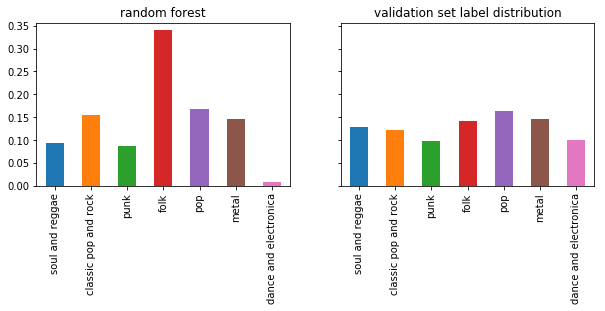

In [55]:
pred = rf.predict(valid_rf)
_, _, pref = evaluate(pred, valid_labels)
print(classification_report(valid_labels, pred, target_names=valid_labels["genre"].unique()))

draw_train_valid_label_distribution(pd.DataFrame(pred, columns=valid_labels.columns, index=valid_rf.index), 
                                    valid_labels,
                                    title1="random forest")

### test

In [57]:
# rf

models = [rf]
test_knn = test_features_all
test_preds = predict(models, test_knn)
test_preds[0].reset_index(level=0).to_csv(path_or_buf="test_pred.csv", columns=["trackID", "genre"], index=False)

## rf, rf selected all (0.55468)

In [85]:
rf = RandomForestClassifier(n_estimators = 1000, 
                         random_state=RANDOM_STATE, 
                         criterion="entropy",
                         )
rf.fit(train_all_rf_selected, train_labels.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=90049, verbose=0,
            warm_start=False)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                       precision    recall  f1-score   support

      soul and reggae       0.46      0.67      0.54        55
 classic pop and rock       1.00      0.18      0.30        45
                metal       0.36      0.66      0.47        64
                 folk       0.00      0.00      0.00        44
                  pop       0.91      0.80      0.85        66
dance and electronica       0.91      0.99      0.95        74
       jazz and blues       0.65      0.68      0.67        44
                 punk       0.75      0.79      0.77        58

          avg / total       0.65      0.64      0.61       450



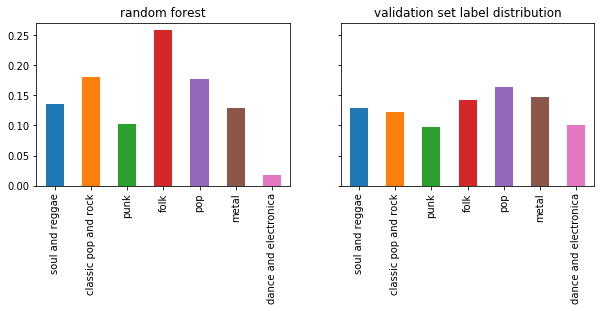

In [86]:
pred = rf.predict(valid_all_rf_selected)
_, _, pref = evaluate(pred, valid_labels)
print(classification_report(valid_labels, pred, target_names=valid_labels["genre"].unique()))

draw_train_valid_label_distribution(pd.DataFrame(pred, columns=valid_labels.columns, index=valid_all_rf_selected.index), 
                                    valid_labels,
                                    title1="random forest")

### test

In [87]:
# rf

models = [rf]
test_preds = predict(models, test_all_rf_selected)
test_preds[0].reset_index(level=0).to_csv(path_or_buf="test_pred.csv", columns=["trackID", "genre"], index=False)

## linear svc, rf selected (0.49218)

In [88]:
svc = make_pipeline(StandardScaler(),
                    LinearSVC(random_state=RANDOM_STATE, 
                              tol=1e-5,
                              max_iter=10000))
svc.fit(train_all_rf_selected, train_labels.values.ravel())

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearsvc', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=10000,
     multi_class='ovr', penalty='l2', random_state=90049, tol=1e-05,
     verbose=0))])

                       precision    recall  f1-score   support

      soul and reggae       0.33      0.44      0.38        55
 classic pop and rock       0.29      0.20      0.24        45
                metal       0.56      0.66      0.60        64
                 folk       0.38      0.30      0.33        44
                  pop       0.64      0.76      0.69        66
dance and electronica       0.84      0.76      0.79        74
       jazz and blues       0.55      0.52      0.53        44
                 punk       0.63      0.55      0.59        58

          avg / total       0.55      0.55      0.55       450



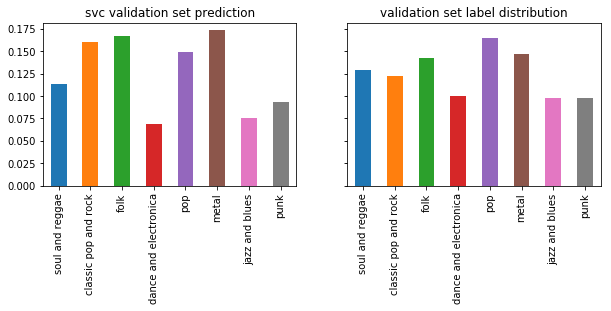

In [89]:
pred = svc.predict(valid_all_rf_selected)
print(classification_report(valid_labels, pred, target_names=valid_labels["genre"].unique()))
draw_train_valid_label_distribution(pd.DataFrame(pred, columns=valid_labels.columns, index=valid_all_rf_selected.index), 
                                    valid_labels,
                                    title1="svc validation set prediction")

### test

In [93]:
# rf
test_preds = predict(models, test_all_rf_selected)
test_preds[0].reset_index(level=0).to_csv(path_or_buf="test_pred.csv", columns=["trackID", "genre"], index=False)

## linear svc, all (0.49218)

In [21]:
svc = make_pipeline(StandardScaler(),
                    LinearSVC(random_state=RANDOM_STATE, 
                              tol=1e-5,
                              max_iter=10000))
svc.fit(train_all, train_labels.values.ravel())

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearsvc', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=10000,
     multi_class='ovr', penalty='l2', random_state=90049, tol=1e-05,
     verbose=0))])

                       precision    recall  f1-score   support

      soul and reggae       0.31      0.44      0.36        55
 classic pop and rock       0.38      0.11      0.17        45
                metal       0.42      0.52      0.46        64
                 folk       0.27      0.20      0.23        44
                  pop       0.90      0.67      0.77        66
dance and electronica       0.84      1.00      0.91        74
       jazz and blues       0.76      0.84      0.80        44
                 punk       0.44      0.47      0.45        58

          avg / total       0.56      0.56      0.55       450



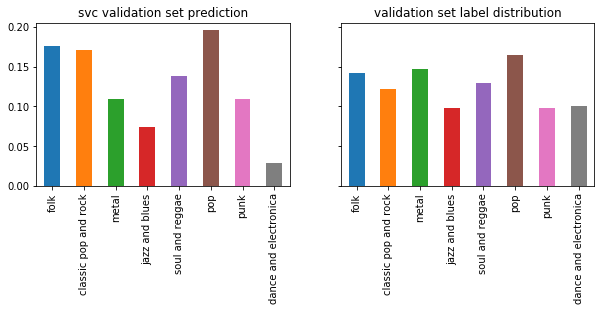

In [24]:
pred = svc.predict(valid_all)
print(classification_report(valid_labels, pred, target_names=valid_labels["genre"].unique()))
draw_train_valid_label_distribution(pd.DataFrame(pred, columns=valid_labels.columns, index=valid_all.index), 
                                    valid_labels,
                                    title1="svc validation set prediction")

### test

In [27]:
# rf
models = [svc]

test_preds = predict(models, test_all)
test_preds[0].reset_index(level=0).to_csv(path_or_buf="test_pred.csv", columns=["trackID", "genre"], index=False)

## Gaussian NB, tag+meta+audio, drop numbered tag (0.36718)

In [43]:
clf = GaussianNB()
clf.fit(train_alpha_tags_all, train_labels.values.ravel())

GaussianNB(priors=None)

                       precision    recall  f1-score   support

      soul and reggae       0.13      0.15      0.14        55
 classic pop and rock       0.13      0.13      0.13        45
                metal       0.35      0.11      0.17        64
                 folk       0.13      0.16      0.14        44
                  pop       0.45      0.58      0.50        66
dance and electronica       0.89      0.97      0.93        74
       jazz and blues       0.76      0.64      0.69        44
                 punk       0.28      0.31      0.30        58

          avg / total       0.41      0.41      0.40       450



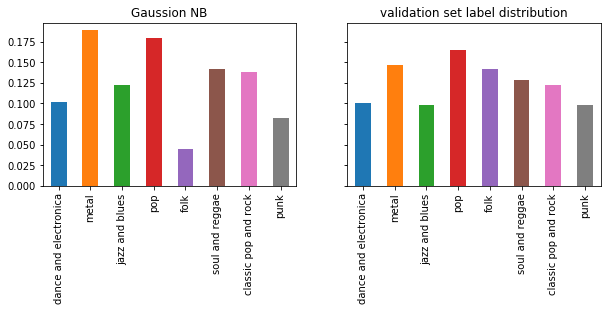

In [44]:
pred = clf.predict(valid_alpha_tags_all)
_, _, pref = evaluate(pred, valid_labels)
print(classification_report(valid_labels, pred, target_names=valid_labels["genre"].unique()))

draw_train_valid_label_distribution(pd.DataFrame(pred, columns=valid_labels.columns, index=valid_alpha_tags_all.index), 
                                    valid_labels,
                                    title1="Gaussion NB")

### test

In [46]:
# rf

models = [clf]
test_preds = predict(models, test_alpha_tags_all)
test_preds[0].reset_index(level=0).to_csv(path_or_buf="test_pred.csv", columns=["trackID", "genre"], index=False)

## gradient ada boosting tag+meta+audio (too slow)

In [ ]:
# gb_clf = GradientBoostingClassifier(n_estimators=100, 
#                                     learning_rate=1.0, 
#                                     max_depth=10, 
#                                     random_state=RANDOM_STATE,
#                                     loss="deviance"
#                                     )

# ns = []
# f1s = []
# for i in range(1, 10):
#     print(i)
#     ns.append(i)
#     gb_clf.set_params(n_estimators=i)
#     gb_clf.fit(train_features_all, train_labels.values.ravel())
#     pred = gb_clf.predict(valid_features_all)
#     _, _, pref = evaluate(pred, valid_labels.values.ravel())
#     f1s.append(pref[2])

In [ ]:
# draw_k_line_chart(ns, f1s, "f1 score", "decision tree")
# gb_best_n_estimators = ns[np.argmax(f1s)]
# print("n_estimators maximize f1-score :", gb_best_n_estimators, "with", f1s[np.argmax(f1s)])

## ada boosted gaussian nb,  ns=3,tag+meta+audio (0.58593)

### bosting hyper parameter tuning

In [30]:
def draw_train_valid_score(xs, train_ys, valid_ys, title="", xlabel="", ylabel=""):
    plt.figure(figsize=(10, 3))
    plt.plot(xs, train_ys, 'b-')
    plt.plot(xs, valid_ys, 'r-')
    plt.legend(["train " + ylabel, "valid " + ylabel])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

In [ ]:
gnb_ada_discrete = AdaBoostClassifier(
    GaussianNB(),
    n_estimators=21,
    learning_rate=1,
    algorithm="SAMME",
    random_state=RANDOM_STATE)

ns = []
train_f1s = []
valid_f1s = []
for i in range(1, 101):
    ns.append(i)
    gnb_ada_discrete.set_params(n_estimators=i)
    gnb_ada_discrete.fit(train_features_all, train_labels.values.ravel())
    
    pred = gnb_ada_discrete.predict(valid_features_all)
    _, _, pref = evaluate(pred, valid_labels.values.ravel())
    valid_f1s.append(pref[2])
    
    pred = gnb_ada_discrete.predict(train_features_all)
    _, _, pref = evaluate(pred, train_labels.values.ravel())
    train_f1s.append(pref[2])
    
    print(i, train_f1s[-1], valid_f1s[-1])

1 0.5235758765917979 0.5699485294842342
2 0.5235758765917979 0.5699485294842342
3 0.6112792534294551 0.6274171810631145
4 0.5981330943806382 0.5720818442999921
5 0.6434964268903229 0.6088914451492471
6 0.6232918860282703 0.5870180094454803
7 0.6533017700611297 0.586141205754767
8 0.6755161230716675 0.6012159400406085
9 0.68250203978364 0.6024181810899079
10 0.7264499827796489 0.6099348581487581
11 0.7122465265041764 0.6106823659695721
12 0.7377627229508752 0.6010183746730553
13 0.7218878079903013 0.5964640362739025
14 0.748373209349539 0.6105553392332977
15 0.7323302232931574 0.6082654996959151
16 0.760070988728541 0.5983946540094234
17 0.7417807404907599 0.6030709968057292
18 0.7729993079153785 0.6107321254738531
19 0.7579872765249751 0.6082297060856792
20 0.7646580063401056 0.5957812314361688
21 0.7699965931256343 0.6126737617353932
22 0.7692797621659428 0.594440595660792
23 0.7827932729222358 0.5902423632101123
24 0.7800083965076553 0.5782618584675191
25 0.7875332512591642 0.5830731

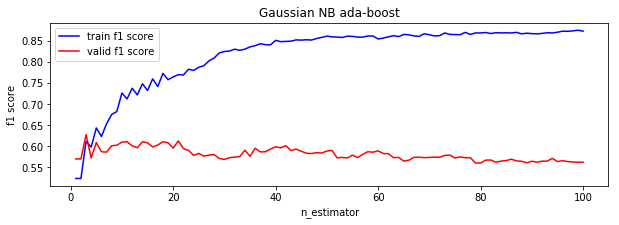

In [50]:
draw_train_valid_score(ns, train_f1s, valid_f1s, 
                       title="Gaussian NB ada-boost",
                       xlabel="n_estimator",
                       ylabel="f1 score"
                      )

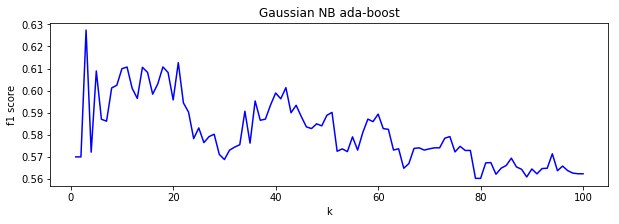

n_estimators maximize f1-score : 3 with 0.6274171810631145


In [54]:
draw_k_line_chart(ns, valid_f1s, "f1 score", "Gaussian NB ada-boost")
gnb_best_n_estimators = ns[np.argmax(valid_f1s)]
print("n_estimators maximize f1-score :", gnb_best_n_estimators, "with", valid_f1s[np.argmax(valid_f1s)])

### train valid

In [84]:
gnb_ada_discrete.set_params(n_estimators=gnb_best_n_estimators)
gnb_ada_discrete.fit(train_features_all, train_labels.values.ravel())

AdaBoostClassifier(algorithm='SAMME', base_estimator=GaussianNB(priors=None),
          learning_rate=1, n_estimators=3, random_state=90049)

0.6274171810631145
                       precision    recall  f1-score   support

      soul and reggae       0.37      0.42      0.39        55
 classic pop and rock       0.58      0.24      0.34        45
                metal       0.72      0.44      0.54        64
                 folk       0.41      0.66      0.51        44
                  pop       0.83      0.83      0.83        66
dance and electronica       0.91      0.99      0.95        74
       jazz and blues       0.85      0.64      0.73        44
                 punk       0.62      0.86      0.72        58

          avg / total       0.68      0.66      0.65       450



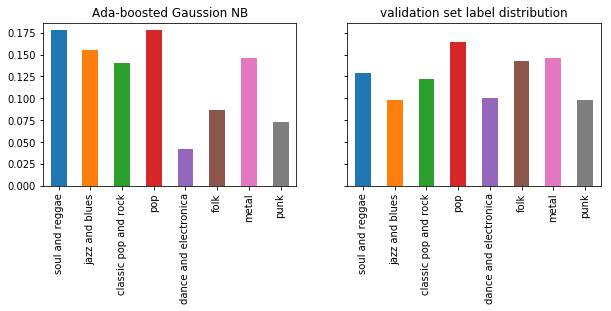

In [85]:
pred = gnb_ada_discrete.predict(valid_features_all)
_, _, pref = evaluate(pred, valid_labels)
print(pref[2])
print(classification_report(valid_labels, pred, target_names=valid_labels["genre"].unique()))
draw_train_valid_label_distribution(pd.DataFrame(pred, columns=valid_labels.columns, index=valid_features_all.index), 
                                    valid_labels,
                                    title1="Ada-boosted Gaussion NB")

### test

In [86]:
# rf

models = [gnb_ada_discrete]
test_preds = predict(models, test_features_all)
test_preds[0].reset_index(level=0).to_csv(path_or_buf="test_pred.csv", columns=["trackID", "genre"], index=False)

## ada boosted gaussian nb, ns=,tag+meta+audio v2 ()

0.08883935748170389
                       precision    recall  f1-score   support

 classic pop and rock       0.08      0.04      0.05        55
dance and electronica       0.07      0.36      0.12        45
                 folk       0.12      0.17      0.14        64
       jazz and blues       0.00      0.00      0.00        44
                metal       0.00      0.00      0.00        66
                  pop       0.19      0.15      0.17        74
                 punk       0.17      0.11      0.14        44
      soul and reggae       0.50      0.05      0.09        58

             accuracy                           0.11       450
            macro avg       0.14      0.11      0.09       450
         weighted avg       0.15      0.11      0.09       450



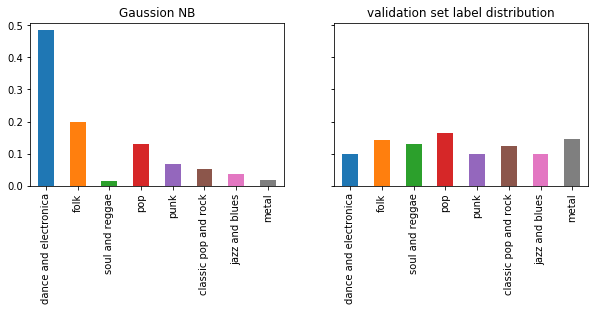

In [214]:
clf = GaussianNB()
clf.fit(train_features_all2, train_labels.values.ravel())
pred = clf.predict(valid_features_all2)
_, _, pref = evaluate(pred, valid_labels)
print(pref[2])
print(classification_report(valid_labels, pred, target_names=clf.classes_))
draw_train_valid_label_distribution(pd.DataFrame(pred, columns=valid_labels.columns, index=valid_features_all2.index), 
                                    valid_labels,
                                    title1="Gaussion NB")

### hyper parameter tuning

In [208]:
gnb_ada_discrete = AdaBoostClassifier(
    GaussianNB(),
    n_estimators=21,
    learning_rate=1,
    algorithm="SAMME",
    random_state=RANDOM_STATE)

ns = []
train_f1s = []
valid_f1s = []
for i in range(1, 11):
    ns.append(i)
    gnb_ada_discrete.set_params(n_estimators=i)
    gnb_ada_discrete.fit(train_features_all2, train_labels.values.ravel())
    
    pred = gnb_ada_discrete.predict(valid_features_all2)
    _, _, pref = evaluate(pred, valid_labels.values.ravel())
    valid_f1s.append(pref[2])
    
    pred = gnb_ada_discrete.predict(train_features_all2)
    _, _, pref = evaluate(pred, train_labels.values.ravel())
    train_f1s.append(pref[2])
    
    print(i, train_f1s[-1], valid_f1s[-1])

1 0.33617531356492586 0.08883935748170389
2 0.33617531356492586 0.08883935748170389


KeyboardInterrupt: 

In [ ]:
draw_train_valid_score(ns, train_f1s, valid_f1s, 
                       title="Gaussian NB ada-boost",
                       xlabel="n_estimator",
                       ylabel="f1 score"
                      )

In [ ]:
draw_k_line_chart(ns, valid_f1s, "f1 score", "Gaussian NB ada-boost")
gnb_best_n_estimators = ns[np.argmax(valid_f1s)]
print("n_estimators maximize f1-score :", gnb_best_n_estimators, "with", valid_f1s[np.argmax(valid_f1s)])

### train valid

In [ ]:
gnb_ada_discrete.set_params(n_estimators=gnb_best_n_estimators)
gnb_ada_discrete.fit(train_features_all2, train_labels.values.ravel())

In [ ]:
pred = gnb_ada_discrete.predict(valid_features_all2)
_, _, pref = evaluate(pred, valid_labels)
print(pref[2])
print(classification_report(valid_labels, pred, target_names=valid_labels["genre"].unique()))
draw_train_valid_label_distribution(pd.DataFrame(pred, columns=valid_labels.columns, index=valid_features_all2.index), 
                                    valid_labels,
                                    title1="Ada-boosted Gaussion NB")

### test

In [ ]:
# rf

models = [gnb_ada_discrete]
test_preds = predict(models, test_features_all2)
test_preds[0].reset_index(level=0).to_csv(path_or_buf="test_pred.csv", columns=["trackID", "genre"], index=False)

## ada boosted gaussian nb, ns=5,tag+meta+audio, learning_rate=0.5 (0.57812)

### bosting hyper parameter tuning

In [86]:
gnb_ada_discrete2 = AdaBoostClassifier(
    GaussianNB(),
    n_estimators=21,
    learning_rate=0.5,
    algorithm="SAMME",
    random_state=RANDOM_STATE)

ns2 = []
train_f1s_2 = []
valid_f1s_2 = []
for i in range(1, 21):
    ns2.append(i)
    gnb_ada_discrete2.set_params(n_estimators=i)
    gnb_ada_discrete2.fit(train_features_all, train_labels.values.ravel())
    
    pred = gnb_ada_discrete2.predict(valid_features_all)
    _, _, pref = evaluate(pred, valid_labels.values.ravel())
    valid_f1s_2.append(pref[2])
    
    pred = gnb_ada_discrete2.predict(train_features_all)
    _, _, pref = evaluate(pred, train_labels.values.ravel())
    train_f1s_2.append(pref[2])
    
    print(i, train_f1s_2[-1], valid_f1s_2[-1])

1 0.5235758765917979 0.5699485294842342
2 0.5235758765917979 0.5699485294842342
3 0.6194045184333028 0.6030963254246846
4 0.6454999372665546 0.6219713327273829
5 0.6945286073601681 0.6317004365177764
6 0.698511582141312 0.6289740105363146
7 0.710706030852984 0.6041788318131514
8 0.7055893881195955 0.613625146318296
9 0.7132515049881426 0.6247034610018795
10 0.7224958649562911 0.6307477936751746
11 0.7238807043915703 0.6260721559190816
12 0.734030793767542 0.6229853241848384
13 0.7385621529967367 0.6282128780696654
14 0.7452513715243003 0.617073541700544
15 0.7421632254503726 0.6155355830093003
16 0.7577693859738039 0.6233047580128854
17 0.755206200770377 0.6227892734400771
18 0.7614278916231381 0.610856774057923
19 0.7572509319921136 0.6166946264038119
20 0.7669654186569026 0.6090849063329699


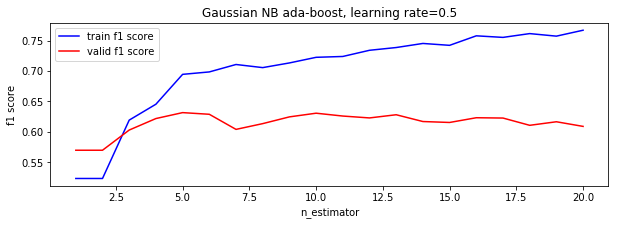

In [90]:
draw_train_valid_score(ns2, train_f1s_2, valid_f1s_2, 
                       title="Gaussian NB ada-boost, learning rate=0.5",
                       xlabel="n_estimator",
                       ylabel="f1 score"
                      )

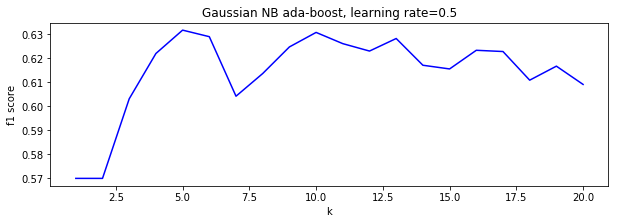

n_estimators maximize f1-score : 5 with 0.6317004365177764


In [99]:
draw_k_line_chart(ns2, valid_f1s_2, "f1 score", "Gaussian NB ada-boost, learning rate=0.5")
gnb_best_n_estimators_2 = ns2[np.argmax(valid_f1s_2)]
print("n_estimators maximize f1-score :", gnb_best_n_estimators_2, "with", valid_f1s_2[np.argmax(valid_f1s_2)])

### train valid

In [100]:
gnb_ada_discrete2.set_params(n_estimators=gnb_best_n_estimators_2)
gnb_ada_discrete2.fit(train_features_all, train_labels.values.ravel())

AdaBoostClassifier(algorithm='SAMME', base_estimator=GaussianNB(),
                   learning_rate=0.5, n_estimators=5, random_state=90049)

0.6317004365177764
                       precision    recall  f1-score   support

      soul and reggae       0.40      0.38      0.39        55
 classic pop and rock       0.53      0.20      0.29        45
                metal       0.74      0.53      0.62        64
                 folk       0.44      0.59      0.50        44
                  pop       0.86      0.85      0.85        66
dance and electronica       0.89      0.99      0.94        74
       jazz and blues       0.86      0.68      0.76        44
                 punk       0.56      0.91      0.70        58

             accuracy                           0.67       450
            macro avg       0.66      0.64      0.63       450
         weighted avg       0.68      0.67      0.66       450



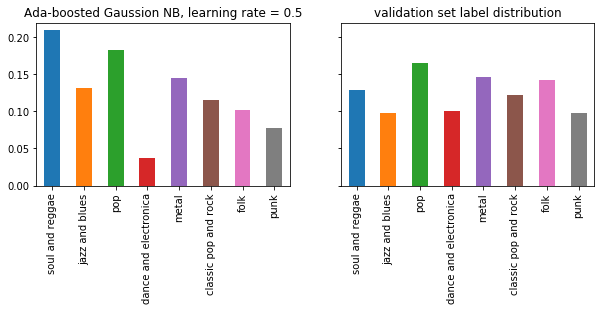

In [101]:
pred = gnb_ada_discrete2.predict(valid_features_all)
_, _, pref = evaluate(pred, valid_labels)
print(pref[2])
print(classification_report(valid_labels, pred, target_names=valid_labels["genre"].unique()))
draw_train_valid_label_distribution(pd.DataFrame(pred, columns=valid_labels.columns, index=valid_features_all.index), 
                                    valid_labels,
                                    title1="Ada-boosted Gaussion NB, learning rate = 0.5")

### test

In [102]:
# rf

models = [gnb_ada_discrete2]
test_preds = predict(models, test_features_all)
test_preds[0].reset_index(level=0).to_csv(path_or_buf="test_pred.csv", columns=["trackID", "genre"], index=False)

## bagging ada boosted gaussian nb, ns=5,tag+meta+audio, learning_rate=0.5 (0.55468)

In [ ]:
bagging_ada_gaussian_nb_clf_2 = BaggingClassifier(base_estimator=AdaBoostClassifier(
                                                            GaussianNB(),
                                                            n_estimators=5,
                                                            learning_rate=0.5,
                                                            algorithm="SAMME",
                                                            random_state=RANDOM_STATE),
                            n_estimators=10, 
                            random_state=RANDOM_STATE)

ns_ada_bagging_2 = []
train_ada_bagging_f1s_2 = []
valid_ada_bagging_f1s_2 = []

In [105]:
for i in range(1, 26):
    ns_ada_bagging_2.append(i)
    bagging_ada_gaussian_nb_clf_2.set_params(n_estimators=i)
    bagging_ada_gaussian_nb_clf_2.fit(train_features_all, train_labels.values.ravel())
    
    pred = bagging_ada_gaussian_nb_clf_2.predict(valid_features_all)
    _, _, pref = evaluate(pred, valid_labels.values.ravel())
    valid_ada_bagging_f1s_2.append(pref[2])
    
    pred = bagging_ada_gaussian_nb_clf_2.predict(train_features_all)
    _, _, pref = evaluate(pred, train_labels.values.ravel())
    train_ada_bagging_f1s_2.append(pref[2])
    
    print(i, train_ada_bagging_f1s_2[-1], valid_ada_bagging_f1s_2[-1])

1 0.6392707714451143 0.5905223632310178
2 0.638623401400378 0.5915114529694483
3 0.6406241441754177 0.6052353872031557
4 0.6433345805570961 0.6109661384807267
5 0.6481857170325902 0.6086714150610616
6 0.6509262002313922 0.6170430794229549
7 0.6497481951911558 0.6248433420075684
8 0.6532260820995819 0.6281858270998842
9 0.6555216205002434 0.6293925896972083
10 0.6503434945155526 0.6252771444915417
11 0.6493704032848339 0.634898498533083
12 0.6453862988229885 0.6335995439700313
13 0.6446223008488607 0.6321385655952891
14 0.643718956011986 0.6273387652724084
15 0.6456949896923554 0.6289188118971321
16 0.6478433474853842 0.6319329066352375
17 0.6502255292144596 0.6364906390452735
18 0.6527335855021527 0.6277266146261831
19 0.6531841097653537 0.6335067818993626
20 0.6523533117455454 0.6370189329975031
21 0.653496771219306 0.6335843262194794
22 0.6508955513022474 0.6269911975776649
23 0.6508669537653 0.6327128531814092
24 0.652755748007731 0.6292546874774179
25 0.6503834211581833 0.627122483

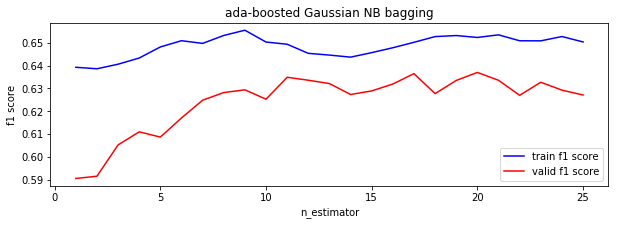

In [106]:
draw_train_valid_score(ns_ada_bagging_2, train_ada_bagging_f1s_2, valid_ada_bagging_f1s_2, 
                       title="ada-boosted Gaussian NB bagging",
                       xlabel="n_estimator",
                       ylabel="f1 score"
                      )

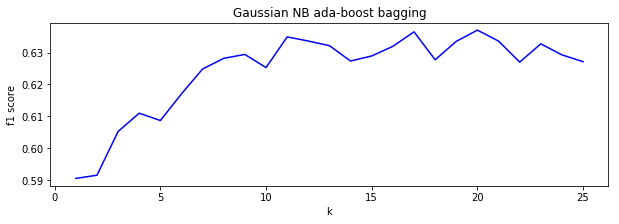

n_estimators maximize f1-score : 20 with 0.6370189329975031


In [107]:
draw_k_line_chart(ns_ada_bagging_2, valid_ada_bagging_f1s_2, "f1 score", "Gaussian NB ada-boost bagging")
bagging_ada_gaussian_nb_best_n_estimators_2 = ns_bagging[np.argmax(valid_ada_bagging_f1s_2)]
print("n_estimators maximize f1-score :", bagging_ada_gaussian_nb_best_n_estimators_2, 
      "with", valid_ada_bagging_f1s_2[np.argmax(valid_ada_bagging_f1s_2)])

### train valid

In [112]:
bagging_ada_gaussian_nb_clf_2.set_params(n_estimators=17)
bagging_ada_gaussian_nb_clf_2.fit(train_features_all, train_labels.values.ravel())

BaggingClassifier(base_estimator=AdaBoostClassifier(algorithm='SAMME',
                                                    base_estimator=GaussianNB(),
                                                    learning_rate=0.5,
                                                    n_estimators=5,
                                                    random_state=90049),
                  n_estimators=17, random_state=90049)

0.6364906390452735
                       precision    recall  f1-score   support

      soul and reggae       0.38      0.38      0.38        55
 classic pop and rock       0.67      0.27      0.38        45
                metal       0.76      0.41      0.53        64
                 folk       0.41      0.70      0.52        44
                  pop       0.86      0.86      0.86        66
dance and electronica       0.94      0.99      0.96        74
       jazz and blues       0.86      0.68      0.76        44
                 punk       0.57      0.88      0.69        58

             accuracy                           0.67       450
            macro avg       0.68      0.65      0.64       450
         weighted avg       0.70      0.67      0.66       450



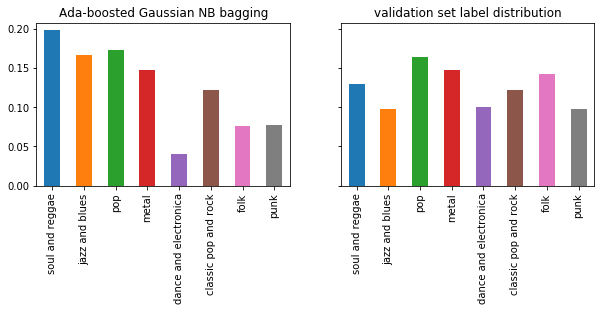

In [113]:
pred = bagging_ada_gaussian_nb_clf_2.predict(valid_features_all)
_, _, pref = evaluate(pred, valid_labels)
print(pref[2])
print(classification_report(valid_labels, pred, target_names=valid_labels["genre"].unique()))
draw_train_valid_label_distribution(pd.DataFrame(pred, columns=valid_labels.columns, index=valid_features_all.index), 
                                    valid_labels,
                                    title1="Ada-boosted Gaussian NB bagging")

### test

In [114]:
# rf

models = [bagging_ada_gaussian_nb_clf_2]
test_preds = predict(models, test_features_all)
test_preds[0].reset_index(level=0).to_csv(path_or_buf="test_pred.csv", columns=["trackID", "genre"], index=False)

## ada boosted gaussian nb, ns=3,tag+meta+audio, learning_rate=0.1 ()

In [ ]:
gnb_ada_discrete3 = AdaBoostClassifier(
    GaussianNB(),
    n_estimators=31,
    learning_rate=0.1,
    algorithm="SAMME",
    random_state=RANDOM_STATE)

ns3 = []
train_f1s_3 = []
valid_f1s_3 = []

In [94]:
for i in range(23, 33):
    ns3.append(i)
    gnb_ada_discrete3.set_params(n_estimators=i)
    gnb_ada_discrete3.fit(train_features_all, train_labels.values.ravel())
    
    pred = gnb_ada_discrete3.predict(valid_features_all)
    _, _, pref = evaluate(pred, valid_labels.values.ravel())
    valid_f1s_3.append(pref[2])
    
    pred = gnb_ada_discrete3.predict(train_features_all)
    _, _, pref = evaluate(pred, train_labels.values.ravel())
    train_f1s_3.append(pref[2])
    
    print(i, train_f1s_3[-1], valid_f1s_3[-1])

23 0.6912441896220147 0.6212963656495751
24 0.6930895957443823 0.6239317103243933
25 0.6955284552243179 0.6241155226968866
26 0.7012919699657431 0.6171881051760277
27 0.7030771700993341 0.6154227939844872
28 0.7065098244872123 0.6177369820992054
29 0.7130772702445305 0.6158645218947091
30 0.7163895951501981 0.6179865334788206
31 0.7184029460949347 0.6180887381733442
32 0.7192024891982252 0.6201797876455539


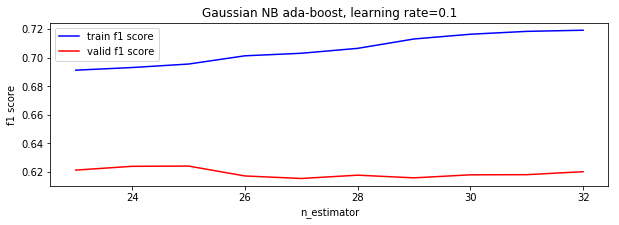

In [95]:
draw_train_valid_score(ns3, train_f1s_3, valid_f1s_3, 
                       title="Gaussian NB ada-boost, learning rate=0.1",
                       xlabel="n_estimator",
                       ylabel="f1 score"
                      )

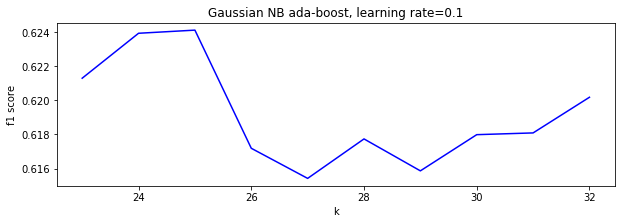

n_estimators maximize f1-score : 25 with 0.6241155226968866


In [96]:
draw_k_line_chart(ns3, valid_f1s_3, "f1 score", "Gaussian NB ada-boost, learning rate=0.1")
gnb_best_n_estimators_3 = ns3[np.argmax(valid_f1s_3)]
print("n_estimators maximize f1-score :", gnb_best_n_estimators_3, "with", valid_f1s_3[np.argmax(valid_f1s_3)])

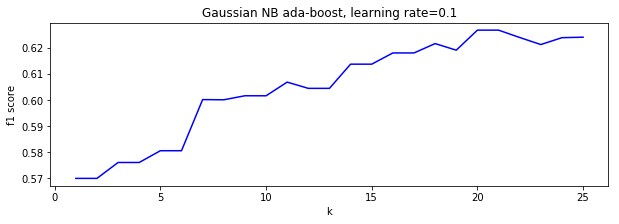

n_estimators maximize f1-score : 20 with 0.6268252436087329


In [93]:
draw_k_line_chart(ns3, valid_f1s_3, "f1 score", "Gaussian NB ada-boost, learning rate=0.1")
gnb_best_n_estimators_3 = ns3[np.argmax(valid_f1s_3)]
print("n_estimators maximize f1-score :", gnb_best_n_estimators_3, "with", valid_f1s_3[np.argmax(valid_f1s_3)])

## ada boosted gaussian nb, ns=3,tag+meta+audio, learning_rate=0.05 ()

In [85]:
gnb_ada_discrete4 = AdaBoostClassifier(
    GaussianNB(),
    n_estimators=31,
    learning_rate=0.05,
    algorithm="SAMME",
    random_state=RANDOM_STATE)

ns4 = []
train_f1s_4 = []
valid_f1s_4 = []
for i in range(1, 31):
    ns4.append(i)
    gnb_ada_discrete4.set_params(n_estimators=i)
    gnb_ada_discrete4.fit(train_features_all, train_labels.values.ravel())
    
    pred = gnb_ada_discrete4.predict(valid_features_all)
    _, _, pref = evaluate(pred, valid_labels.values.ravel())
    valid_f1s_4.append(pref[2])
    
    pred = gnb_ada_discrete4.predict(train_features_all)
    _, _, pref = evaluate(pred, train_labels.values.ravel())
    train_f1s_4.append(pref[2])
    
    print(i, train_f1s_4[-1], valid_f1s_4[-1])

1 0.5235758765917979 0.5699485294842342
2 0.5235758765917979 0.5699485294842342
3 0.5351071735672763 0.5692452829449223
4 0.5344791754624694 0.5692452829449223
5 0.5442842382371175 0.5760488614365059
6 0.5446550845830858 0.5760488614365059
7 0.552442343317489 0.5775541538539606
8 0.5531692473973372 0.5775541538539606
9 0.5634951073060308 0.5829087142710379
10 0.5633509956938534 0.5871014474773244
11 0.5732067323972068 0.5937672911495211
12 0.5725672698474902 0.5937672911495211
13 0.5807525238448378 0.601548685109266
14 0.5813091079900616 0.601548685109266
15 0.5814580481522045 0.601548685109266
16 0.5920882421201221 0.6107748201807089
17 0.5928483172852772 0.6107748201807089
18 0.6005843360064773 0.600176660925452
19 0.6018315052712856 0.600176660925452
20 0.6078682258244648 0.6072848735435084
21 0.6088058088120496 0.6072848735435084
22 0.6160674357472133 0.609129788749435
23 0.6170173711199901 0.6093470146894925
24 0.6249160348997093 0.6085098818972631
25 0.626104929337183 0.608509881

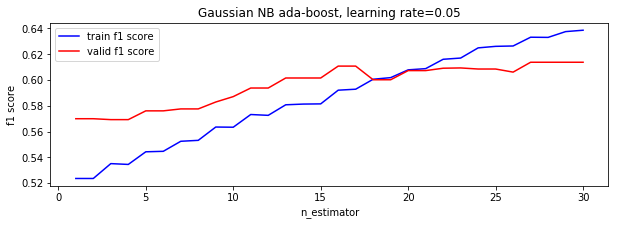

In [97]:
draw_train_valid_score(ns4, train_f1s_4, valid_f1s_4, 
                       title="Gaussian NB ada-boost, learning rate=0.05",
                       xlabel="n_estimator",
                       ylabel="f1 score"
                      )

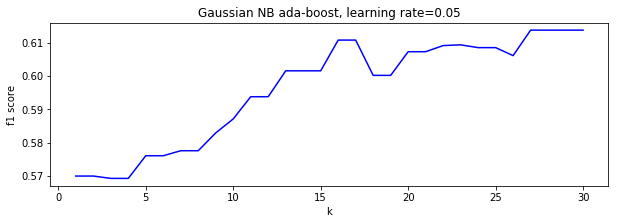

n_estimators maximize f1-score : 27 with 0.6137638734522723


In [98]:
draw_k_line_chart(ns4, valid_f1s_4, "f1 score", "Gaussian NB ada-boost, learning rate=0.05")
gnb_best_n_estimators_4 = ns4[np.argmax(valid_f1s_4)]
print("n_estimators maximize f1-score :", gnb_best_n_estimators_4, "with", valid_f1s_4[np.argmax(valid_f1s_4)])

## ada boosted gaussian nb, ns=3,tag+meta+audio, learning_rate=0.01 (

In [87]:
gnb_ada_discrete5 = AdaBoostClassifier(
    GaussianNB(),
    n_estimators=31,
    learning_rate=0.01,
    algorithm="SAMME",
    random_state=RANDOM_STATE)

ns5 = []
train_f1s_5 = []
valid_f1s_5 = []
for i in range(1, 36):
    ns5.append(i)
    gnb_ada_discrete5.set_params(n_estimators=i)
    gnb_ada_discrete5.fit(train_features_all, train_labels.values.ravel())
    
    pred = gnb_ada_discrete5.predict(valid_features_all)
    _, _, pref = evaluate(pred, valid_labels.values.ravel())
    valid_f1s_5.append(pref[2])
    
    pred = gnb_ada_discrete5.predict(train_features_all)
    _, _, pref = evaluate(pred, train_labels.values.ravel())
    train_f1s_5.append(pref[2])
    
    print(i, train_f1s_5[-1], valid_f1s_5[-1])

1 0.5235758765917979 0.5699485294842342
2 0.5235758765917979 0.5699485294842342
3 0.5263266758922277 0.5699485294842342
4 0.5263266758922277 0.5699485294842342
5 0.5286456980773984 0.5699485294842342
6 0.5286456980773984 0.5699485294842342
7 0.5312332320745525 0.5734523040216627
8 0.5312332320745525 0.5734523040216627
9 0.5331725811228206 0.5692452829449223
10 0.5331725811228206 0.5692452829449223
11 0.5348785944921047 0.5692452829449223
12 0.5348785944921047 0.5692452829449223
13 0.5370671450067821 0.5671144602248067
14 0.5370671450067821 0.5671144602248067
15 0.5391333967476939 0.570676331467599
16 0.5391333967476939 0.570676331467599
17 0.5410309305940566 0.5727165849547585
18 0.5409381165541516 0.5727165849547585
19 0.5424493547151954 0.5760488614365059
20 0.5424493547151954 0.5760488614365059
21 0.5443658403794532 0.5760488614365059
22 0.5441290072175773 0.5760488614365059
23 0.5452223074749725 0.5760488614365059
24 0.5449493391146372 0.5760488614365059
25 0.5462618429723858 0.569

In [ ]:
draw_train_valid_score(ns5, train_f1s_5, valid_f1s_5, 
                       title="Gaussian NB ada-boost, learning rate=0.05",
                       xlabel="n_estimator",
                       ylabel="f1 score"
                      )

In [ ]:
draw_k_line_chart(ns5, valid_f1s_5, "f1 score", "Gaussian NB ada-boost, learning rate=0.01")
gnb_best_n_estimators_5 = ns5[np.argmax(valid_f1s_5)]
print("n_estimators maximize f1-score :", gnb_best_n_estimators_5, "with", valid_f1s_5[np.argmax(valid_f1s_5)])

## ada boosted dt, ns=35, max_depth=10, tag+meta+audio (0.47656)

### bosting hyper parameter tuning

In [72]:
dt_ada_discrete = AdaBoostClassifier(
    DecisionTreeClassifier(criterion="entropy",
                            random_state=RANDOM_STATE,
                            max_depth=10),
    n_estimators=21,
    learning_rate=1,
    algorithm="SAMME",
    random_state=RANDOM_STATE)

ns_dt = []
train_dt_f1s = []
valid_dt_f1s = []
for i in range(1, 51):
    ns_dt.append(i)
    dt_ada_discrete.set_params(n_estimators=i)
    dt_ada_discrete.fit(train_features_all, train_labels.values.ravel())
    
    pred = dt_ada_discrete.predict(valid_features_all)
    _, _, pref = evaluate(pred, valid_labels.values.ravel())
    valid_dt_f1s.append(pref[2])
    
    pred = dt_ada_discrete.predict(train_features_all)
    _, _, pref = evaluate(pred, train_labels.values.ravel())
    train_dt_f1s.append(pref[2])
    
    print(i, train_dt_f1s[-1], valid_dt_f1s[-1])

1 0.7400648963993823 0.46007713157706465
2 0.6269017007066869 0.3785023772240249
3 0.7547723993862121 0.45273656918561256
4 0.8435074186306182 0.4765587210747193
5 0.8820498342297731 0.4762499526856593
6 0.8900508208689594 0.4682287969764766
7 0.9204200178726017 0.4960604186458139
8 0.9546760467412565 0.4788902114560494
9 0.9692733027392999 0.47983570330852776
10 0.9725580810953213 0.4876435899141189
11 0.9794565827886261 0.49372913891784903
12 0.9862344284292635 0.5130375337801114
13 0.9862837026756299 0.4951318735798368
14 0.9935796411843234 0.49473325763188225
15 0.9946634944555781 0.5028957693323948
16 0.9946772027496372 0.5066387103622509
17 0.9969182256853912 0.49778857215278743
18 0.9976661502653368 0.4909332393436747
19 0.9972877745958701 0.493612065912409
20 0.9995697297050392 0.5157247220675837
21 0.9992154350706932 0.5125746001128273
22 0.9991721519989096 0.5241458212318948
23 0.999690372086478 0.5224420502240973
24 0.999525019819357 0.5275258082365094
25 0.9994809333059114 

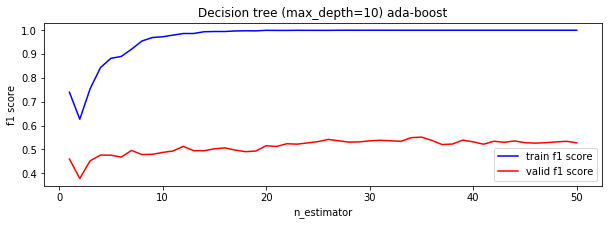

In [74]:
draw_train_valid_score(ns_dt, train_dt_f1s, valid_dt_f1s, 
                       title="Decision tree (max_depth=10) ada-boost",
                       xlabel="n_estimator",
                       ylabel="f1 score"
                      )

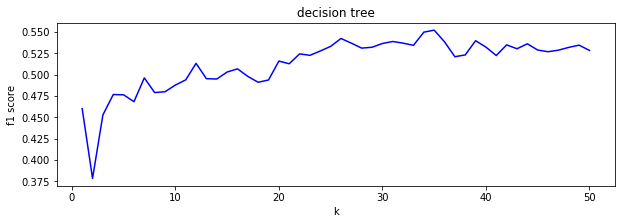

n_estimators maximize f1-score : 35 with 0.5519200262873434


In [88]:
draw_k_line_chart(ns_dt, valid_dt_f1s, "f1 score", "decision tree")
dt_best_n_estimators = ns_dt[np.argmax(valid_dt_f1s)]
print("n_estimators maximize f1-score :", dt_best_n_estimators, "with", valid_dt_f1s[np.argmax(valid_dt_f1s)])

### train valid

In [89]:
dt_ada_discrete.set_params(n_estimators=dt_best_n_estimators)
dt_ada_discrete.fit(train_features_all, train_labels.values.ravel())

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False,
            random_state=90049, splitter='best'),
          learning_rate=1, n_estimators=35, random_state=90049)

0.5519200262873434
                       precision    recall  f1-score   support

      soul and reggae       0.32      0.60      0.42        55
 classic pop and rock       0.80      0.18      0.29        45
                metal       0.32      0.52      0.39        64
                 folk       0.80      0.18      0.30        44
                  pop       0.94      0.71      0.81        66
dance and electronica       0.93      0.86      0.90        74
       jazz and blues       0.57      0.68      0.62        44
                 punk       0.73      0.66      0.69        58

          avg / total       0.68      0.58      0.58       450



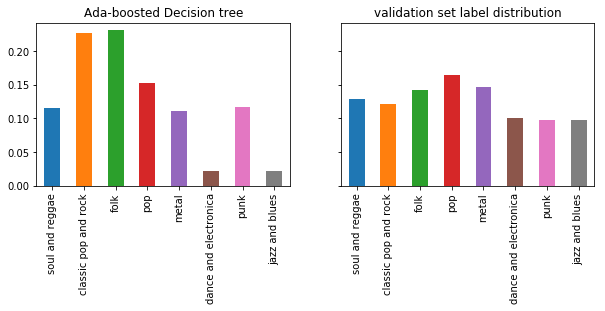

In [90]:
pred = dt_ada_discrete.predict(valid_features_all)
_, _, pref = evaluate(pred, valid_labels)
print(pref[2])
print(classification_report(valid_labels, pred, target_names=valid_labels["genre"].unique()))
draw_train_valid_label_distribution(pd.DataFrame(pred, columns=valid_labels.columns, index=valid_features_all.index), 
                                    valid_labels,
                                    title1="Ada-boosted Decision tree")

### test

In [91]:
# rf

models = [dt_ada_discrete]
test_preds = predict(models, test_features_all)
test_preds[0].reset_index(level=0).to_csv(path_or_buf="test_pred.csv", columns=["trackID", "genre"], index=False)

## bagging gaussian nb, tag+meta+audio (0.53125)

### hyper parameter tuning

In [56]:
bagging_gaussian_nb_clf = BaggingClassifier(base_estimator=GaussianNB(),
                            n_estimators=10, 
                            random_state=RANDOM_STATE)

ns_bagging = []
train_bagging_f1s = []
valid_bagging_f1s = []
for i in range(1, 41):
    ns_bagging.append(i)
    bagging_gaussian_nb_clf.set_params(n_estimators=i)
    bagging_gaussian_nb_clf.fit(train_features_all, train_labels.values.ravel())
    
    pred = bagging_gaussian_nb_clf.predict(valid_features_all)
    _, _, pref = evaluate(pred, valid_labels.values.ravel())
    valid_bagging_f1s.append(pref[2])
    
    pred = bagging_gaussian_nb_clf.predict(train_features_all)
    _, _, pref = evaluate(pred, train_labels.values.ravel())
    train_bagging_f1s.append(pref[2])
    
    print(i, train_bagging_f1s[-1], valid_bagging_f1s[-1])

1 0.5218784343374918 0.5742057144875848
2 0.5342551709935501 0.5844636053323603
3 0.5304845737054292 0.5882331899603812
4 0.5394987145664613 0.6011205438937848
5 0.5390741518662311 0.5843336003270332
6 0.5335271922128393 0.5938612744058906
7 0.5297402390117263 0.5736306519009519
8 0.5263710149697887 0.5708958495949479
9 0.527472278543329 0.5799996815853242
10 0.524662678180265 0.5866477190091421
11 0.5194243846884437 0.582595577990919
12 0.5180465481402868 0.5798355123768153
13 0.5154771594089339 0.5765208117653878
14 0.5134636996876201 0.5795524818583937
15 0.5175479058647924 0.5795524818583937
16 0.5194930932929034 0.5778493609611802
17 0.52292048901748 0.5809322691458609
18 0.523837799712771 0.5773667504453103
19 0.523081931064423 0.5780885105194878
20 0.5232893313383268 0.5778493609611802
21 0.5216599674701196 0.5785581397597066
22 0.522702238336961 0.5779325136450053
23 0.5216683205108877 0.5776548769281338
24 0.5201974143246855 0.5778691786434436
25 0.5208692873329775 0.574514728

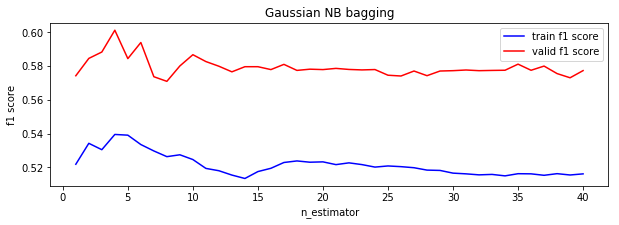

In [69]:
draw_train_valid_score(ns_bagging, train_bagging_f1s, valid_bagging_f1s, 
                       title="Gaussian NB bagging",
                       xlabel="n_estimator",
                       ylabel="f1 score"
                      )

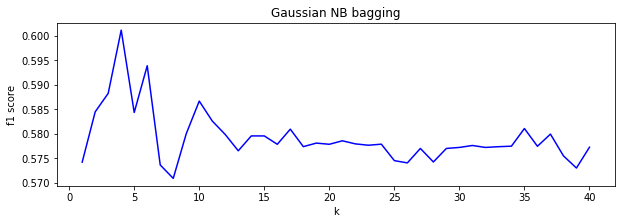

n_estimators maximize f1-score : 4 with 0.6011205438937848


In [71]:
draw_k_line_chart(ns_bagging, valid_bagging_f1s, "f1 score", "Gaussian NB bagging")
bagging_gaussian_nb_best_n_estimators = ns_bagging[np.argmax(valid_bagging_f1s)]
print("n_estimators maximize f1-score :", bagging_gaussian_nb_best_n_estimators, 
      "with", valid_bagging_f1s[np.argmax(valid_bagging_f1s)])

### train valid

In [72]:
bagging_gaussian_nb_clf.set_params(n_estimators=bagging_ada_gaussian_nb_best_n_estimators)
bagging_gaussian_nb_clf.fit(train_features_all, train_labels.values.ravel())

BaggingClassifier(base_estimator=GaussianNB(), n_estimators=19,
                  random_state=90049)

0.5780885105194878
                       precision    recall  f1-score   support

      soul and reggae       0.30      0.44      0.35        55
 classic pop and rock       0.60      0.27      0.37        45
                metal       0.76      0.20      0.32        64
                 folk       0.37      0.66      0.47        44
                  pop       0.85      0.85      0.85        66
dance and electronica       0.80      1.00      0.89        74
       jazz and blues       0.91      0.45      0.61        44
                 punk       0.69      0.86      0.77        58

             accuracy                           0.62       450
            macro avg       0.66      0.59      0.58       450
         weighted avg       0.67      0.62      0.60       450



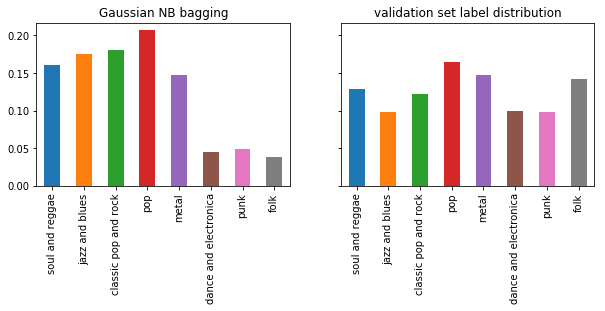

In [74]:
pred = bagging_gaussian_nb_clf.predict(valid_features_all)
_, _, pref = evaluate(pred, valid_labels)
print(pref[2])
print(classification_report(valid_labels, pred, target_names=valid_labels["genre"].unique()))
draw_train_valid_label_distribution(pd.DataFrame(pred, columns=valid_labels.columns, index=valid_features_all.index), 
                                    valid_labels,
                                    title1="Gaussian NB bagging")

### test

In [75]:
# rf

models = [bagging_gaussian_nb_clf]
test_preds = predict(models, test_features_all)
test_preds[0].reset_index(level=0).to_csv(path_or_buf="test_pred.csv", columns=["trackID", "genre"], index=False)

## ada boosting bagged gaussian nb, tags+meta+audio ()

### hyper parameter tuning

In [76]:
gnb_boost_bag_clf = AdaBoostClassifier(
    BaggingClassifier(base_estimator=GaussianNB(),
                            n_estimators=4, 
                            random_state=RANDOM_STATE),
    n_estimators=21,
    learning_rate=1,
    algorithm="SAMME",
    random_state=RANDOM_STATE)

ns = []
train_boost_bag_f1s = []
valid_boost_bag_f1s = []
for i in range(1, 21):
    ns.append(i)
    gnb_boost_bag_clf.set_params(n_estimators=i)
    gnb_boost_bag_clf.fit(train_features_all, train_labels.values.ravel())
    
    pred = gnb_boost_bag_clf.predict(valid_features_all)
    _, _, pref = evaluate(pred, valid_labels.values.ravel())
    valid_boost_bag_f1s.append(pref[2])
    
    pred = gnb_boost_bag_clf.predict(train_features_all)
    _, _, pref = evaluate(pred, train_labels.values.ravel())
    train_boost_bag_f1s.append(pref[2])
    
    print(i, train_boost_bag_f1s[-1], valid_boost_bag_f1s[-1])

1 0.5253425583728569 0.5828607963136269
2 0.5253425583728569 0.5828607963136269
3 0.560962986559321 0.5909258272086713
4 0.598232086317057 0.6021750488406911
5 0.5417040936374418 0.5321089532952916
6 0.569449573546134 0.5487664596633639
7 0.5756176406615908 0.5547525169616769
8 0.6060913652944153 0.5857500805847368
9 0.6010382207812138 0.5897200327304408
10 0.5947579396128735 0.5966150987003382
11 0.5982751986239456 0.5833226293838156
12 0.5959634995076322 0.5778309473723482
13 0.5941198430601732 0.5813657260508356
14 0.5872913322115674 0.5868702542890047
15 0.6153405242293404 0.5855113458593199
16 0.611780483900752 0.5841579674714538
17 0.6141057861260275 0.5836737898203188
18 0.6137550458067571 0.5682496172188068
19 0.6284876499270258 0.6074779314490651
20 0.6245521345703902 0.5838772359324098


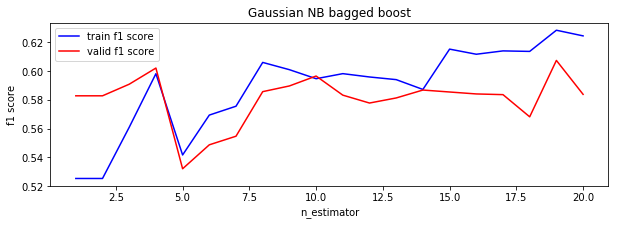

In [77]:
draw_train_valid_score(ns, train_boost_bag_f1s, valid_boost_bag_f1s, 
                       title="Gaussian NB bagged boost",
                       xlabel="n_estimator",
                       ylabel="f1 score"
                      )

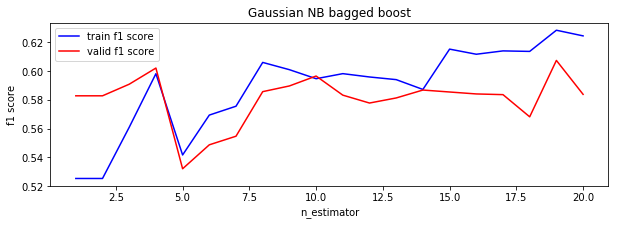

In [78]:
draw_train_valid_score(ns, train_boost_bag_f1s, valid_boost_bag_f1s, 
                       title="Gaussian NB bagged boost",
                       xlabel="n_estimator",
                       ylabel="f1 score"
                      )

### train valid

## bagging ada-boosted gaussian nb, tag+meta+audio (0.60156)

### bagging hyper parameter tuning 

In [59]:
bagging_ada_gaussian_nb_clf = BaggingClassifier(base_estimator=AdaBoostClassifier(
                                                            GaussianNB(),
                                                            n_estimators=3,
                                                            learning_rate=1,
                                                            algorithm="SAMME",
                                                            random_state=RANDOM_STATE),
                            n_estimators=10, 
                            random_state=RANDOM_STATE)

ns_ada_bagging = []
train_ada_bagging_f1s = []
valid_ada_bagging_f1s = []
for i in range(1, 31):
    ns_ada_bagging.append(i)
    bagging_ada_gaussian_nb_clf.set_params(n_estimators=i)
    bagging_ada_gaussian_nb_clf.fit(train_features_all, train_labels.values.ravel())
    
    pred = bagging_ada_gaussian_nb_clf.predict(valid_features_all)
    _, _, pref = evaluate(pred, valid_labels.values.ravel())
    valid_ada_bagging_f1s.append(pref[2])
    
    pred = bagging_ada_gaussian_nb_clf.predict(train_features_all)
    _, _, pref = evaluate(pred, train_labels.values.ravel())
    train_ada_bagging_f1s.append(pref[2])
    
    print(i, train_ada_bagging_f1s[-1], valid_ada_bagging_f1s[-1])

1 0.5893368199891968 0.6175536775270346
2 0.5984977569197717 0.609887206422798
3 0.6107630200221057 0.6039390425314847
4 0.6151759905450958 0.6178230919890095
5 0.6219143561578971 0.6201187652487481
6 0.6191352471012042 0.618508957907819
7 0.6169792464935854 0.6141683895381709
8 0.6266272462133262 0.6154899395825406
9 0.6291832271980476 0.6127434232373727
10 0.6295263842875234 0.6186538335421475
11 0.6297013929983271 0.6186934291228418
12 0.6272183249171432 0.6176262479516528
13 0.6251730560743819 0.6178269253334288
14 0.6263238302571184 0.614752221599062
15 0.6301458841007437 0.619691287346767
16 0.6306057449578233 0.6155927445685729
17 0.6328469848235689 0.6254868416085755
18 0.635177690990594 0.6177483584834941
19 0.6336392432394855 0.627939519740588
20 0.6330854464440503 0.624992865845968
21 0.6318110943264489 0.6179953290967624
22 0.628680580781062 0.6224059794842915
23 0.6309533776558838 0.6238954852062149
24 0.6311249866587334 0.622126062465526
25 0.6314491783422858 0.6250949866

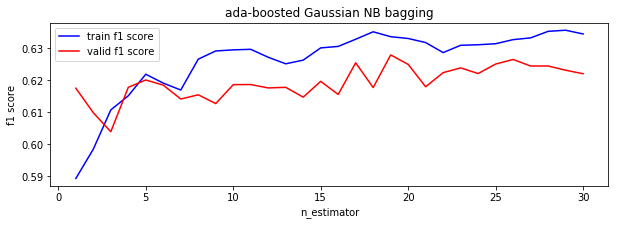

In [62]:
draw_train_valid_score(ns_ada_bagging, train_ada_bagging_f1s, valid_ada_bagging_f1s, 
                       title="ada-boosted Gaussian NB bagging",
                       xlabel="n_estimator",
                       ylabel="f1 score"
                      )

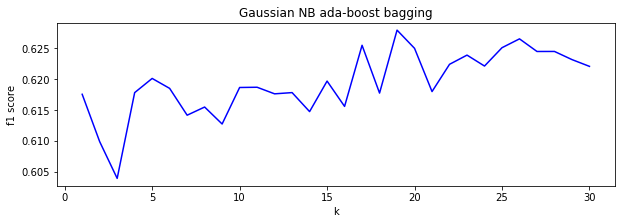

n_estimators maximize f1-score : 19 with 0.627939519740588


In [68]:
draw_k_line_chart(ns_ada_bagging, valid_ada_bagging_f1s, "f1 score", "Gaussian NB ada-boost bagging")
bagging_ada_gaussian_nb_best_n_estimators = ns_bagging[np.argmax(valid_ada_bagging_f1s)]
print("n_estimators maximize f1-score :", bagging_ada_gaussian_nb_best_n_estimators, 
      "with", valid_ada_bagging_f1s[np.argmax(valid_ada_bagging_f1s)])

### train valid

In [65]:
bagging_ada_gaussian_nb_clf.set_params(n_estimators=bagging_ada_gaussian_nb_best_n_estimators)
bagging_ada_gaussian_nb_clf.fit(train_features_all, train_labels.values.ravel())

BaggingClassifier(base_estimator=AdaBoostClassifier(algorithm='SAMME',
                                                    base_estimator=GaussianNB(),
                                                    learning_rate=1,
                                                    n_estimators=3,
                                                    random_state=90049),
                  n_estimators=19, random_state=90049)

0.627939519740588
                       precision    recall  f1-score   support

 classic pop and rock       0.38      0.36      0.37        55
dance and electronica       0.57      0.27      0.36        45
                 folk       0.81      0.39      0.53        64
       jazz and blues       0.34      0.68      0.46        44
                metal       0.87      0.83      0.85        66
                  pop       0.94      1.00      0.97        74
                 punk       0.86      0.70      0.78        44
      soul and reggae       0.61      0.84      0.71        58

             accuracy                           0.66       450
            macro avg       0.67      0.64      0.63       450
         weighted avg       0.70      0.66      0.65       450



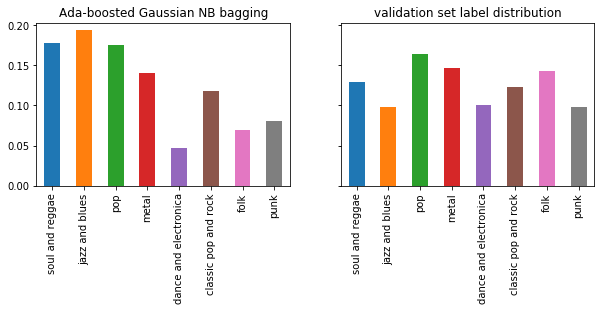

In [215]:
pred = bagging_ada_gaussian_nb_clf.predict(valid_features_all)
_, _, pref = evaluate(pred, valid_labels)
print(pref[2])
print(classification_report(valid_labels, pred, target_names=bagging_ada_gaussian_nb_clf.classes_))
draw_train_valid_label_distribution(pd.DataFrame(pred, columns=valid_labels.columns, index=valid_features_all.index), 
                                    valid_labels,
                                    title1="Ada-boosted Gaussian NB bagging")

### test

In [67]:
# rf

models = [bagging_ada_gaussian_nb_clf]
test_preds = predict(models, test_features_all)
test_preds[0].reset_index(level=0).to_csv(path_or_buf="test_pred.csv", columns=["trackID", "genre"], index=False)

## stacking estimators=ada boosted dt & gaussian nb, final=None, tag+meta+audio (seems not good)

In [26]:
estimators = [
     ('Ada-boosted Gaussian NB', AdaBoostClassifier(
                GaussianNB(),
                n_estimators=3,
                learning_rate=1,
                algorithm="SAMME",
                random_state=RANDOM_STATE) ),
     ('Ada-boosted decision tree', AdaBoostClassifier(
        DecisionTreeClassifier(criterion="entropy",
                                random_state=RANDOM_STATE,
                                max_depth=10),
        n_estimators=35,
        learning_rate=1,
        algorithm="SAMME",
        random_state=RANDOM_STATE) )
]

stack_clf = StackingClassifier(
    estimators=estimators, 
    final_estimator=None
)

In [27]:
stack_clf.fit(train_features_all, train_labels.values.ravel())

StackingClassifier(estimators=[('Ada-boosted Gaussian NB',
                                AdaBoostClassifier(algorithm='SAMME',
                                                   base_estimator=GaussianNB(),
                                                   learning_rate=1,
                                                   n_estimators=3,
                                                   random_state=90049)),
                               ('Ada-boosted decision tree',
                                AdaBoostClassifier(algorithm='SAMME',
                                                   base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                                                         max_depth=10,
                                                                                         random_state=90049),
                                                   learning_rate=1,
                                                   n_estimato

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.17462358282460372
                       precision    recall  f1-score   support

      soul and reggae       0.14      0.85      0.24        55
 classic pop and rock       0.00      0.00      0.00        45
                metal       0.44      0.58      0.50        64
                 folk       0.00      0.00      0.00        44
                  pop       0.94      0.50      0.65        66
dance and electronica       0.00      0.00      0.00        74
       jazz and blues       0.00      0.00      0.00        44
                 punk       0.00      0.00      0.00        58

             accuracy                           0.26       450
            macro avg       0.19      0.24      0.17       450
         weighted avg       0.22      0.26      0.20       450



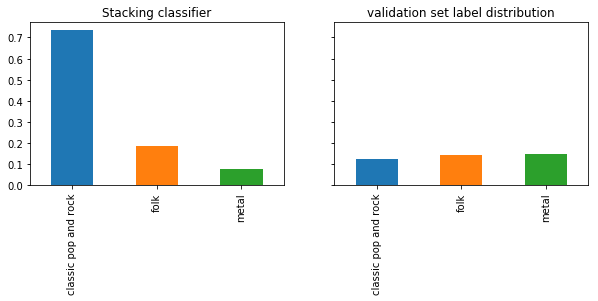

In [33]:
pred = stack_clf.predict(valid_features_all)
_, _, pref = evaluate(pred, valid_labels)
print(pref[2])
print(classification_report(valid_labels, pred, target_names=valid_labels["genre"].unique()))
draw_train_valid_label_distribution(pd.DataFrame(pred, columns=valid_labels.columns, index=valid_features_all.index), 
                                    valid_labels,
                                    title1="Stacking classifier")

### test

In [ ]:
# rf
models = [stack_clf]
test_preds = predict(models, test_features_all)
test_preds[0].reset_index(level=0).to_csv(path_or_buf="test_pred.csv", columns=["trackID", "genre"], index=False)

## mlp tag+meta+audio (0.59375)

### train

In [583]:
mlp = make_pipeline(StandardScaler(),
                    MLPClassifier(random_state=RANDOM_STATE, 
                                  max_iter=300,
                                  hidden_layer_sizes=100,
                                  activation='relu',
                                  solver='adam',
                                  alpha=0.0000001
                                 ))
mlp.fit(train_features_all, train_labels.values.ravel())

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(alpha=1e-07, hidden_layer_sizes=100,
                               max_iter=300, random_state=90049))])

### valid

0.5808965152459273
                       precision    recall  f1-score   support

      soul and reggae       0.37      0.55      0.44        55
 classic pop and rock       0.46      0.27      0.34        45
                metal       0.55      0.66      0.60        64
                 folk       0.40      0.14      0.20        44
                  pop       0.82      0.68      0.74        66
dance and electronica       0.91      0.99      0.95        74
       jazz and blues       0.62      0.77      0.69        44
                 punk       0.67      0.71      0.69        58

             accuracy                           0.63       450
            macro avg       0.60      0.59      0.58       450
         weighted avg       0.63      0.63      0.61       450



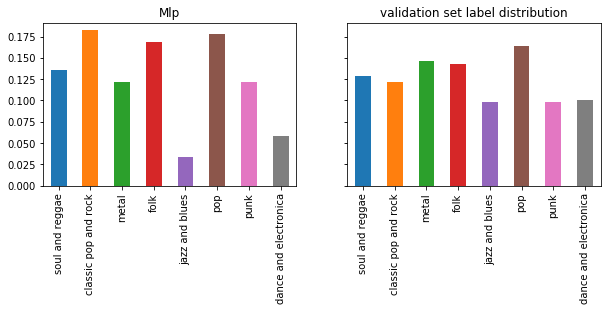

In [584]:
pred = mlp.predict(valid_features_all)
_, _, pref = evaluate(pred, valid_labels)
print(pref[2])
print(classification_report(valid_labels, pred, target_names=valid_labels["genre"].unique()))
draw_train_valid_label_distribution(pd.DataFrame(pred, columns=valid_labels.columns, index=valid_features_all.index), 
                                    valid_labels,
                                    title1="Mlp")

### test

In [585]:
models = [mlp]
test_preds = predict(models, test_features_all)
test_preds[0].reset_index(level=0).to_csv(path_or_buf="test_pred.csv", columns=["trackID", "genre"], index=False)

## ada boosting, mlp, tag+meta+audio ()

In [216]:
# boost_mlp = AdaBoostClassifier(
# #     base_estimator=make_pipeline(StandardScaler(),
# #                     MLPClassifier(random_state=RANDOM_STATE, 
# #                                   max_iter=300,
# #                                   hidden_layer_sizes=100,
# #                                   activation='relu',
# #                                   solver='adam'
# #                                  )),
#     base_estimator=MLPClassifier(random_state=RANDOM_STATE, 
#                                   max_iter=300,
#                                   hidden_layer_sizes=100,
#                                   activation='relu',
#                                   solver='adam'
#                                  ),
#     n_estimators=21,
#     learning_rate=1,
#     algorithm="SAMME",
#     random_state=RANDOM_STATE)


# ns_boost_mlp = []
# train_boost_mlp_f1s = []
# valid_boost_mlp_f1s = []
# for i in range(1, 11):
#     ns_boost_mlp.append(i)
#     boost_mlp.set_params(n_estimators=i)
#     boost_mlp.fit(train_features_all, train_labels.values.ravel())#, sample_weight=[1 for _ in range(0, 7678)])
    
#     pred = gnb_boost_bag_clf.predict(valid_features_all)
#     _, _, pref = evaluate(pred, valid_labels.values.ravel())
#     valid_boost_mlp_f1s.append(pref[2])
    
#     pred = gnb_boost_bag_clf.predict(train_features_all)
#     _, _, pref = evaluate(pred, train_labels.values.ravel())
#     train_boost_mlp_f1s.append(pref[2])
    
#     print(i, train_boost_mlp_f1s[-1], valid_boost_mlp_f1s[-1])

In [217]:
# draw_train_valid_score(ns_boost_mlp, train_boost_mlp_f1s, valid_boost_mlp_f1s, 
#                        title="Decision tree (max_depth=10) ada-boost",
#                        xlabel="n_estimator",
#                        ylabel="f1 score"
#                       )

In [218]:
# draw_k_line_chart(ns_boost_mlp, valid_boost_mlp_f1s, "f1 score", "MLP")
# boost_mlp_best_n_estimators = ns_dt[np.argmax(valid_boost_mlp_f1s)]
# print("n_estimators maximize f1-score :", boost_mlp_best_n_estimators, 
#       "with", valid_boost_mlp_f1s[np.argmax(valid_boost_mlp_f1s)])

## ada boosted gaussian nb, tag+meta+audio ()

### hyper parameter tuning

In [237]:
gnb_ada_discrete = AdaBoostClassifier(
    GaussianNB(),
    n_estimators=21,
    learning_rate=1,
    algorithm="SAMME",
    random_state=RANDOM_STATE)

ns = []
train_f1s = []

In [243]:
for i in range(51, 61):
    ns.append(i)
    gnb_ada_discrete.set_params(n_estimators=i)
    
    scores = cross_val_score(estimator=gnb_ada_discrete, 
                    X=train_features_all, 
                    y=train_labels.values.ravel(), 
                    cv=5,
                    scoring='f1_macro')
    train_f1s.append(np.mean(scores))
    
    print(i, train_f1s[-1])

51 0.5305737332992658
52 0.5328581603294527
53 0.5333552226986222
54 0.5304284244948634
55 0.5300199849915798
56 0.5284447088926856
57 0.5299516132475223
58 0.5286882697509558
59 0.527857114843
60 0.5302047601441605


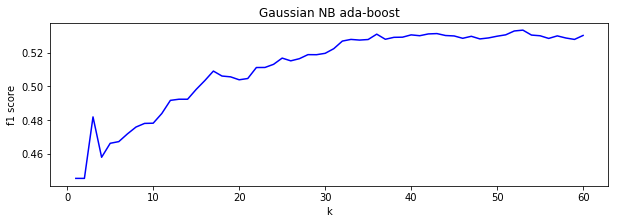

n_estimators maximize f1-score : 53 with 0.5333552226986222


In [244]:
draw_k_line_chart(ns, train_f1s, "f1 score", "Gaussian NB ada-boost")
gnb_best_n_estimators = ns[np.argmax(train_f1s)]
print("n_estimators maximize f1-score :", gnb_best_n_estimators, "with", train_f1s[np.argmax(train_f1s)])

### train valid

In [245]:
gnb_ada_discrete.set_params(n_estimators=gnb_best_n_estimators)
gnb_ada_discrete.fit(train_features_all, train_labels.values.ravel())

AdaBoostClassifier(algorithm='SAMME', base_estimator=GaussianNB(),
                   learning_rate=1, n_estimators=53, random_state=90049)

0.5735853877284858
                       precision    recall  f1-score   support

 classic pop and rock       0.34      0.49      0.40        55
dance and electronica       0.37      0.22      0.28        45
                 folk       0.55      0.66      0.60        64
       jazz and blues       0.50      0.25      0.33        44
                metal       0.93      0.59      0.72        66
                  pop       0.91      0.97      0.94        74
                 punk       0.60      0.77      0.67        44
      soul and reggae       0.61      0.69      0.65        58

             accuracy                           0.61       450
            macro avg       0.60      0.58      0.57       450
         weighted avg       0.63      0.61      0.60       450



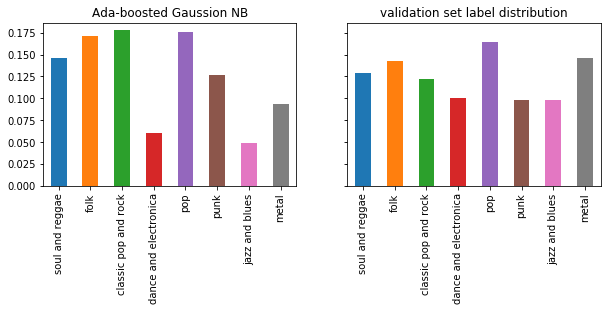

In [246]:
pred = gnb_ada_discrete.predict(valid_features_all)
_, _, pref = evaluate(pred, valid_labels)
print(pref[2])
print(classification_report(valid_labels, pred, target_names=gnb_ada_discrete.classes_))
draw_train_valid_label_distribution(pd.DataFrame(pred, columns=valid_labels.columns, index=valid_features_all.index), 
                                    valid_labels,
                                    title1="Ada-boosted Gaussion NB")

### test

In [247]:
# rf

models = [gnb_ada_discrete]
test_preds = predict(models, test_features_all)
test_preds[0].reset_index(level=0).to_csv(path_or_buf="test_pred.csv", columns=["trackID", "genre"], index=False)

## logistic regression ()

### train valid

In [662]:
lg_clf = LogisticRegression(random_state=RANDOM_STATE,
                            max_iter=500
                           )
lg_clf.fit(train_all_features, train_labels.values.ravel())

LogisticRegression(max_iter=500, random_state=90049)

0.35154953837963765
                       precision    recall  f1-score   support

 classic pop and rock       0.23      0.64      0.34        55
dance and electronica       0.50      0.16      0.24        45
                 folk       0.34      0.56      0.43        64
       jazz and blues       0.29      0.05      0.08        44
                metal       0.76      0.52      0.61        66
                  pop       0.29      0.03      0.05        74
                 punk       0.36      0.57      0.44        44
      soul and reggae       0.68      0.59      0.63        58

             accuracy                           0.39       450
            macro avg       0.43      0.39      0.35       450
         weighted avg       0.44      0.39      0.36       450



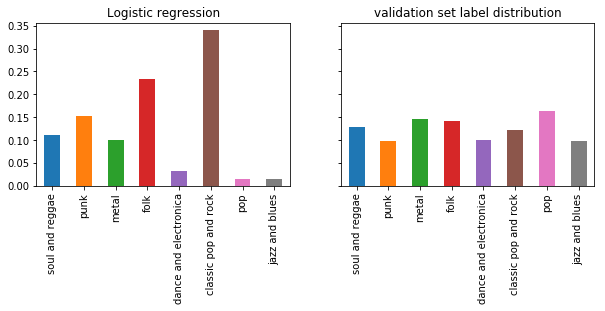

In [663]:
pred = lg_clf.predict(valid_all_features)
_, _, pref = evaluate(pred, valid_labels)
print(pref[2])
print(classification_report(valid_labels, pred, target_names=lg_clf.classes_))
draw_train_valid_label_distribution(pd.DataFrame(pred, columns=valid_labels.columns, index=valid_all_features.index), 
                                    valid_labels,
                                    title1="Logistic regression")

# End

In [ ]:
# Introduction to machine learning is fun!